# Use spectra of CTIO Data in June 2017 to do atmospheric studies
==================================================================================================

- author : Sylvie Dagoret-Campagne
- date   : June 9th 2017




In [3]:
%%javascript
var kernel = IPython.notebook.kernel;
var thename = window.document.getElementById("notebook_name").innerHTML;
var command = "theNotebook = " + "'"+thename+"'";
kernel.execute(command);

<IPython.core.display.Javascript object>

In [4]:
print theNotebook

AnaAerCalibSpectrum


In [5]:
from matplotlib.backends.backend_pdf import PdfPages

In [6]:
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import matplotlib as mpl
from astropy.modeling import models
from astropy import units as u
from astropy import nddata
from astropy.io import fits
import re
import os
import pandas as pd

In [7]:
import ccdproc
print 'ccdproc version',ccdproc.__version__

from astropy.modeling import models

ccdproc version 1.0.1


In [8]:
from scipy import stats  
from scipy import ndimage
from datetime import datetime, timedelta
from mpl_toolkits.mplot3d import Axes3D
import scipy.signal
from scipy.interpolate import interp1d
from scipy.optimize import curve_fit

In [9]:
%load_ext Cython

In [10]:
from IPython.display import Image, display

In [11]:
import matplotlib
matplotlib.rc('xtick', labelsize=20) 
matplotlib.rc('ytick', labelsize=20) 

In [12]:
from scipy.interpolate import interp1d

In [13]:
import datetime
from dateutil import parser  # very usefull time format smart parser

In [14]:
from matplotlib.dates import MonthLocator, WeekdayLocator,DateFormatter
from matplotlib.dates import MONDAY

In [15]:
mondays = WeekdayLocator(MONDAY)
months = MonthLocator(range(1, 13), bymonthday=1, interval=1)
monthsFmt = DateFormatter("%b '%y")

In [49]:
import matplotlib.dates as mdates

years = mdates.YearLocator()   # every year
months = mdates.MonthLocator()  # every month
days=mdates.DayLocator()  # every day
hour=mdates.HourLocator()  # every day
yearsFmt = mdates.DateFormatter('%Y')

In [16]:
# to enlarge the sizes
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (10, 10),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
plt.rcParams.update(params)

In [17]:
%config InlineBackend.rc = {}
matplotlib.rc_file("../../templates/matplotlibrc")

/Users/dagoret-campagnesylvie/anaconda/envs/pyastrophys/lib/python2.7/site-packages/matplotlib/__init__.py:913: UserWarning: axes.color_cycle is deprecated and replaced with axes.prop_cycle; please use the latter.
  warnings.warn(self.msg_depr % (key, alt_key))


In [18]:
############################################################################
def ensure_dir(f):
    d = os.path.dirname(f)
    if not os.path.exists(f):
        os.makedirs(f)
#########################################################################

In [19]:
class ListTable(list):
    """ Overridden list class which takes a 2-dimensional list of 
        the form [[1,2,3],[4,5,6]], and renders an HTML Table in 
        IPython Notebook. """
    
    def _repr_html_(self):
        html = ["<table>"]
        for row in self:
            html.append("<tr>")
            
            for col in row:
                html.append("<td>{0}</td>".format(col))
            
            html.append("</tr>")
        html.append("</table>")
        return ''.join(html)

In [20]:
def truncate(f, n):
    '''Truncates/pads a float f to n decimal places without rounding'''
    s = '{}'.format(f)
    if 'e' in s or 'E' in s:
        return '{0:.{1}f}'.format(f, n)
    i, p, d = s.partition('.')
    return '.'.join([i, (d+'0'*n)[:n]])

### Output directory for images generated in the notebook view (not true fits images)¶¶

In [21]:
dir_top_images="images_notebooks/"+theNotebook ### Top directory to save images

In [22]:
ensure_dir(dir_top_images) # create that directory

### Input fits file

In [23]:
inputdir="./spectrum_calibspec"
MIN_IMGNUMBER=208  # skip the 58 which is not at the right place
MAX_IMGNUMBER=284
object_name='HD205905 May 30th'
SelectTagRe='^calibSpectra_20170530_([0-9]+).fits$' # regular expression to select the file
SearchTagRe='^calibSpectra_20170530_[0-9]+.fits$'
NBIMGPERROW=2

### Output Fits file

In [24]:
outputdir="./spectrum_anaaer"

In [25]:
ensure_dir(outputdir)

In [26]:
output_file='AnaAtmAerFromSpectra_'+object_name+'.csv'

## Location of calibrated spectra and Simulations
----------------------------------

In [27]:
input_filelist=os.listdir(inputdir) 

In [28]:
if '.DS_Store' in input_filelist:
    input_filelist.remove('.DS_Store')
input_filelist=np.array(input_filelist)

In [29]:
print input_filelist[0:5]

['calibSpectra_20170530_210.fits' 'calibSpectra_20170530_211.fits'
 'calibSpectra_20170530_212.fits' 'calibSpectra_20170530_213.fits'
 'calibSpectra_20170530_214.fits']


In [30]:
if re.search('^calibSpectra_20170530_[0-9]+.fits$',input_filelist[0]):
    print 'OK'

OK


In [31]:
indexes_files= [] # global list
filelist_fitsimages= []  # global list

In [32]:
#%%cython

import numpy as np
import re

def MakeFileList(inputdir,input_filelist):
    """
    MakeFileList : Make The List of files to open
    =============
    """
    
#    import numpy as np
#    import re
    indexes_files= [] # global list
    filelist_fitsimages= []  # global list
    
    for file in input_filelist: # loop on directories, one per image       
            filename=inputdir+'/'+file 
            
            if re.search('.*fits$',filename):  #example of filename filter
                
                num_str=re.findall(SelectTagRe,file)[0]
               
                index=int(num_str)
                filelist_fitsimages.append(filename)
                indexes_files.append(index)   
                
                
    return indexes_files, filelist_fitsimages

In [33]:
indexes_files, filelist_fitsimages=MakeFileList(inputdir,input_filelist)   # filter to select fits file only

In [34]:
# transform into numpy arrays
indexes_files=np.array(indexes_files)
filelist_fitsimages=np.array(filelist_fitsimages)

In [35]:
print indexes_files

[210 211 212 213 214 215 216 217 218 219 220 221 222 223 224 225 226 227
 228 229 230 231 232 233 234 235 236 237 238 239 240 241 242 243 244 245
 246 247 248 249 250 251 252 253 254 255 256 257 258 259 260 261 262 263
 264 265 266 267 268 269 270 271 272 273 274 275 276 277 278 279 280 281
 282 283 284]


In [36]:
sorted_indexes=np.argsort(indexes_files) # sort the file indexes

In [37]:
sorted_numbers=indexes_files[sorted_indexes]

In [38]:
print sorted_indexes

[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49
 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72 73 74]


In [39]:
#sorted_files= [filelist_fitsimages[index] for index in sorted_indexes] # sort files
sorted_files=filelist_fitsimages[sorted_indexes]

In [40]:
sorted_files[0:5]

array(['./spectrum_calibspec/calibSpectra_20170530_210.fits',
       './spectrum_calibspec/calibSpectra_20170530_211.fits',
       './spectrum_calibspec/calibSpectra_20170530_212.fits',
       './spectrum_calibspec/calibSpectra_20170530_213.fits',
       './spectrum_calibspec/calibSpectra_20170530_214.fits'], 
      dtype='|S51')

## Build full filename
----------------------------

In [41]:
sorted_filenames=[]
for file in sorted_files:
    #fullfilename=os.path.join(inputdir,file)
    fullfilename=file
    sorted_filenames.append(fullfilename)

In [42]:
#sorted_filenames=np.array(sorted_filenames)
sorted_filenames=np.copy(sorted_files)

In [43]:
print sorted_filenames.shape

(75,)


## Acces to spectrum data
----------------------------------

In [44]:
%%cython

import numpy as np
from astropy.io import fits

def BuildCalibSpec(sorted_filenames,sorted_numbers,object_name):
    """
    BuildRawSpec
    ===============
    """

    all_dates = []
    all_airmass = []
    all_leftspectra_data = []
    all_rightspectra_data = []
    
    all_leftspectra_wl = []
    all_rightspectra_wl = []
    all_titles = []
    all_header = []
    all_expo = []
    all_filt= []
   
    NBFILES=sorted_filenames.shape[0]

    for idx in range(NBFILES):  
        
        file=sorted_filenames[idx]    
        
        hdu_list=fits.open(file)
        
        #hdu_list.info()
        
        header=hdu_list[0].header
        #print header
        date_obs = header['DATE-OBS']
        airmass = header['AIRMASS']
        expo = header['EXPTIME']
        num=sorted_numbers[idx]
        title=object_name+" z= {:3.2f} Nb={}".format(float(airmass),num)
        filters = header['FILTERS'].split(' ')[1]
        
        # now reads the spectra
        
        table_data=hdu_list[1].data
        
        #cols = hdu_list[1].columns
        #cols.info()
        #print hdu_list[1].columns
        #cols.names
  
        #col1=fits.Column(name='CalibLeftSpecWL',format='E',array=theleftwl_cut[idx[0]])
        #col2=fits.Column(name='CalibLeftSpecData',format='E',array=theleftspectrum_cut[idx[0]])
        #col3=fits.Column(name='CalibLeftSpecSim',format='E',array=theleftsimspec_cut[idx[0]])
        #col4=fits.Column(name='CalibRightSpecWL',format='E',array=therightwl_cut[idx[0]])
        #col5=fits.Column(name='CalibRightSpecData',format='E',array=therightspectrum_cut[idx[0]])
        #col6=fits.Column(name='CalibRightSpecSim',format='E',array=therightsimspec_cut[idx[0]])
    
    
        left_spectrum_wl=table_data.field('CalibLeftSpecWL')
        left_spectrum_data=table_data.field('CalibLeftSpec')
       
        
        right_spectrum_wl=table_data.field('CalibRightSpecWL')
        right_spectrum_data=table_data.field('CalibRightSpec')
       
        
        all_dates.append(date_obs)
        all_airmass.append(float(airmass))
        
        all_leftspectra_data.append(left_spectrum_data)
        all_rightspectra_data.append(right_spectrum_data)
        
        all_leftspectra_wl.append(left_spectrum_wl)
        all_rightspectra_wl.append(right_spectrum_wl)
        
       
        
        all_titles.append(title)
        all_header.append(header)
        all_expo.append(expo)
        
        all_filt.append(filters)
            
        hdu_list.close()
        
    return all_dates,all_airmass,all_titles,all_header,all_expo, all_leftspectra_data,all_rightspectra_data, all_leftspectra_wl,all_rightspectra_wl,        all_filt

In [45]:
all_dates,all_airmass,all_titles,all_header,all_expo,all_leftspectra_data,all_rightspectra_data,all_leftspectra_wl,all_rightspectra_wl,all_filt=BuildCalibSpec(sorted_files,sorted_numbers,object_name)

In [46]:
print len(all_dates)

75


## Airmass

In [47]:
NDATA=len(all_rightspectra_data)
all_dt= [ parser.parse(all_dates[i]) for i in range(NDATA)]

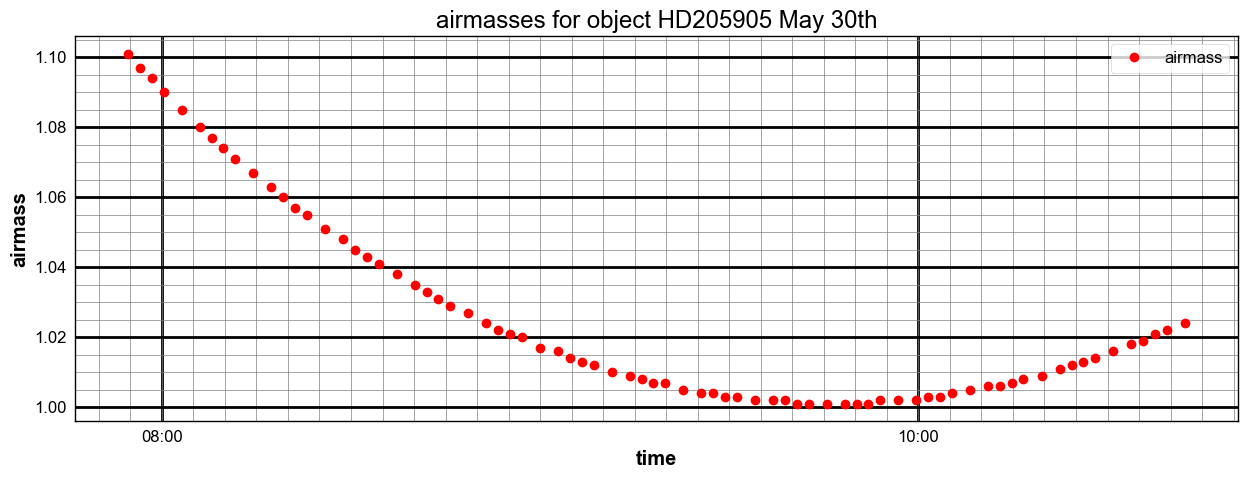

In [51]:
fig=plt.figure(figsize=(15,5))

ax=fig.add_subplot(1,1,1)
ax.plot_date(all_dt, all_airmass,marker='o',color='red',lw=0,label='airmass',linewidth=3)
#ax.plot_date(all_dt, am,marker='.',color='blue',lw=0,label='relative airmass',linewidth=3)

#ax.set_ylim(0.,2)

date_range = all_dt[NDATA-1] - all_dt[0]

if date_range > datetime.timedelta(days = 1):
    ax.xaxis.set_major_locator(mdates.DayLocator(bymonthday=range(1,32), interval=1))
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m-%d'))
    ax.get_xaxis().set_minor_locator(mdates.HourLocator(byhour=range(0,24,2)))
    #ax.get_yaxis().set_minor_locator(mpl.ticker.AutoMinorLocator())
else:
    ax.xaxis.set_major_locator(mdates.HourLocator(byhour=range(0,24,2)))
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%H:%M'))
    #ax.get_xaxis().set_minor_locator(mpl.ticker.AutoMinorLocator())
    ax.get_xaxis().set_minor_locator(mdates.MinuteLocator(byminute=range(0,60,5)))
    
ax.get_yaxis().set_minor_locator(mpl.ticker.AutoMinorLocator())

ax.grid(b=True, which='major', color='k', linewidth=2.0)
ax.grid(b=True, which='minor', color='grey', linewidth=0.5)
ax.set_ylabel('airmass')
ax.set_xlabel('time')


title='airmasses for object {}'.format(object_name)

plt.title(title)
plt.legend(loc='best')

figfilename=os.path.join(dir_top_images,'airmass_vs_time.pdf')
fig.savefig(figfilename)

## Show Spectra
==========================

In [52]:
NDATA=len(all_rightspectra_data)

In [53]:
%%cython
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import math as m
import os

from matplotlib.backends.backend_pdf import PdfPages
    
def ShowSpectra(all_spectra,all_wl,all_titles,object_name,all_filt,dir_top_img):
    """
    ShowSpectra: Show the raw images without background subtraction
    ==============
    """
    NBSPEC=len(all_spectra)
    NBIMGPERROW=2
    MAXIMGROW=max(2,m.ceil(NBSPEC/NBIMGPERROW))
    #MAXIMGROW=int(MAXIMGROW)
        
    
     # fig file specif
    NBIMGROWPERPAGE=5  # number of rows per pages
    PageNum=0          # page counter
    
    figfilename=os.path.join(dir_top_img,'intput_calibrated_spectra.pdf')
    pp = PdfPages(figfilename) # create a pdf file
    
    title='Calibrated spectra for {}'.format(object_name)
         
    thex0 = []  # container of central position   
        
    
    for index in np.arange(0,NBSPEC):
        if index%(NBIMGPERROW*NBIMGROWPERPAGE) == 0:
            f, axarr = plt.subplots(NBIMGROWPERPAGE,NBIMGPERROW,figsize=(25,30))
            f.suptitle(title,size=20,fontweight='bold')
            
        indexcut=index-PageNum*(NBIMGROWPERPAGE*NBIMGPERROW)    
        ix=indexcut%NBIMGPERROW
        iy=indexcut/NBIMGPERROW
        
        
        spectrum=all_spectra[index]
       
        wl=all_wl[index]
        axarr[iy,ix].plot(wl,spectrum,'r-',lw=2,label='data')
        
        
        max_y_to_plot=spectrum[:].max()*1.2
        axarr[iy,ix].set_ylim(0.,max_y_to_plot)
        axarr[iy,ix].text(0.,max_y_to_plot*1.1/1.2, all_filt[index],verticalalignment='top', horizontalalignment='left',color='blue',fontweight='bold', fontsize=20)
       
        axarr[iy,ix].set_title(all_titles[index])
        #axarr[iy,ix].set_title(all_filt[index])
        axarr[iy,ix].set_xlabel("wavelength (nm)")
        
        axarr[iy,ix].get_xaxis().set_minor_locator(mpl.ticker.AutoMinorLocator())
        axarr[iy,ix].get_yaxis().set_minor_locator(mpl.ticker.AutoMinorLocator())
        axarr[iy,ix].grid(b=True, which='major', color='k', linewidth=2.0)
        axarr[iy,ix].grid(b=True, which='minor', color='grey', linewidth=0.5)
      
        # save a new page
        if (index+1)%(NBIMGPERROW*NBIMGROWPERPAGE) == 0:
            PageNum+=1  # increase page Number
            f.savefig(pp, format='pdf')
            f.show()
        
          
    
    f.savefig(pp, format='pdf') 
    f.show()
    pp.close()
    

### Work only on right spectra

/Users/dagoret-campagnesylvie/anaconda/envs/pyastrophys/lib/python2.7/site-packages/matplotlib/figure.py:403: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "


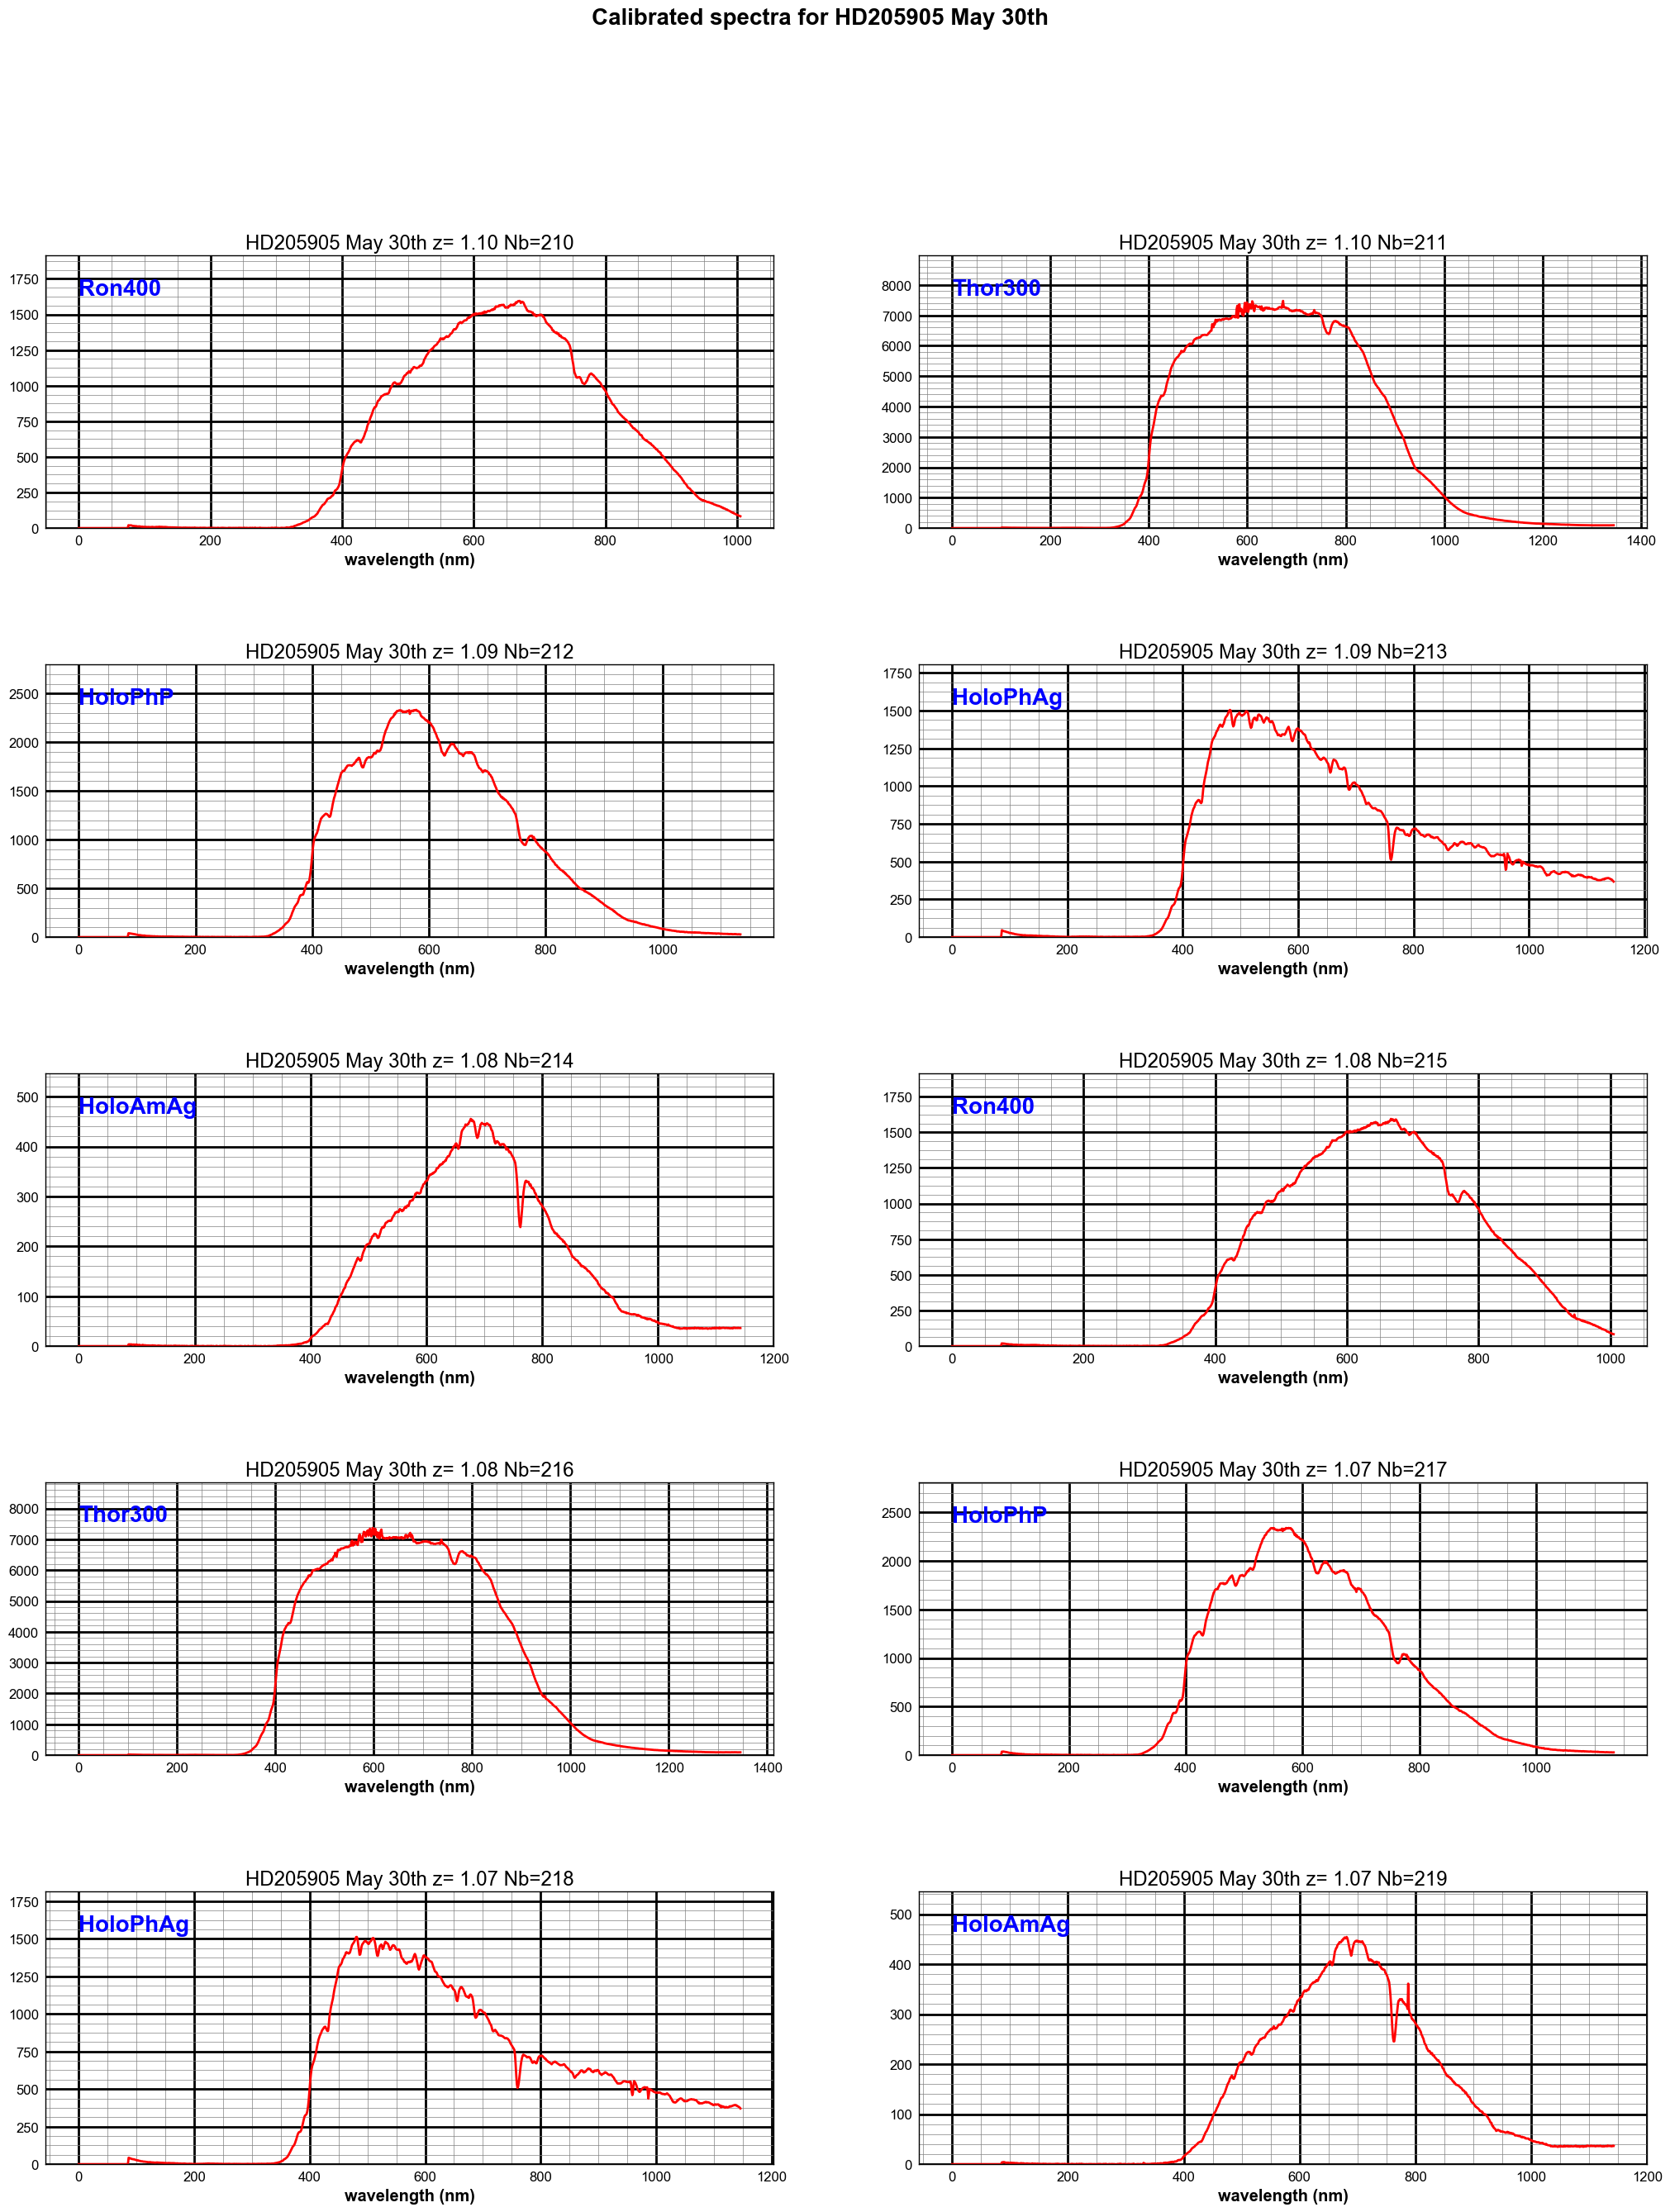

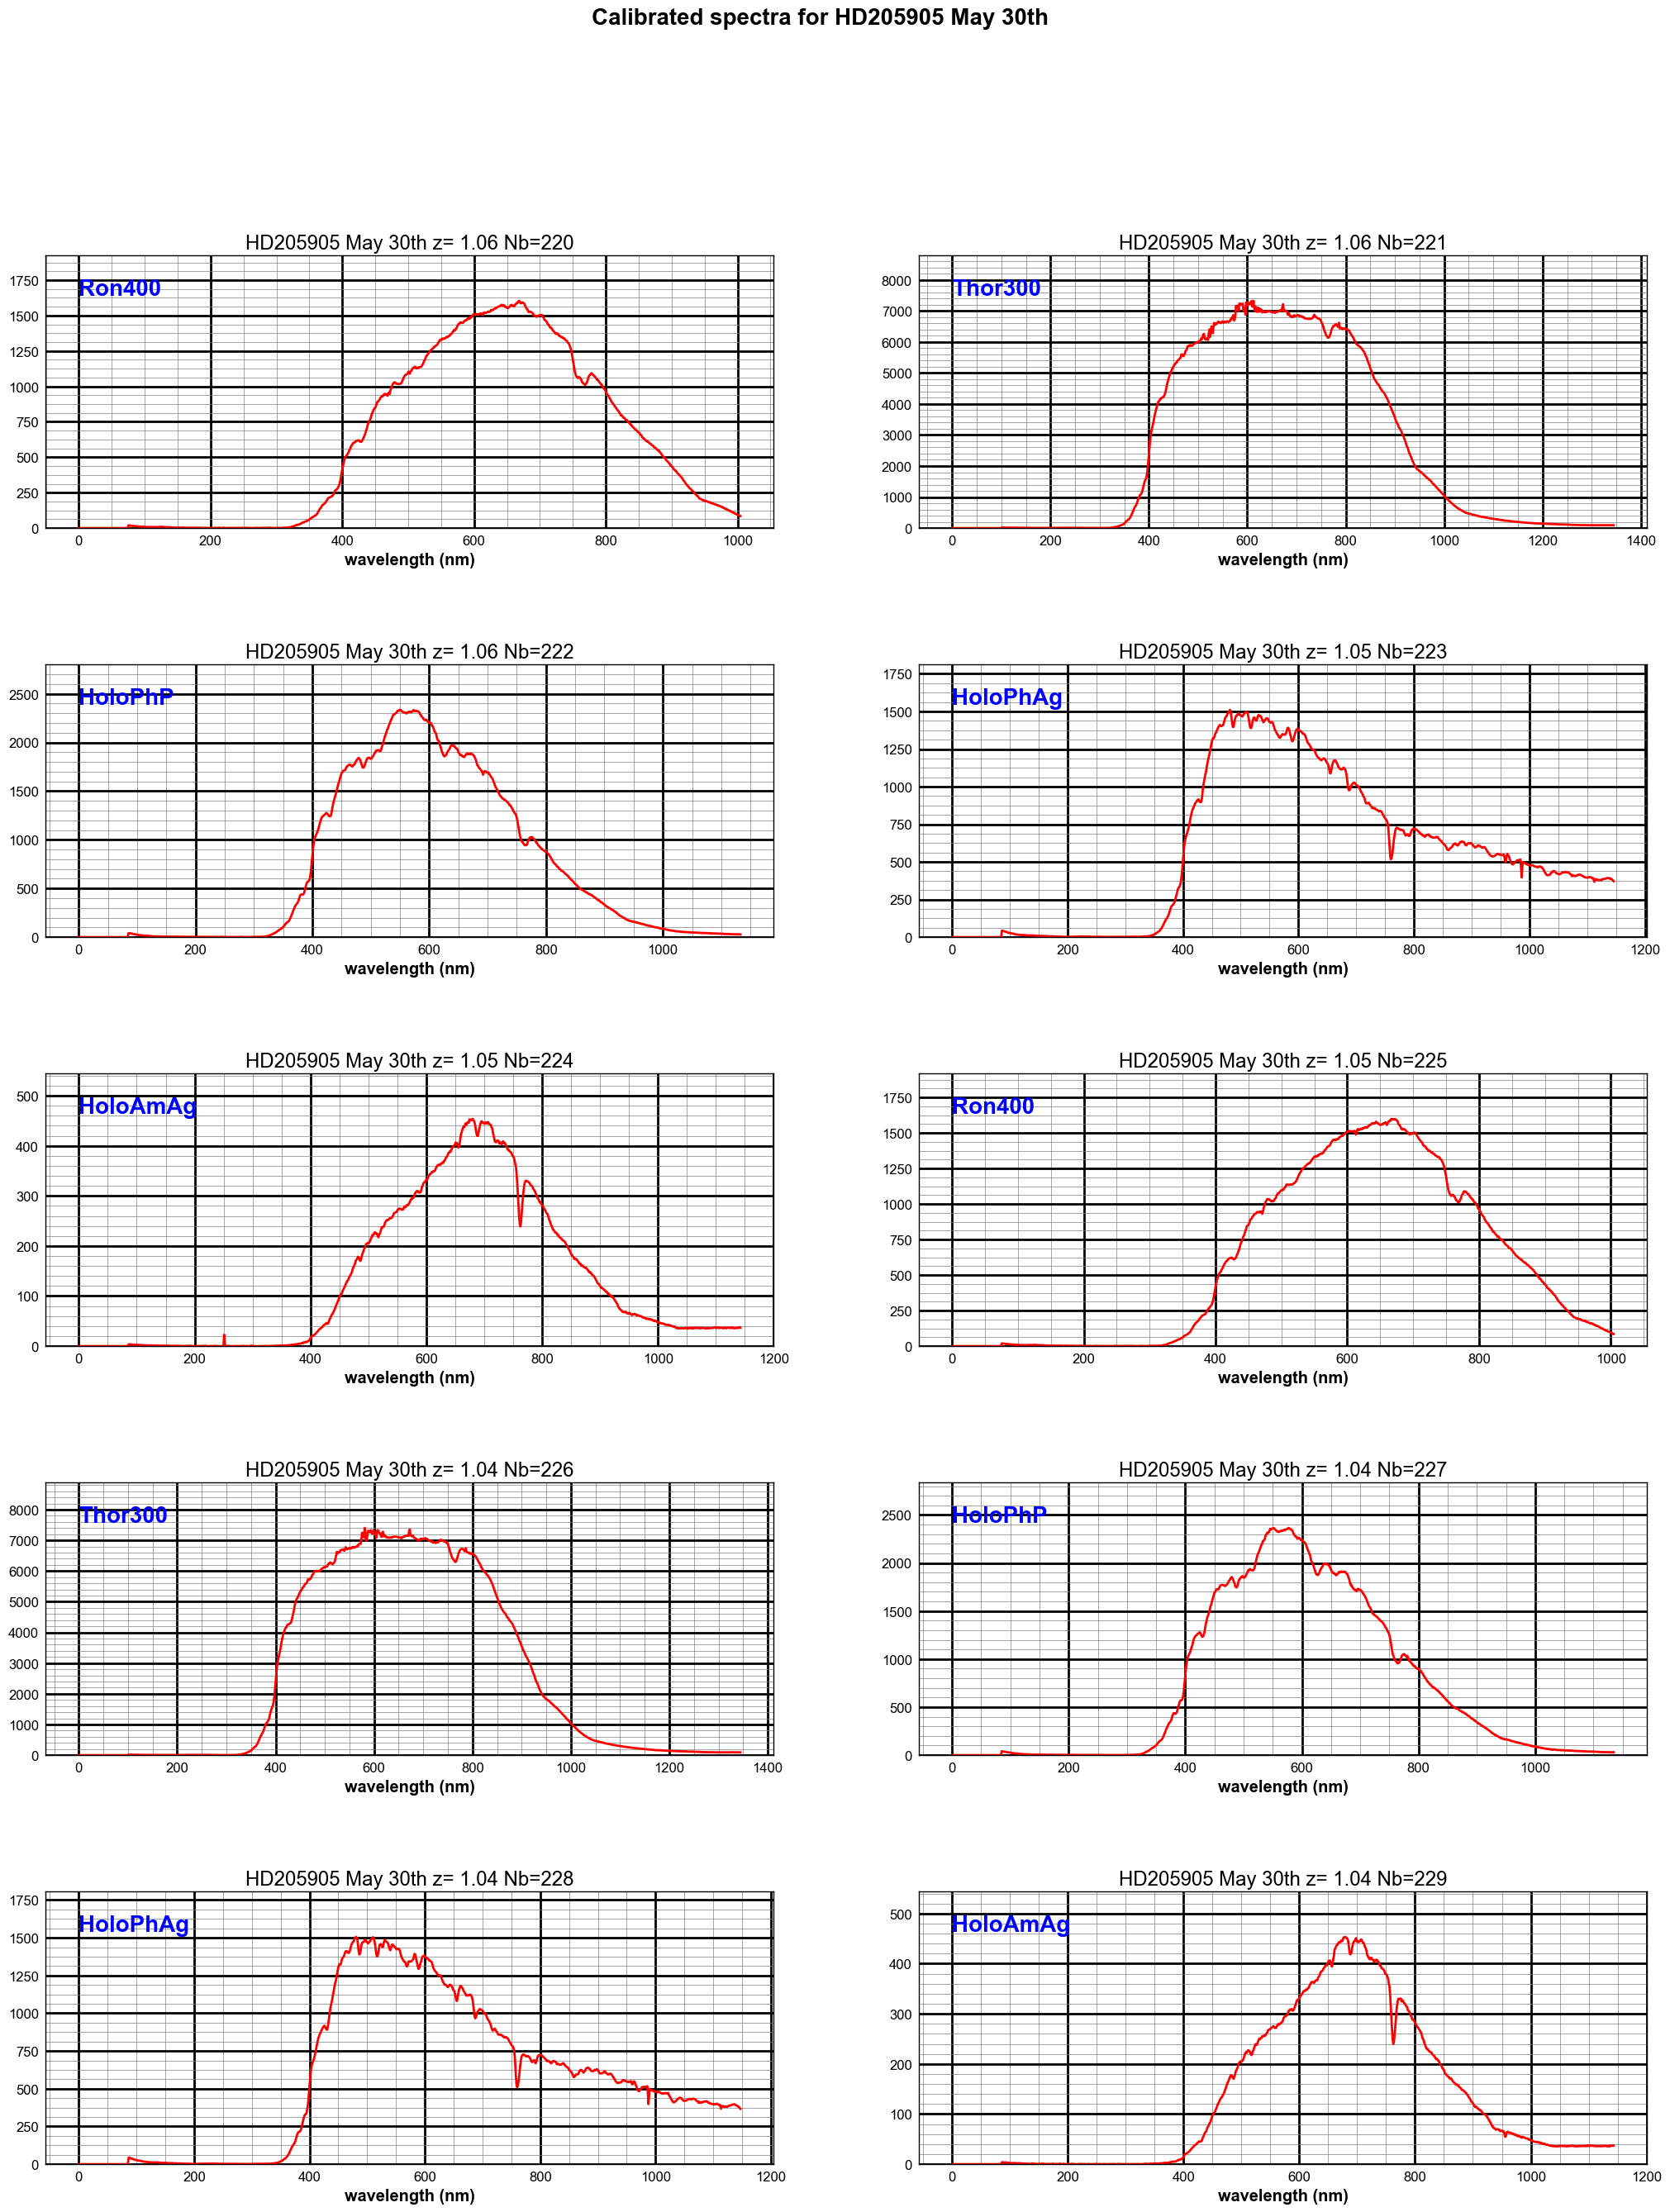

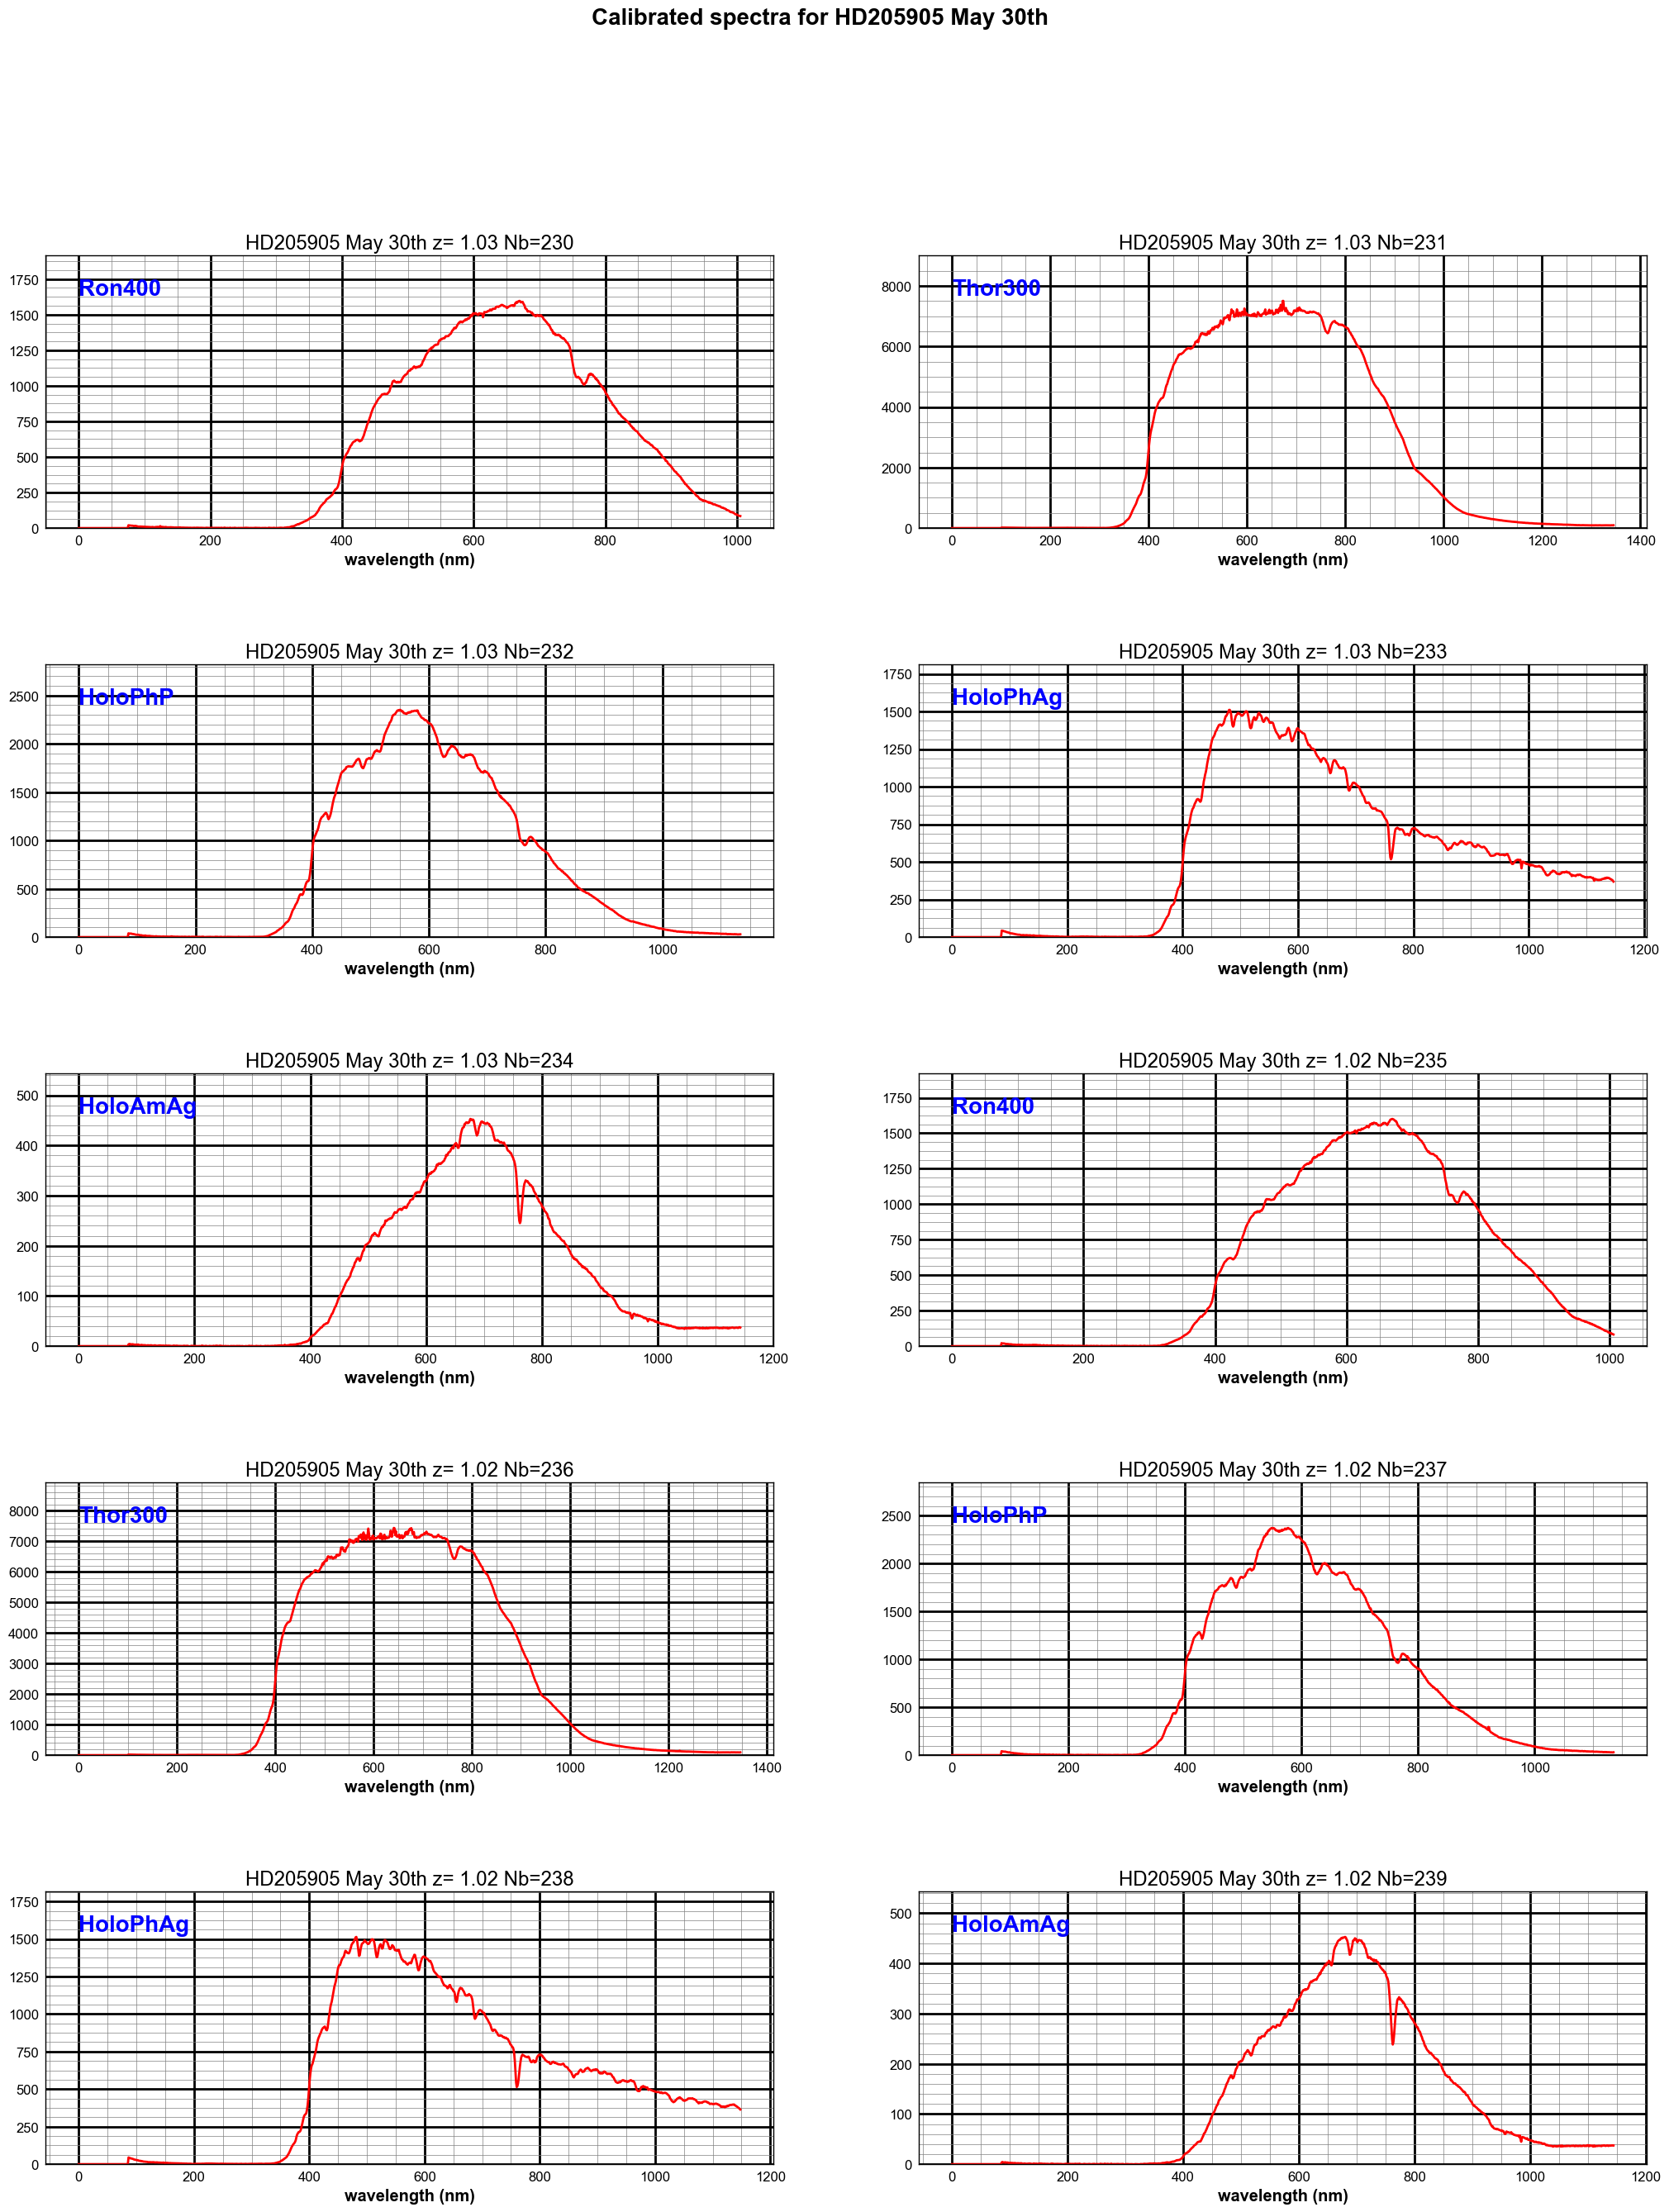

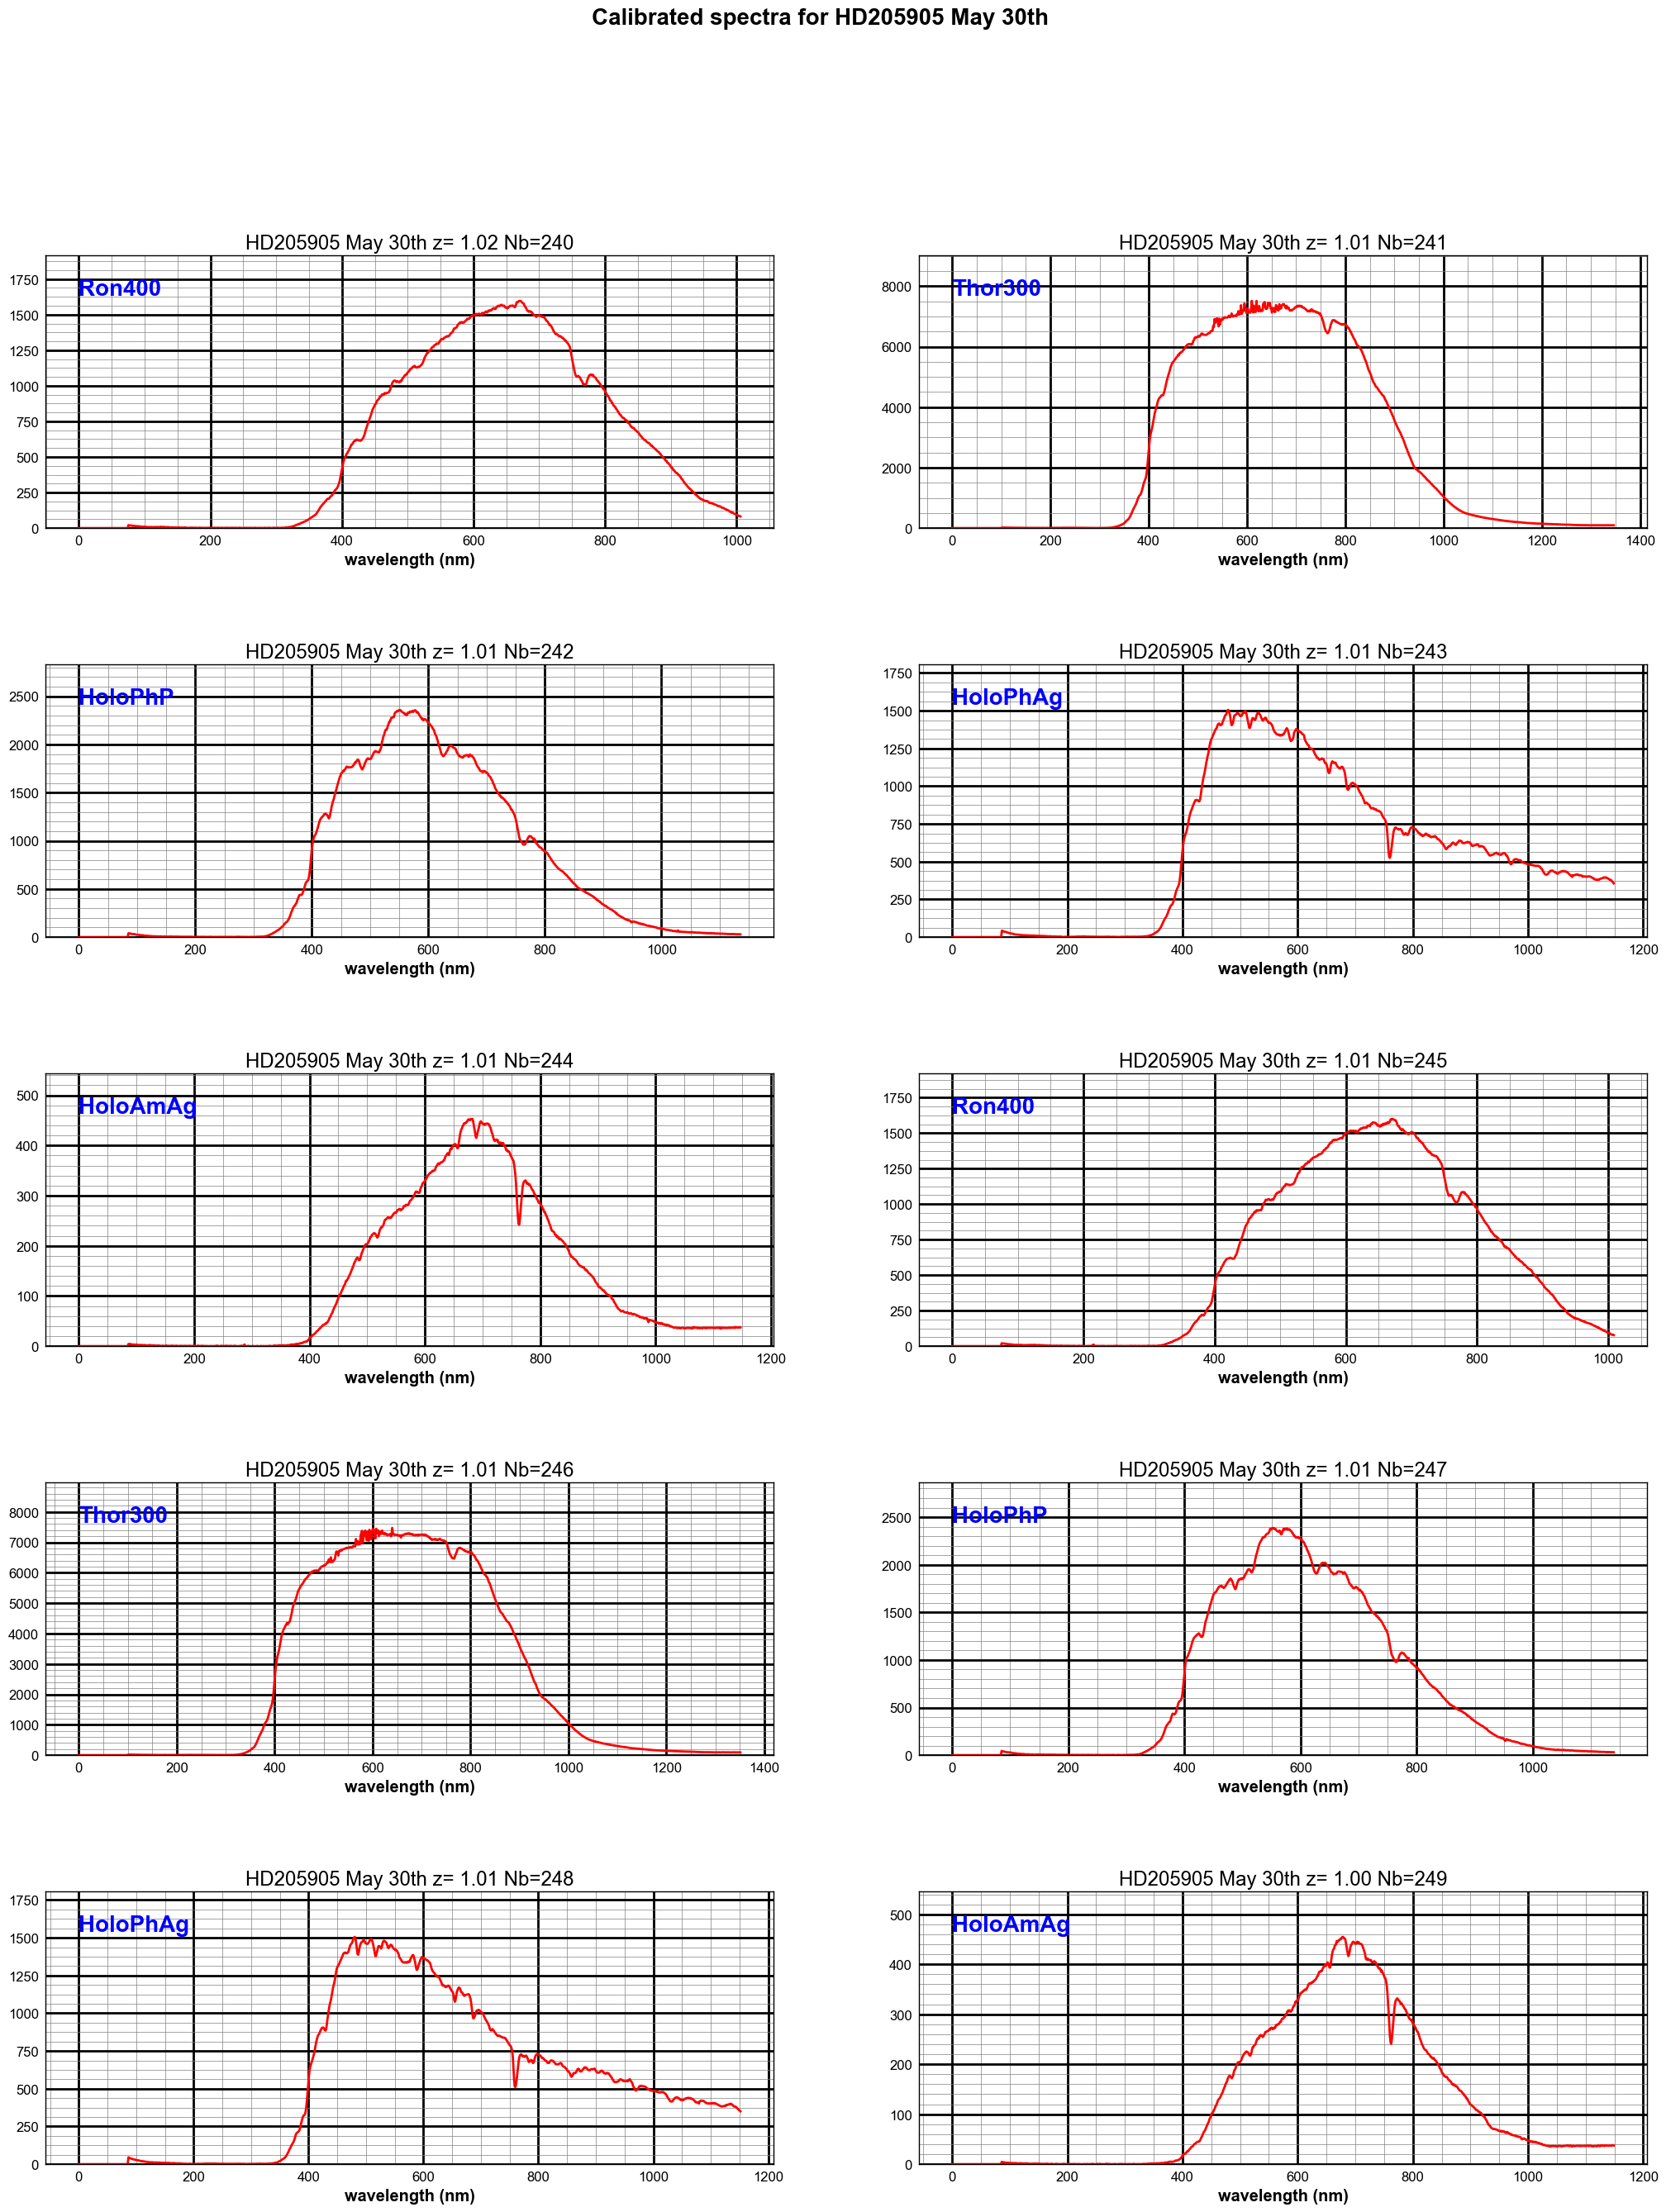

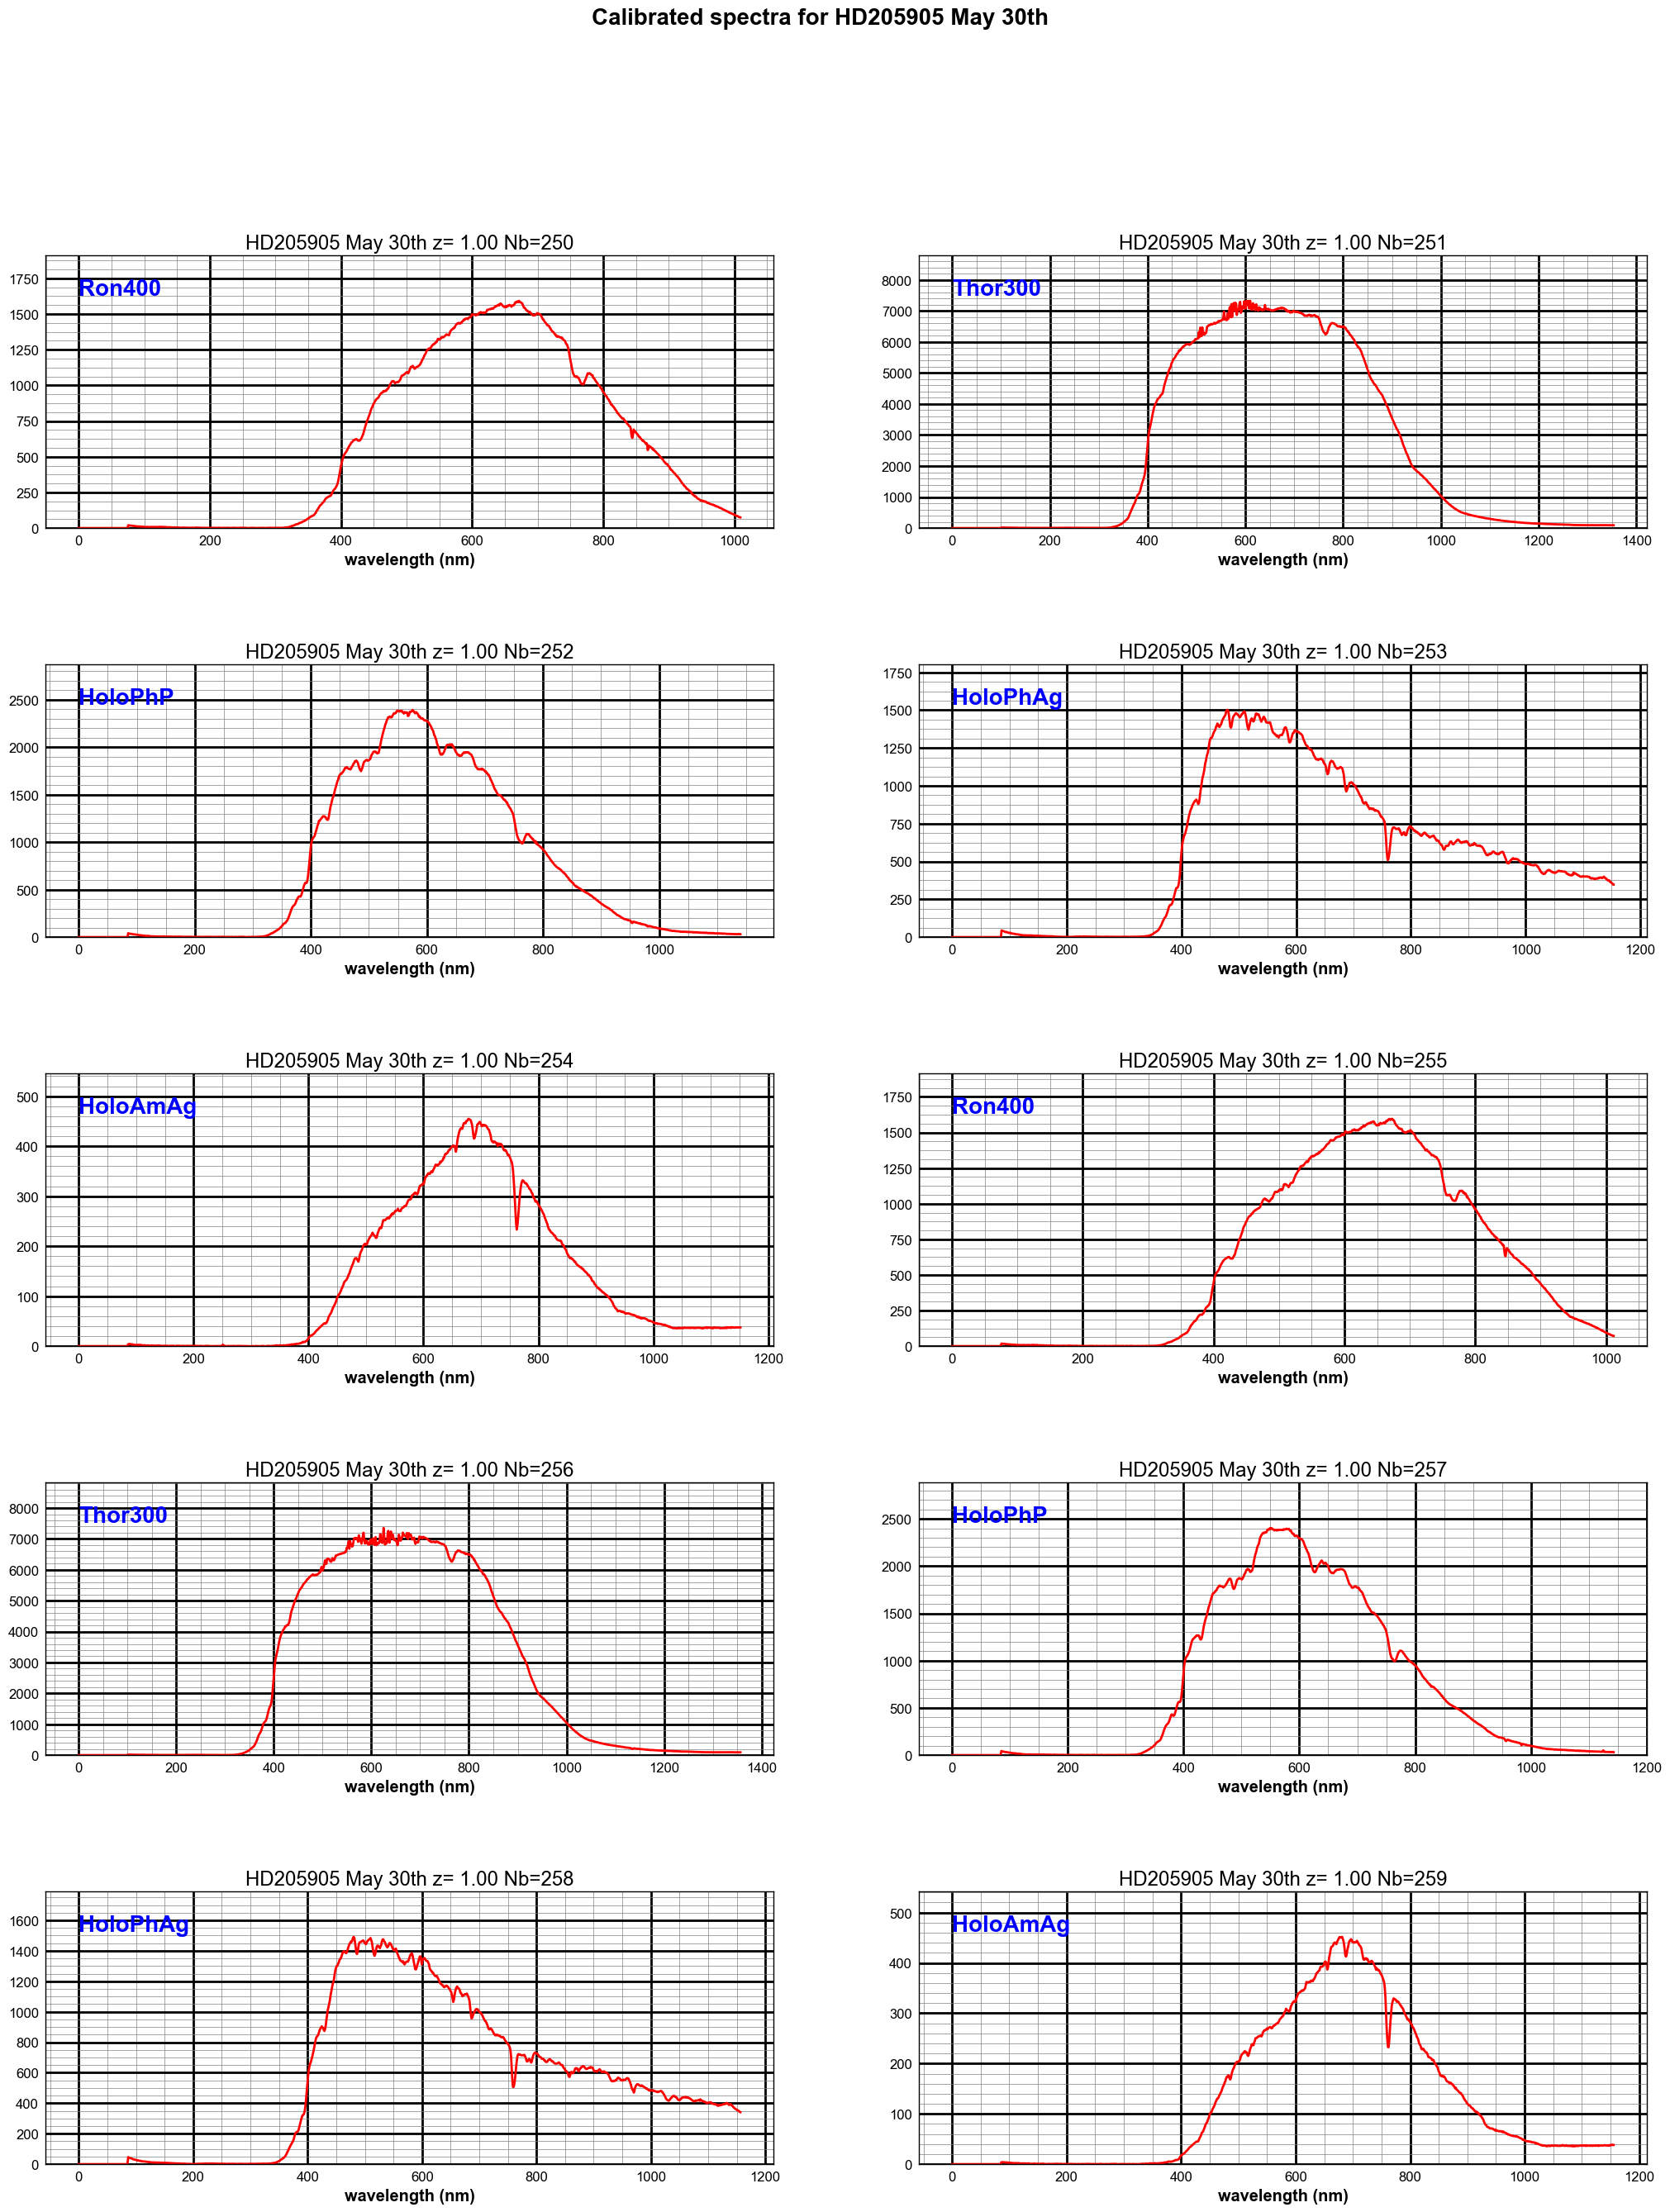

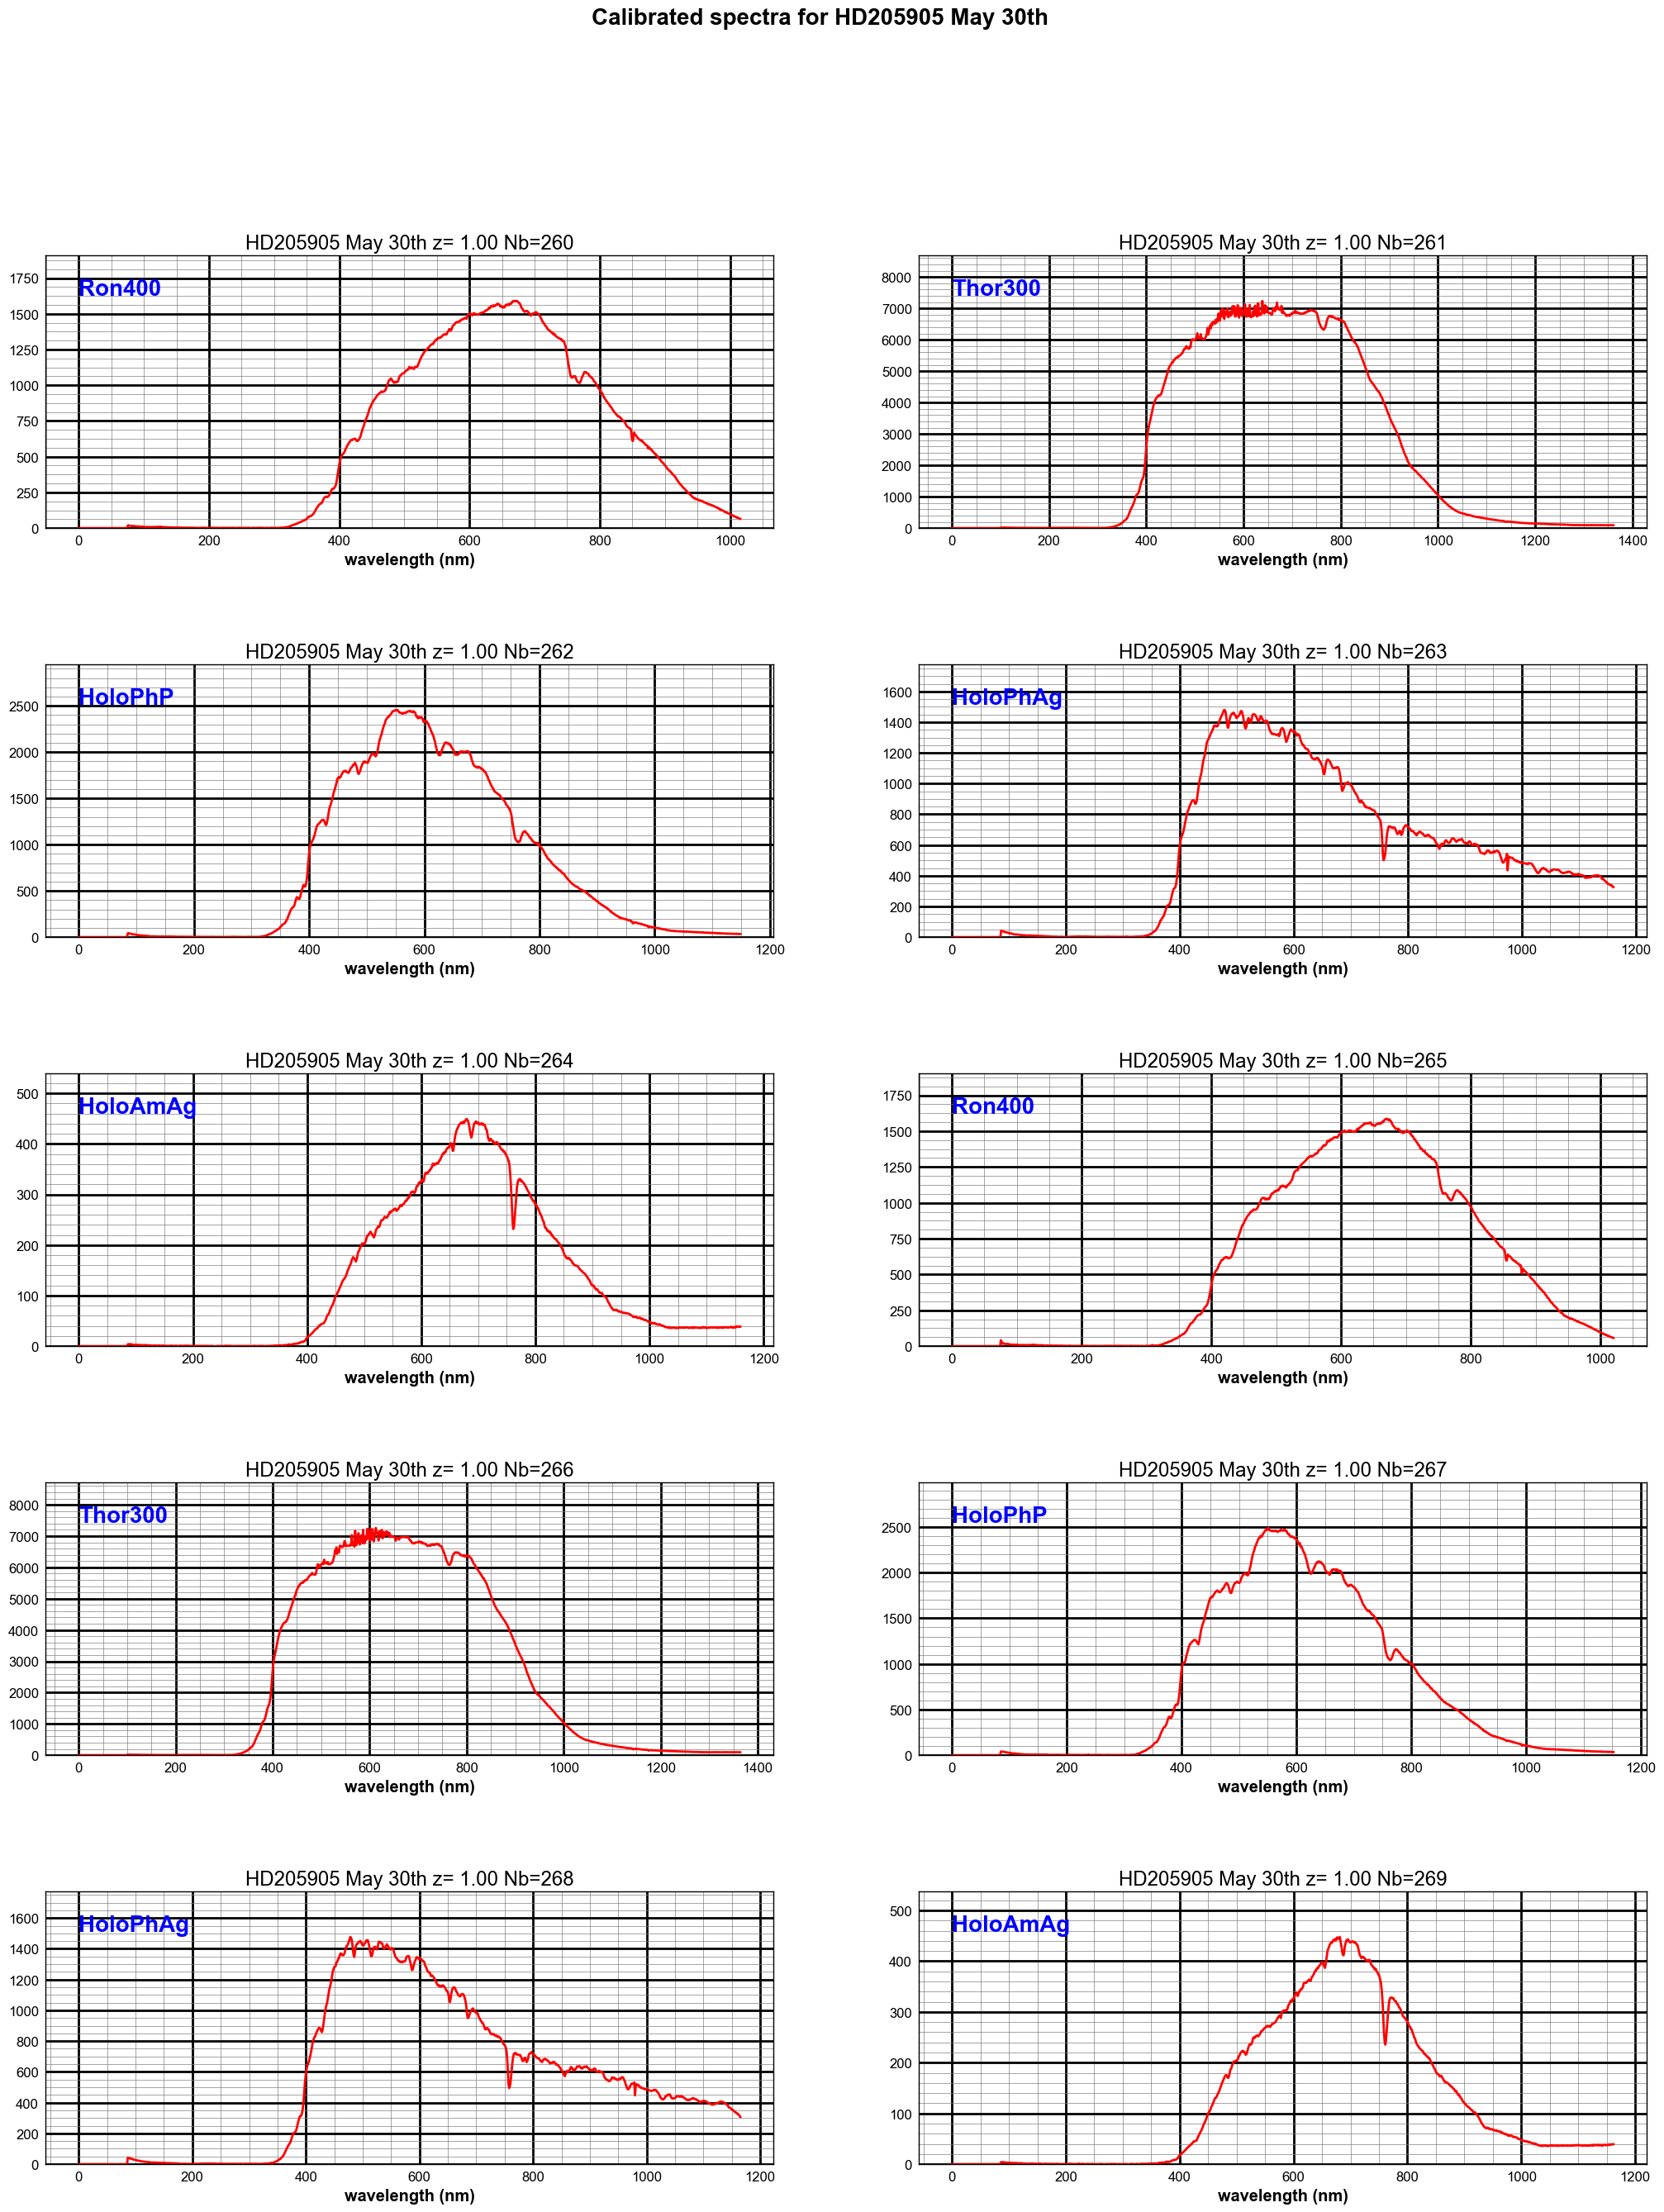

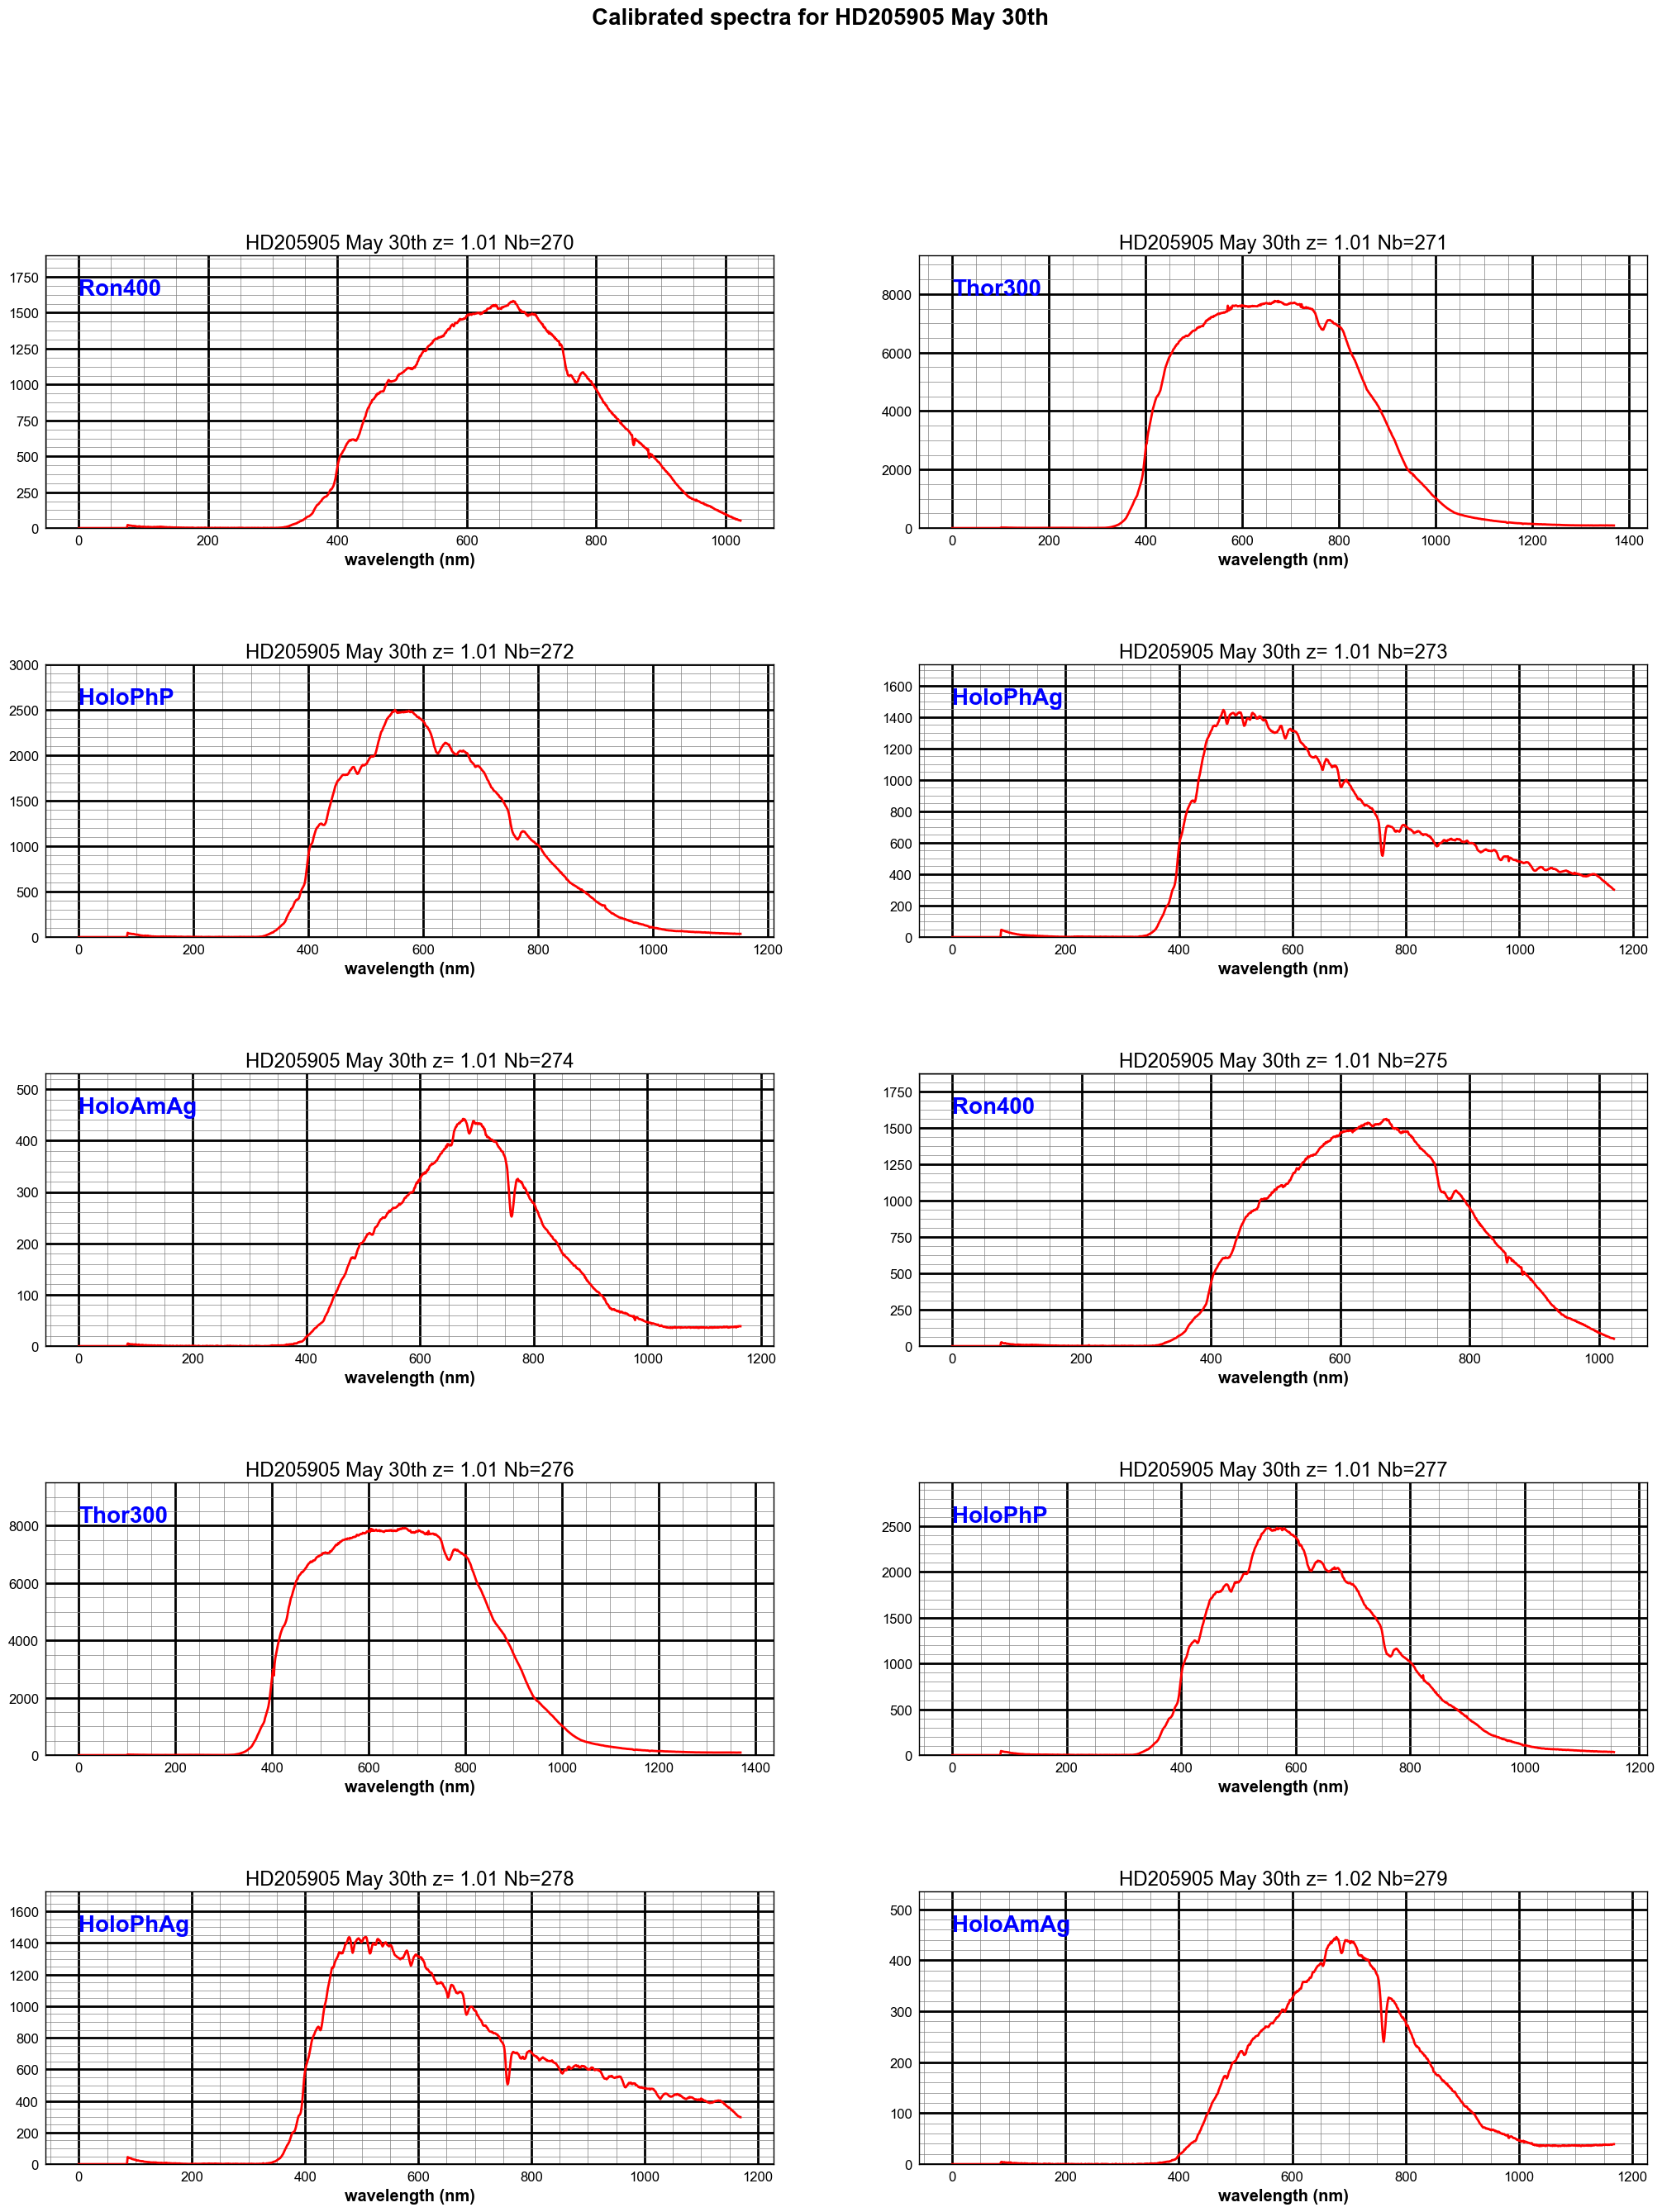

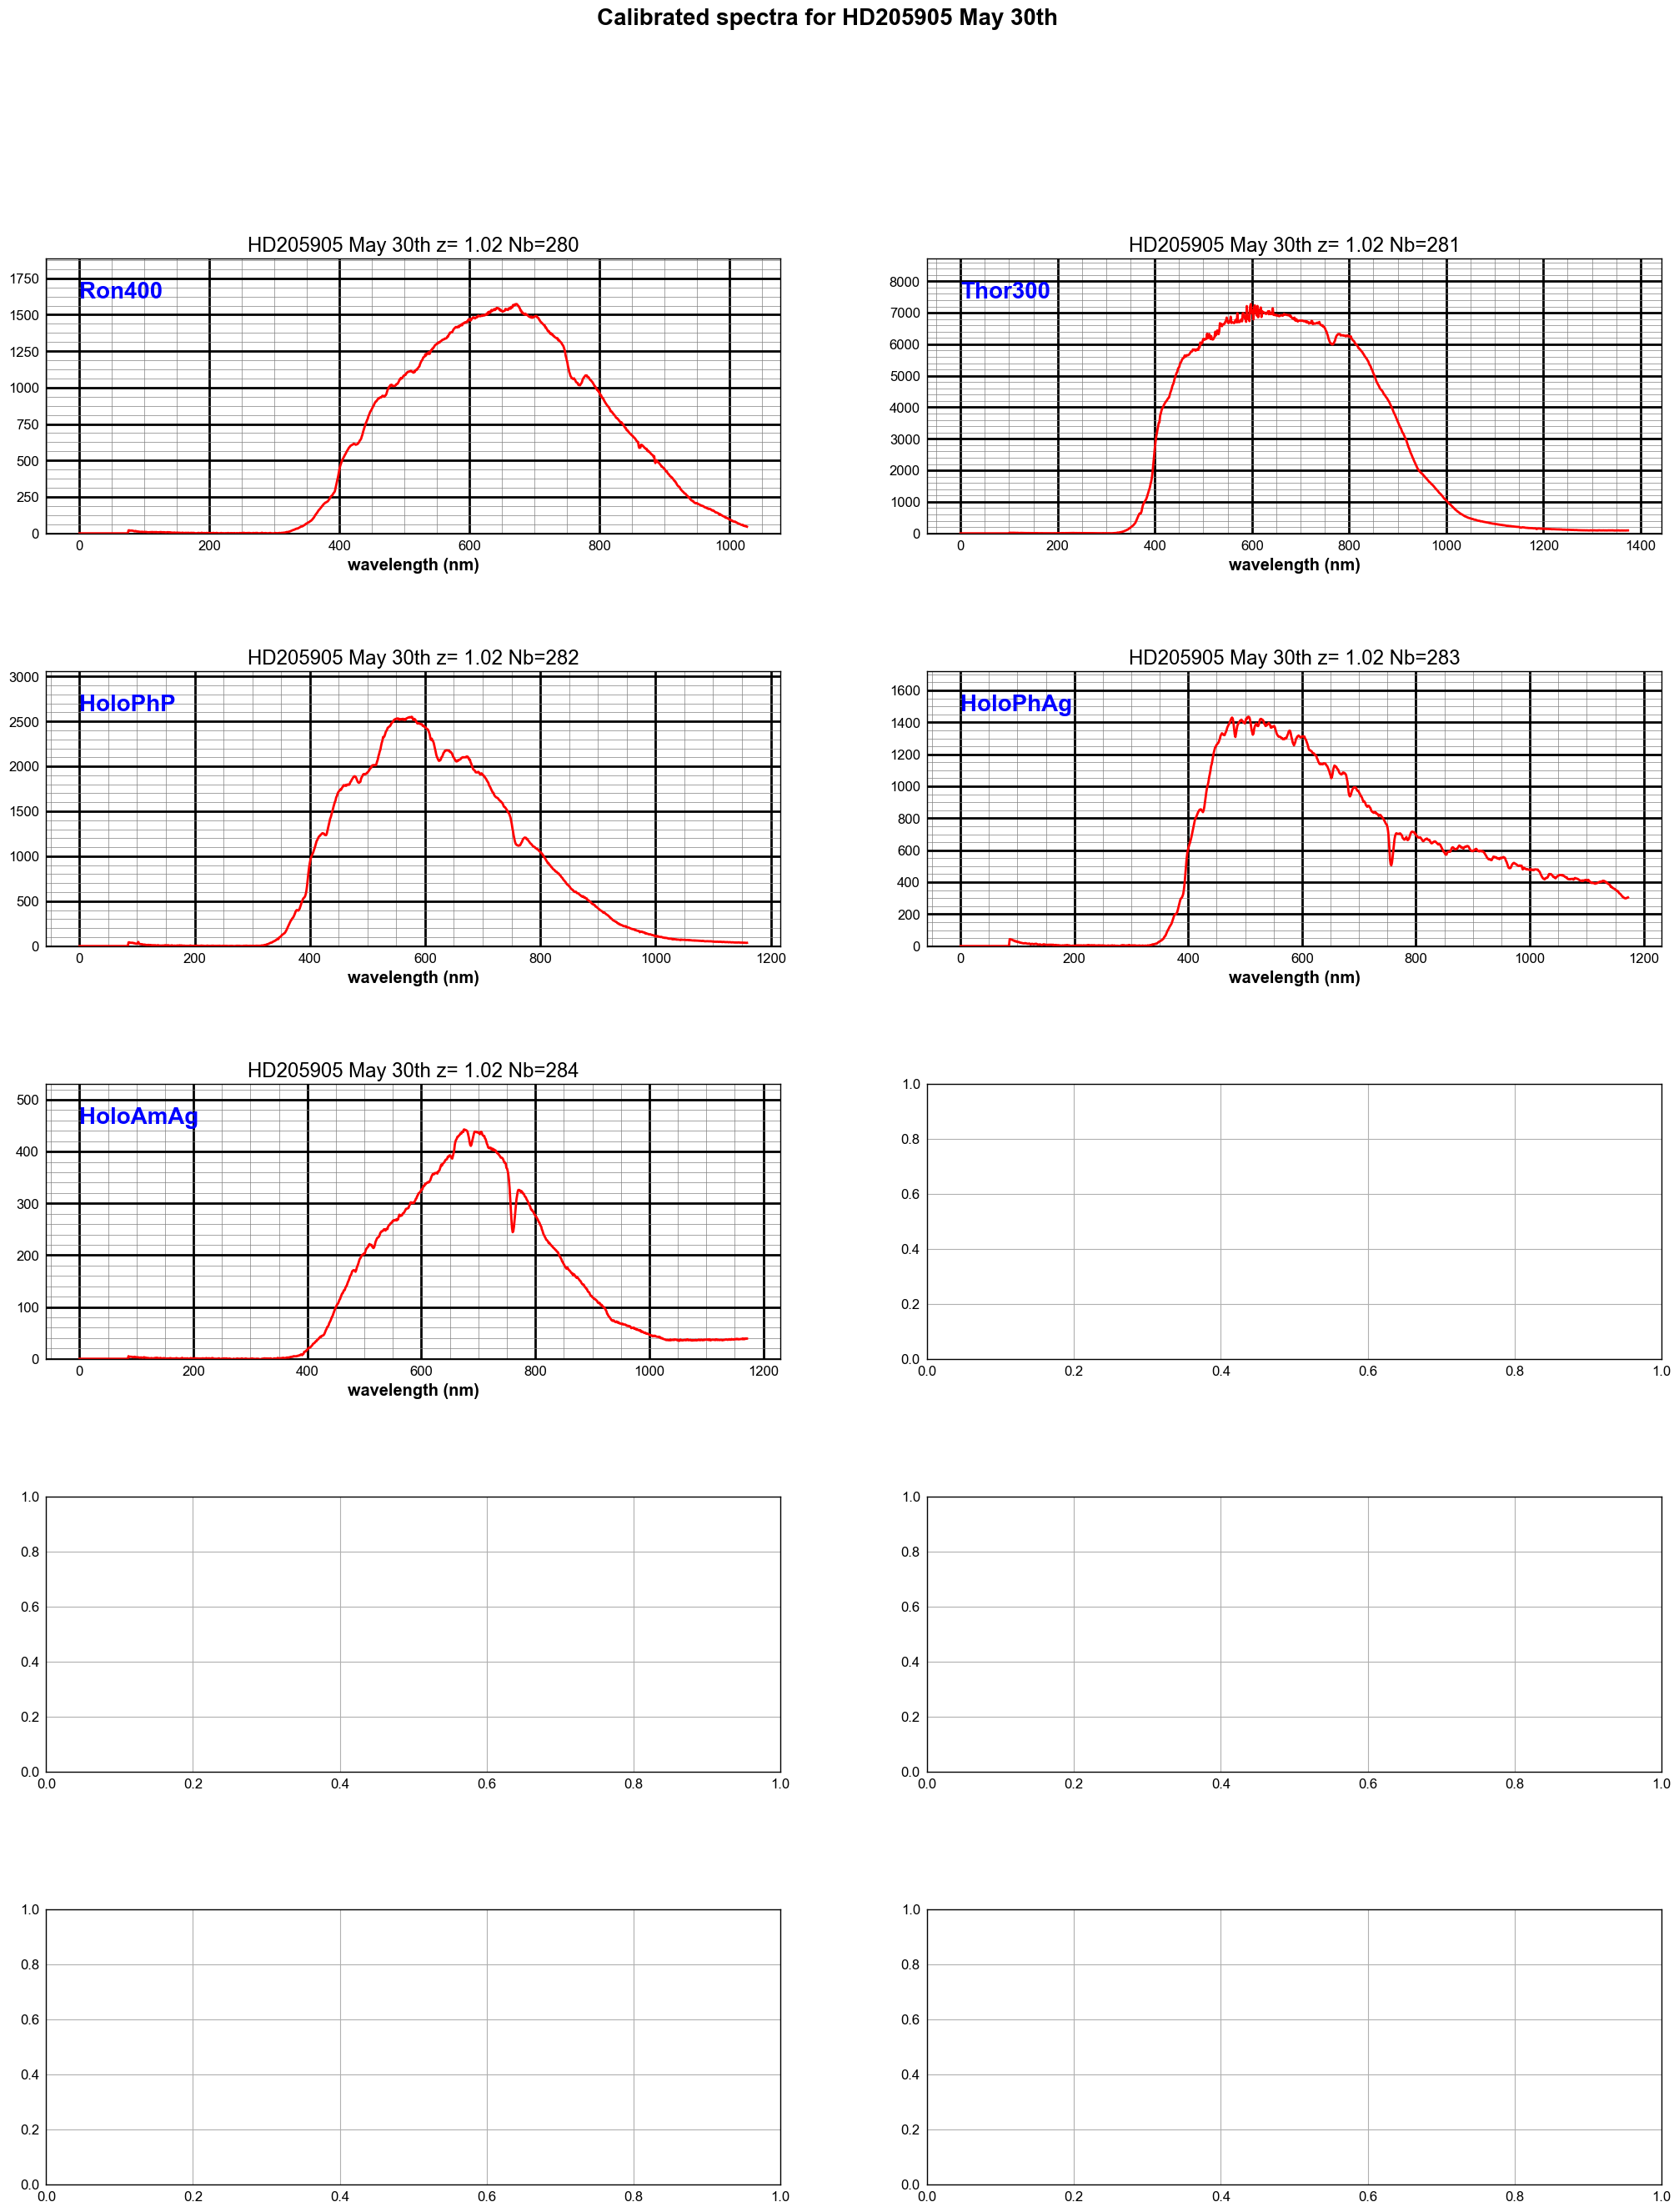

In [54]:
ShowSpectra(all_rightspectra_data,all_rightspectra_wl,all_titles,object_name,all_filt,dir_top_images)

In [55]:
wl_O2Aline=759.37      # Balmer Lines
wl_O2Bline=686.719
wl_Haline=656.281 
wl_Hbline=486.134
wl_Hgline=434.047 
wl_Hdline=410.175
wl_Heline=397.0

In [56]:
sel=0
thespectrum=all_rightspectra_data[sel]

In [57]:
def ShowOneSpectrum(sel):
    """
    ShowOneSpectrum
    ================
    """


    thespectrum=all_rightspectra_data[sel]


    thewl=all_rightspectra_wl[sel]
    ymin=thespectrum.min()
    ymax=thespectrum.max()*1.1

    fig, ax = plt.subplots(1, 1, figsize=(15,8))


    ax.plot(thewl,thespectrum,'b-',lw=2)

    max_y_to_plot=thespectrum[:].max()*1.2
    ax.set_ylim(0.,max_y_to_plot)
    ax.text(0.,max_y_to_plot*1.1/1.2, all_filt[sel],verticalalignment='top', horizontalalignment='left',color='blue',fontweight='bold', fontsize=20)

    ax.set_title(all_titles[sel])
    ax.get_xaxis().set_minor_locator(mpl.ticker.AutoMinorLocator())
    ax.get_yaxis().set_minor_locator(mpl.ticker.AutoMinorLocator())
    ax.grid(b=True, which='major', color='k', linewidth=2.0)
    ax.grid(b=True, which='minor', color='grey', linewidth=0.5)

    ax.plot([wl_O2Aline,wl_O2Aline],[ymin,ymax],'b-',label='$O_2(A)$',lw=1)
    ax.plot([wl_O2Bline,wl_O2Bline],[ymin,ymax],'b-',label='$O_2(B)$',lw=1)
    ax.plot([wl_Haline,wl_Haline],[ymin,ymax],'r-',label='$H_{alpha}$',lw=1)
    ax.plot([wl_Hbline,wl_Hbline],[ymin,ymax],'g-',label='$H_{beta}$',lw=1)
    ax.plot([wl_Hgline,wl_Hgline],[ymin,ymax],'c-',label='$H_{gamma}$',lw=1)
    ax.plot([wl_Hdline,wl_Hdline],[ymin,ymax],'k-',label='$H_{delta}$',lw=1)
    ax.plot([wl_Heline,wl_Heline],[ymin,ymax],'y-',label='$H_{delta}$',lw=1)

    ax.legend(loc='best',fontsize=20)
    ax.set_xlim(0,1100)
    ax.set_xlabel("$\lambda$ (nm)")
    
    figfilename=os.path.join(dir_top_images,'one_intput_calibrated_spectra.pdf')
    fig.savefig(figfilename)

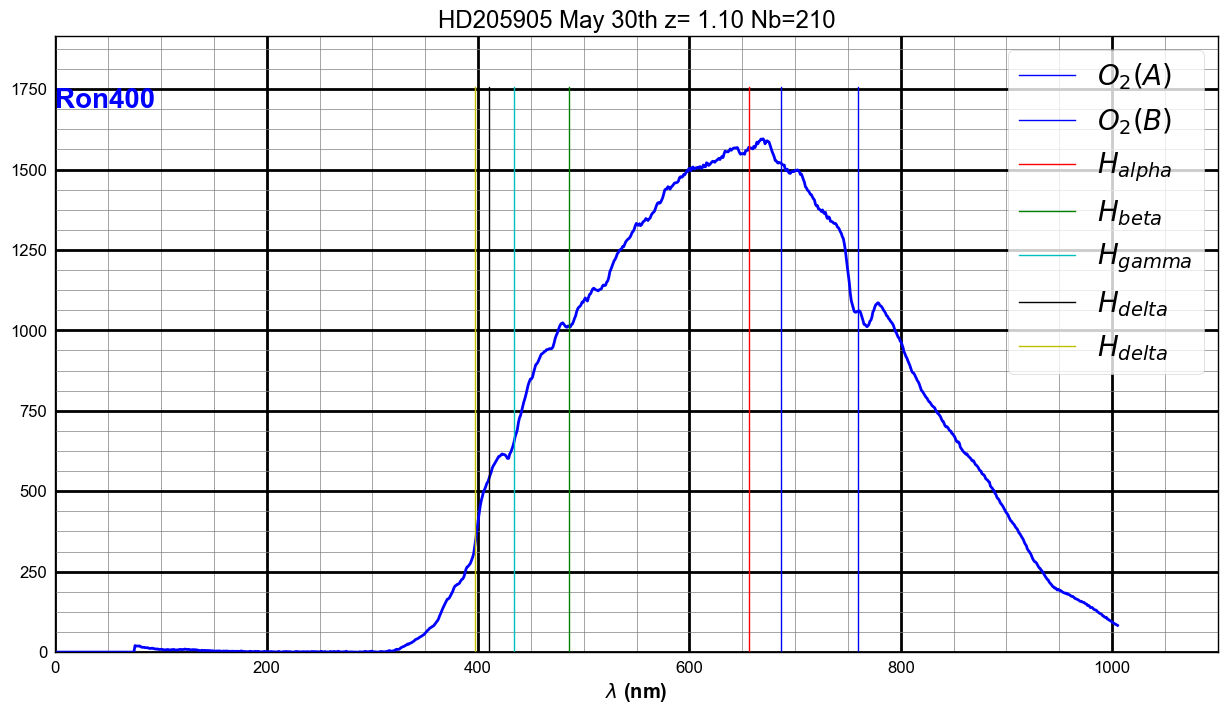

In [58]:
ShowOneSpectrum(0)

In [59]:
def ShowOneSpectrumNextFilt(sel):
    """
    ShowOneSpectrum
    ================
    """

    NBSPECTOPLOT=5
    
    the_spectra= []
    the_wl=[]
    the_max = []
    the_label= []
    
    for i in np.arange(NBSPECTOPLOT):

        the_spectrum=all_rightspectra_data[sel+i]
        thewl=all_rightspectra_wl[sel+i]
        theymin=the_spectrum.min()
        theymax=the_spectrum.max()
        thelabel=all_filt[sel+i]
        
        the_spectra.append(the_spectrum)
        the_wl.append(thewl)
        the_max.append(theymax)
        the_label.append(thelabel)

        
    fig, ax = plt.subplots(1, 1, figsize=(15,8))
    for i in np.arange(NBSPECTOPLOT):        
        ax.plot(the_wl[i],the_spectra[i],lw=3,label=the_label[i])

 
        
    max_y_to_plot=(np.array(the_max)).max()
    ymin=0
    ymax=max_y_to_plot
    ax.set_ylim(0.,max_y_to_plot)
    
    ax.set_title(all_titles[sel])
    ax.get_xaxis().set_minor_locator(mpl.ticker.AutoMinorLocator())
    ax.get_yaxis().set_minor_locator(mpl.ticker.AutoMinorLocator())
    ax.grid(b=True, which='major', color='k', linewidth=2.0)
    ax.grid(b=True, which='minor', color='grey', linewidth=0.5)

    ax.plot([wl_O2Aline,wl_O2Aline],[ymin,ymax],'b:',label='$O_2(A)$',lw=3)
    ax.plot([wl_O2Bline,wl_O2Bline],[ymin,ymax],'b:',label='$O_2(B)$',lw=3)
    ax.plot([wl_Haline,wl_Haline],[ymin,ymax],'r:',label='$H_{alpha}$',lw=3)
    ax.plot([wl_Hbline,wl_Hbline],[ymin,ymax],'g:',label='$H_{beta}$',lw=3)
    ax.plot([wl_Hgline,wl_Hgline],[ymin,ymax],'c:',label='$H_{gamma}$',lw=3)
    ax.plot([wl_Hdline,wl_Hdline],[ymin,ymax],'k:',label='$H_{delta}$',lw=3)
    ax.plot([wl_Heline,wl_Heline],[ymin,ymax],'y:',label='$H_{delta}$',lw=3)

    ax.legend(loc='best',fontsize=20)
    ax.set_xlim(0,1100)
    ax.set_xlabel("$\lambda$ (nm)")
    
    figfilename=os.path.join(dir_top_images,'five_intput_calibrated_spectra.pdf')
    fig.savefig(figfilename)

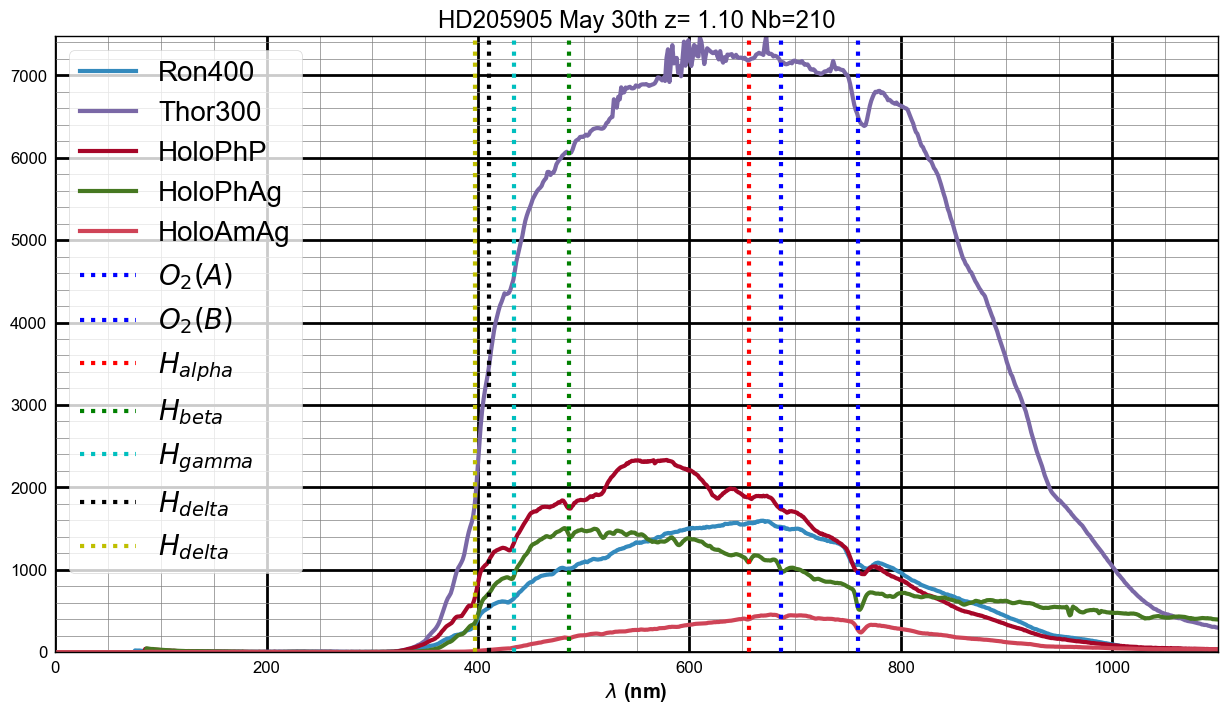

In [60]:
ShowOneSpectrumNextFilt(0)

In [61]:
all_dt= [ parser.parse(all_dates[i]) for i in range(NDATA)]

In [62]:
print all_airmass

[1.101, 1.097, 1.094, 1.09, 1.085, 1.08, 1.077, 1.074, 1.071, 1.067, 1.063, 1.06, 1.057, 1.055, 1.051, 1.048, 1.045, 1.043, 1.041, 1.038, 1.035, 1.033, 1.031, 1.029, 1.027, 1.024, 1.022, 1.021, 1.02, 1.017, 1.016, 1.014, 1.013, 1.012, 1.01, 1.009, 1.008, 1.007, 1.007, 1.005, 1.004, 1.004, 1.003, 1.003, 1.002, 1.002, 1.002, 1.001, 1.001, 1.001, 1.001, 1.001, 1.001, 1.002, 1.002, 1.002, 1.003, 1.003, 1.004, 1.005, 1.006, 1.006, 1.007, 1.008, 1.009, 1.011, 1.012, 1.013, 1.014, 1.016, 1.018, 1.019, 1.021, 1.022, 1.024]


In [63]:
print all_dt

[datetime.datetime(2017, 5, 31, 7, 54, 38, 806000), datetime.datetime(2017, 5, 31, 7, 56, 31, 293000), datetime.datetime(2017, 5, 31, 7, 58, 23, 653000), datetime.datetime(2017, 5, 31, 8, 0, 16, 53000), datetime.datetime(2017, 5, 31, 8, 3, 8, 495000), datetime.datetime(2017, 5, 31, 8, 6, 0, 847000), datetime.datetime(2017, 5, 31, 8, 7, 53, 254000), datetime.datetime(2017, 5, 31, 8, 9, 45, 655000), datetime.datetime(2017, 5, 31, 8, 11, 37, 854000), datetime.datetime(2017, 5, 31, 8, 14, 30, 301000), datetime.datetime(2017, 5, 31, 8, 17, 22, 698000), datetime.datetime(2017, 5, 31, 8, 19, 15, 101000), datetime.datetime(2017, 5, 31, 8, 21, 7, 405000), datetime.datetime(2017, 5, 31, 8, 22, 59, 809000), datetime.datetime(2017, 5, 31, 8, 25, 52, 205000), datetime.datetime(2017, 5, 31, 8, 28, 44, 549000), datetime.datetime(2017, 5, 31, 8, 30, 37, 7000), datetime.datetime(2017, 5, 31, 8, 32, 29, 446000), datetime.datetime(2017, 5, 31, 8, 34, 21, 908000), datetime.datetime(2017, 5, 31, 8, 37, 14,

In [64]:
import matplotlib.dates as mdates

years = mdates.YearLocator()   # every year
months = mdates.MonthLocator()  # every month
mins=mdates.MinuteLocator()
days=mdates.DayLocator()  # every day
hour=mdates.HourLocator()  # every day
yearsFmt = mdates.DateFormatter('%Y')


In [65]:
all_airmass=np.array(all_airmass)

In [66]:
np.where(all_airmass==all_airmass.min())[0][0]

47

In [67]:
def CompareSpectrumProfile(wl,spectra,all_titles,object_name,all_filt,dir_top_img,grating_name):
    """
    CompareSpectrumProfile
    =====================
    
    """
    shortfilename='CompareSpec_'+grating_name+'.pdf'
    title="Compare spectra of {} with disperser {}".format(object_name,grating_name)
    figfilename=os.path.join(dir_top_img,shortfilename)
    pp = PdfPages(figfilename) # create a pdf file
    
    
    f, axarr = plt.subplots(1,1,figsize=(25,15))
    f.suptitle(title,size=20)
    
    NBSPEC=len(spectra)
    
    min_z=min(all_airmass)
    max_z=max(all_airmass)
    
    maxim_y_to_plot= []

    texte='airmass : {} - {} '.format(min_z,max_z)
    
    for index in np.arange(0,NBSPEC):
                
        if re.search(grating_name,all_filt[index]):
            axarr.plot(wl[index],spectra[index],'-')
            maxim_y_to_plot.append(spectra[index].max())
    
    max_y_to_plot=max(maxim_y_to_plot)
    axarr.set_ylim(0,max_y_to_plot)
    axarr.text(0.,max_y_to_plot*0.9, texte ,verticalalignment='top', horizontalalignment='left',color='blue',fontweight='bold', fontsize=20)
    axarr.grid(True)
    
    axarr.get_xaxis().set_minor_locator(mpl.ticker.AutoMinorLocator())
    axarr.get_yaxis().set_minor_locator(mpl.ticker.AutoMinorLocator())
    axarr.grid(b=True, which='major', color='k', linewidth=2.0)
    axarr.grid(b=True, which='minor', color='grey', linewidth=0.5)

    
    
    axarr.set_xlabel("wavelength (nm)")
    
        
    f.savefig(pp, format='pdf')
    f.show()
    
    pp.close()     
    

In [68]:
def CleanSpectrumProfile(wl,spectra,all_titles,object_name,all_filt,dir_top_img,grating_name,wl_cut):
    """
    CleanSpectrumProfile
    =====================
    
    """
    shortfilename='CleanSpec_'+grating_name+'.pdf'
    title="Compare spectra of {} with disperser {}".format(object_name,grating_name)
    figfilename=os.path.join(dir_top_img,shortfilename)
    pp = PdfPages(figfilename) # create a pdf file
    
    
    f, axarr = plt.subplots(1,1,figsize=(25,15))
    f.suptitle(title,size=20)
    
    
    indexes_to_remove=[]
    
    NBSPEC=len(spectra)
    
    min_z=min(all_airmass)
    max_z=max(all_airmass)
    
    maxim_y_to_plot= []

    texte='airmass : {} - {} '.format(min_z,max_z)
    
    for index in np.arange(0,NBSPEC):
        
        indexes_to_remove_this_spectrum=[]
        
        # slect this spectrum if it has the correct filter
        if re.search(grating_name,all_filt[index]):
            axarr.plot(wl[index],spectra[index],'-')
            maxim_y_to_plot.append(spectra[index].max())
            
            # loop on wl bands to remove
            for band in wl_cut:
                
                axarr.plot([band[0],band[0]], [0,spectra[index].max()],'r-',lw=2)
                axarr.plot([band[1],band[1]], [0,spectra[index].max()],'r-',lw=2)
                #axarr.plot([400.,0], [400.,300.],'b-',lw=2)
                indexes_in_band=np.where(np.logical_and(wl[index]>=band[0],wl[index]<=band[1]))[0]
                for ind in indexes_in_band:
                    indexes_to_remove_this_spectrum.append(ind)
            
            indexes_to_remove.append(indexes_to_remove_this_spectrum)    
    
    max_y_to_plot=max(maxim_y_to_plot)
    axarr.set_ylim(0,max_y_to_plot)
    axarr.text(0.,max_y_to_plot*0.9, texte ,verticalalignment='top', horizontalalignment='left',color='blue',fontweight='bold', fontsize=20)
    axarr.grid(True)
    

    
    axarr.get_xaxis().set_minor_locator(mpl.ticker.AutoMinorLocator())
    axarr.get_yaxis().set_minor_locator(mpl.ticker.AutoMinorLocator())
    axarr.grid(b=True, which='major', color='k', linewidth=2.0)
    axarr.grid(b=True, which='minor', color='grey', linewidth=0.5)

    
    
    axarr.set_xlabel("wavelength (nm)")
    
        
    f.savefig(pp, format='pdf')
    f.show()
    
    pp.close()     
    
    return indexes_to_remove

### Plot all spectra superimposed

In [69]:
ListOfDisperserNames=['Ron400', 'Thor300', 'HoloPhP', 'HoloPhAg', 'HoloAmAg']

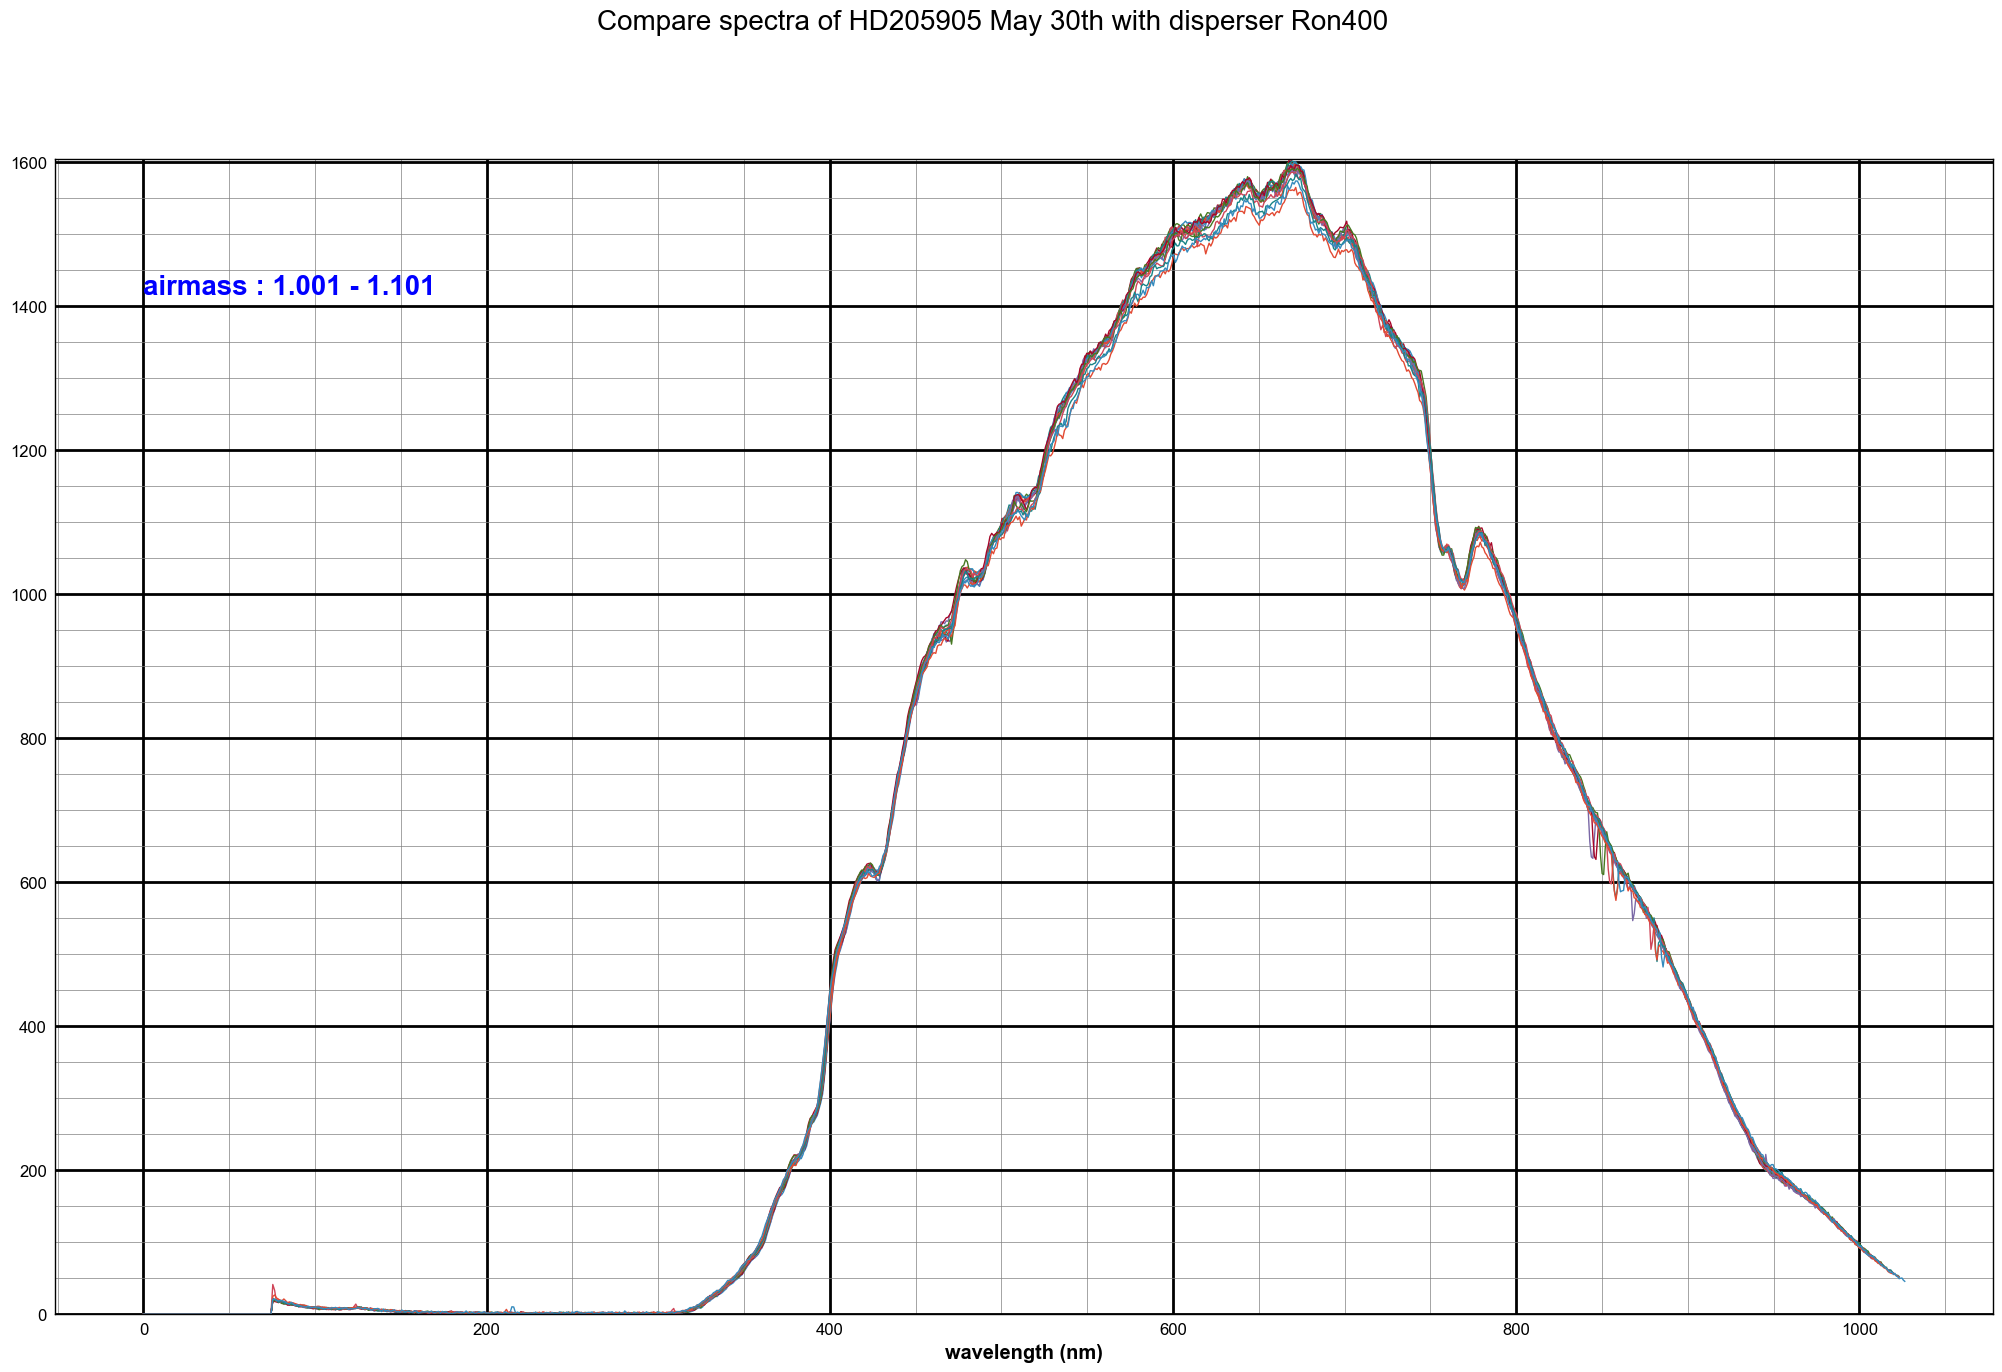

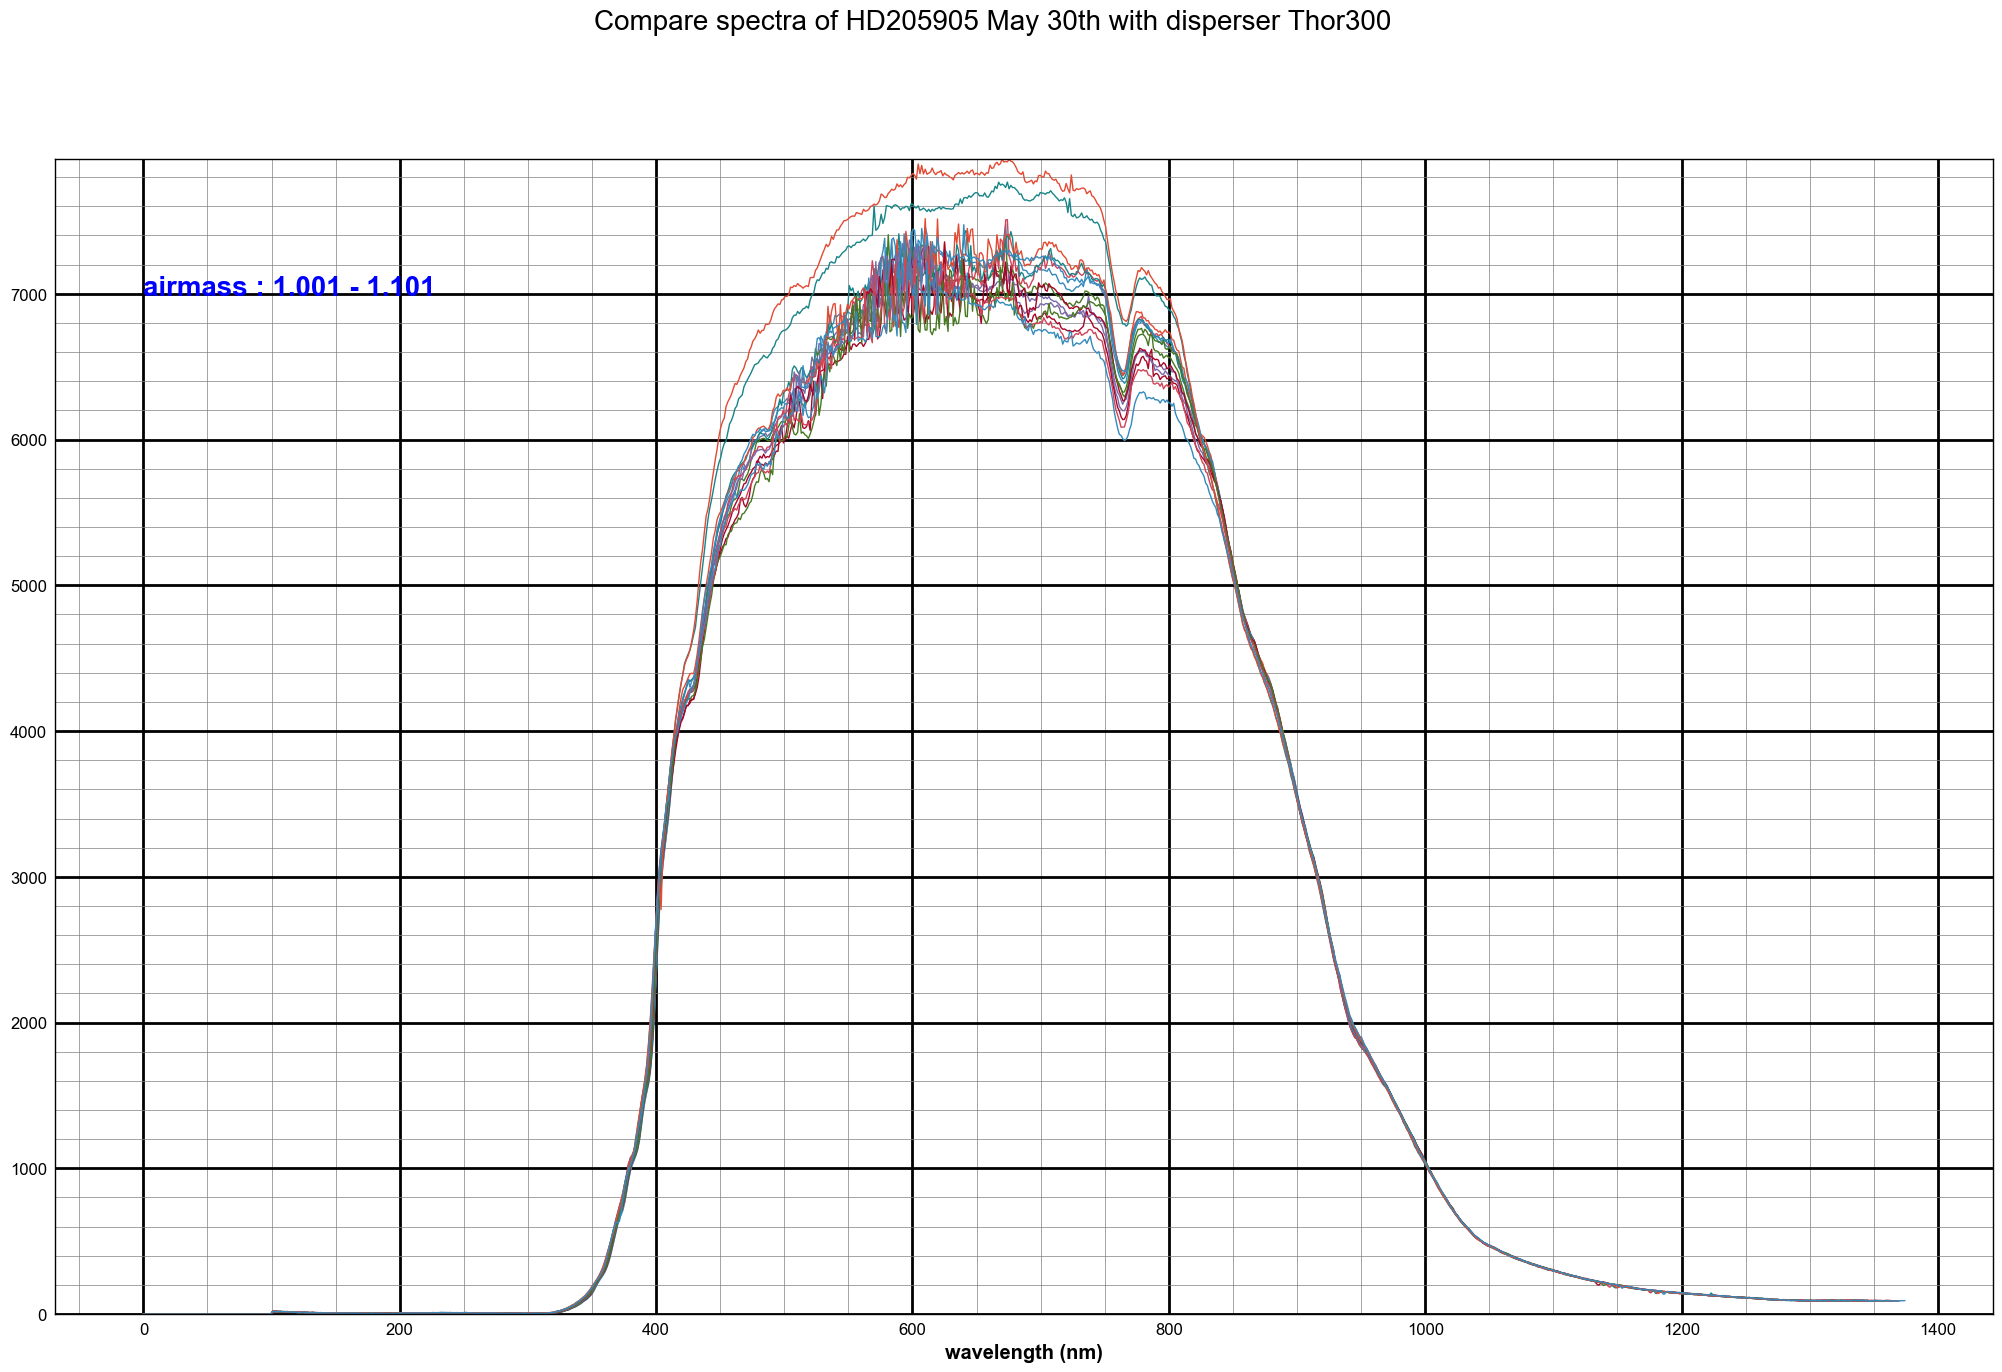

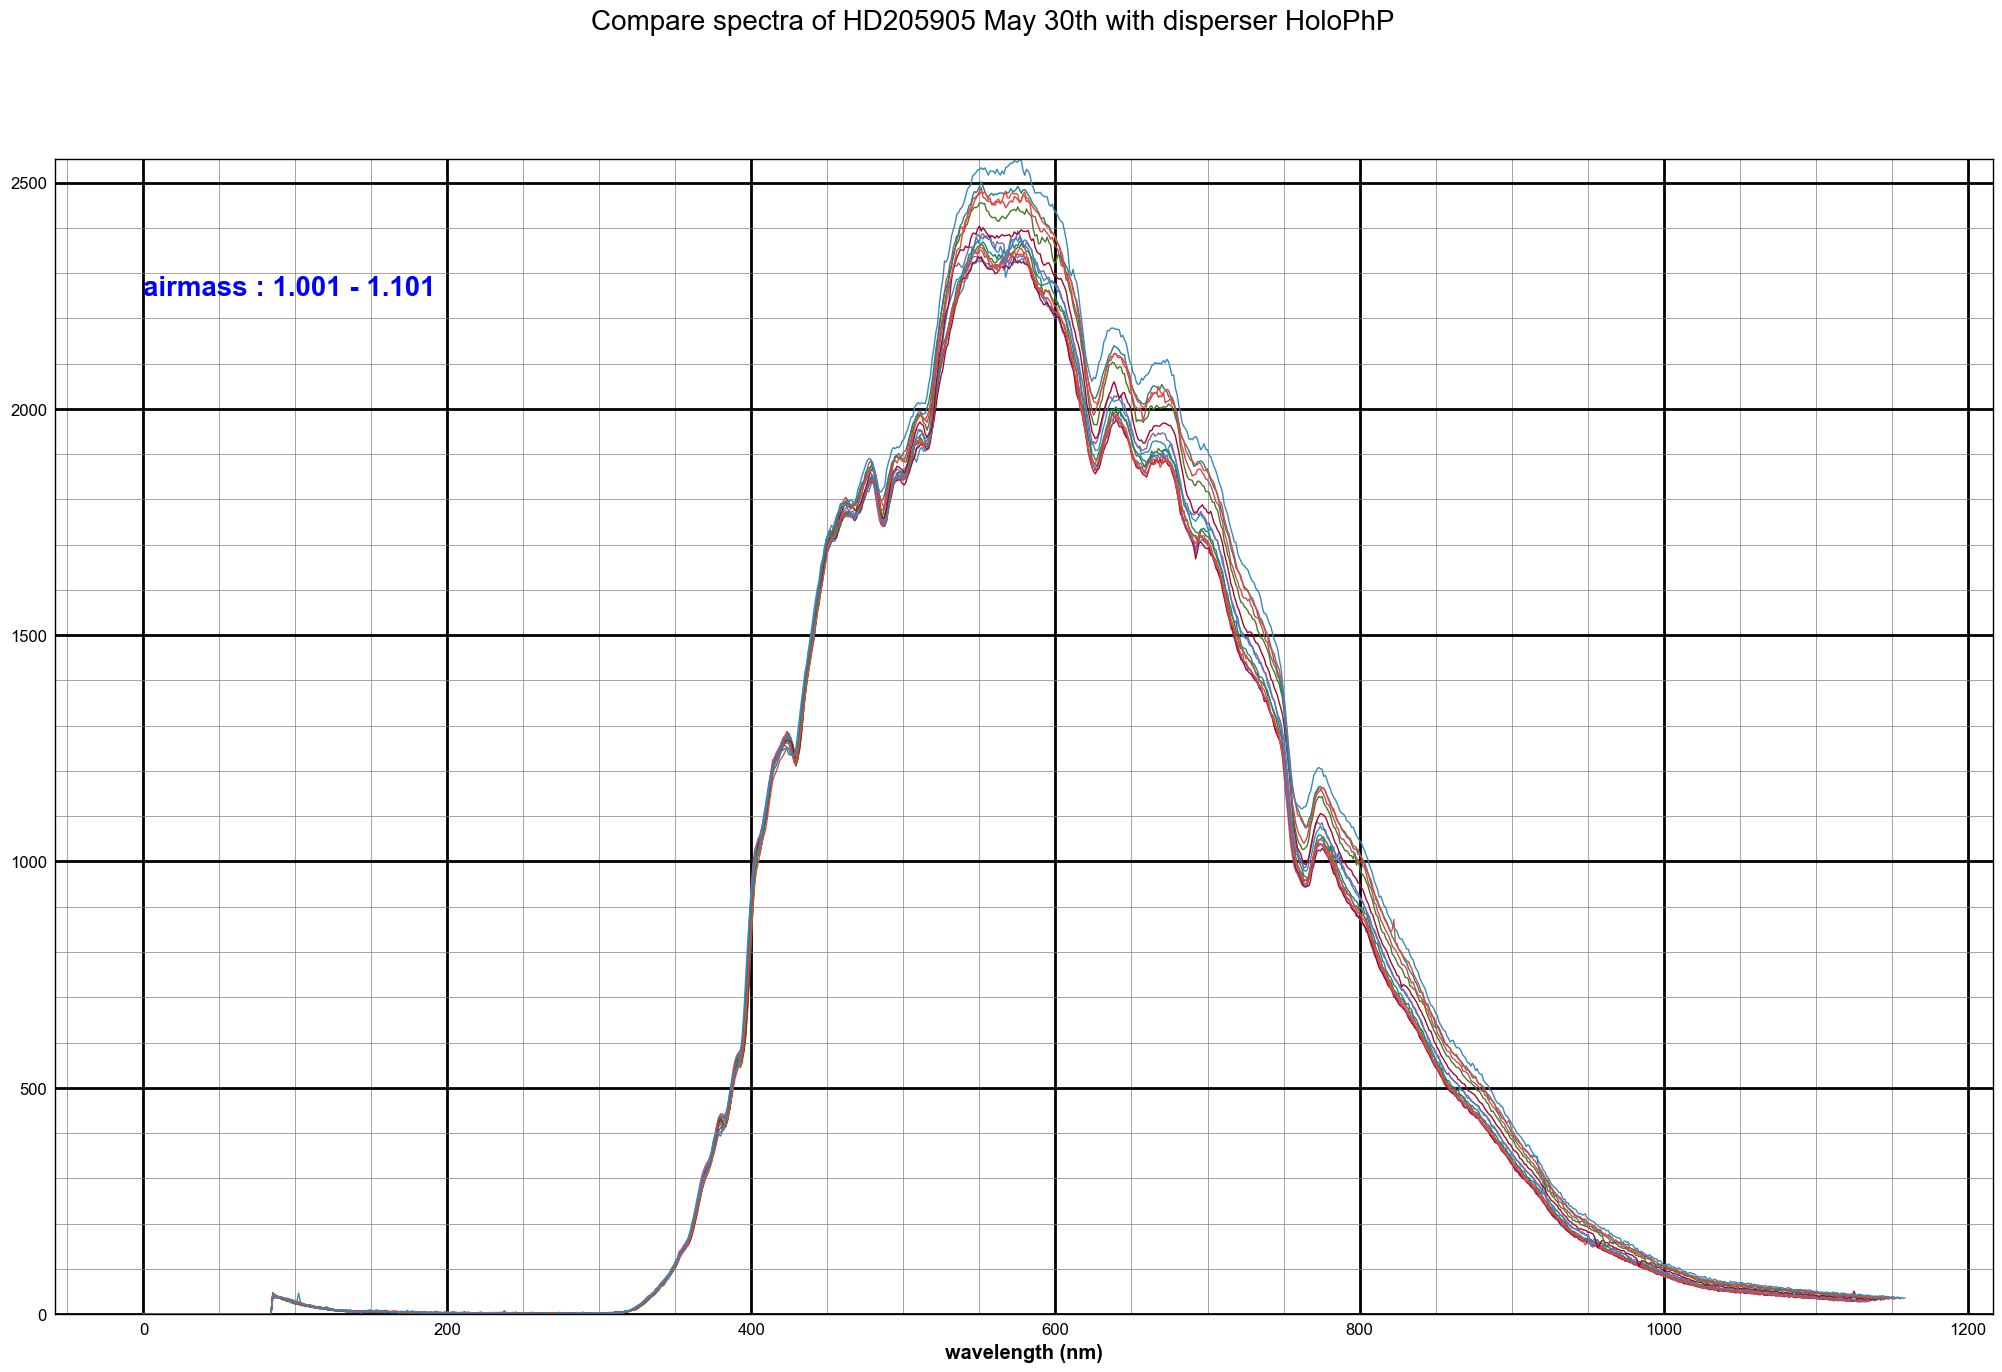

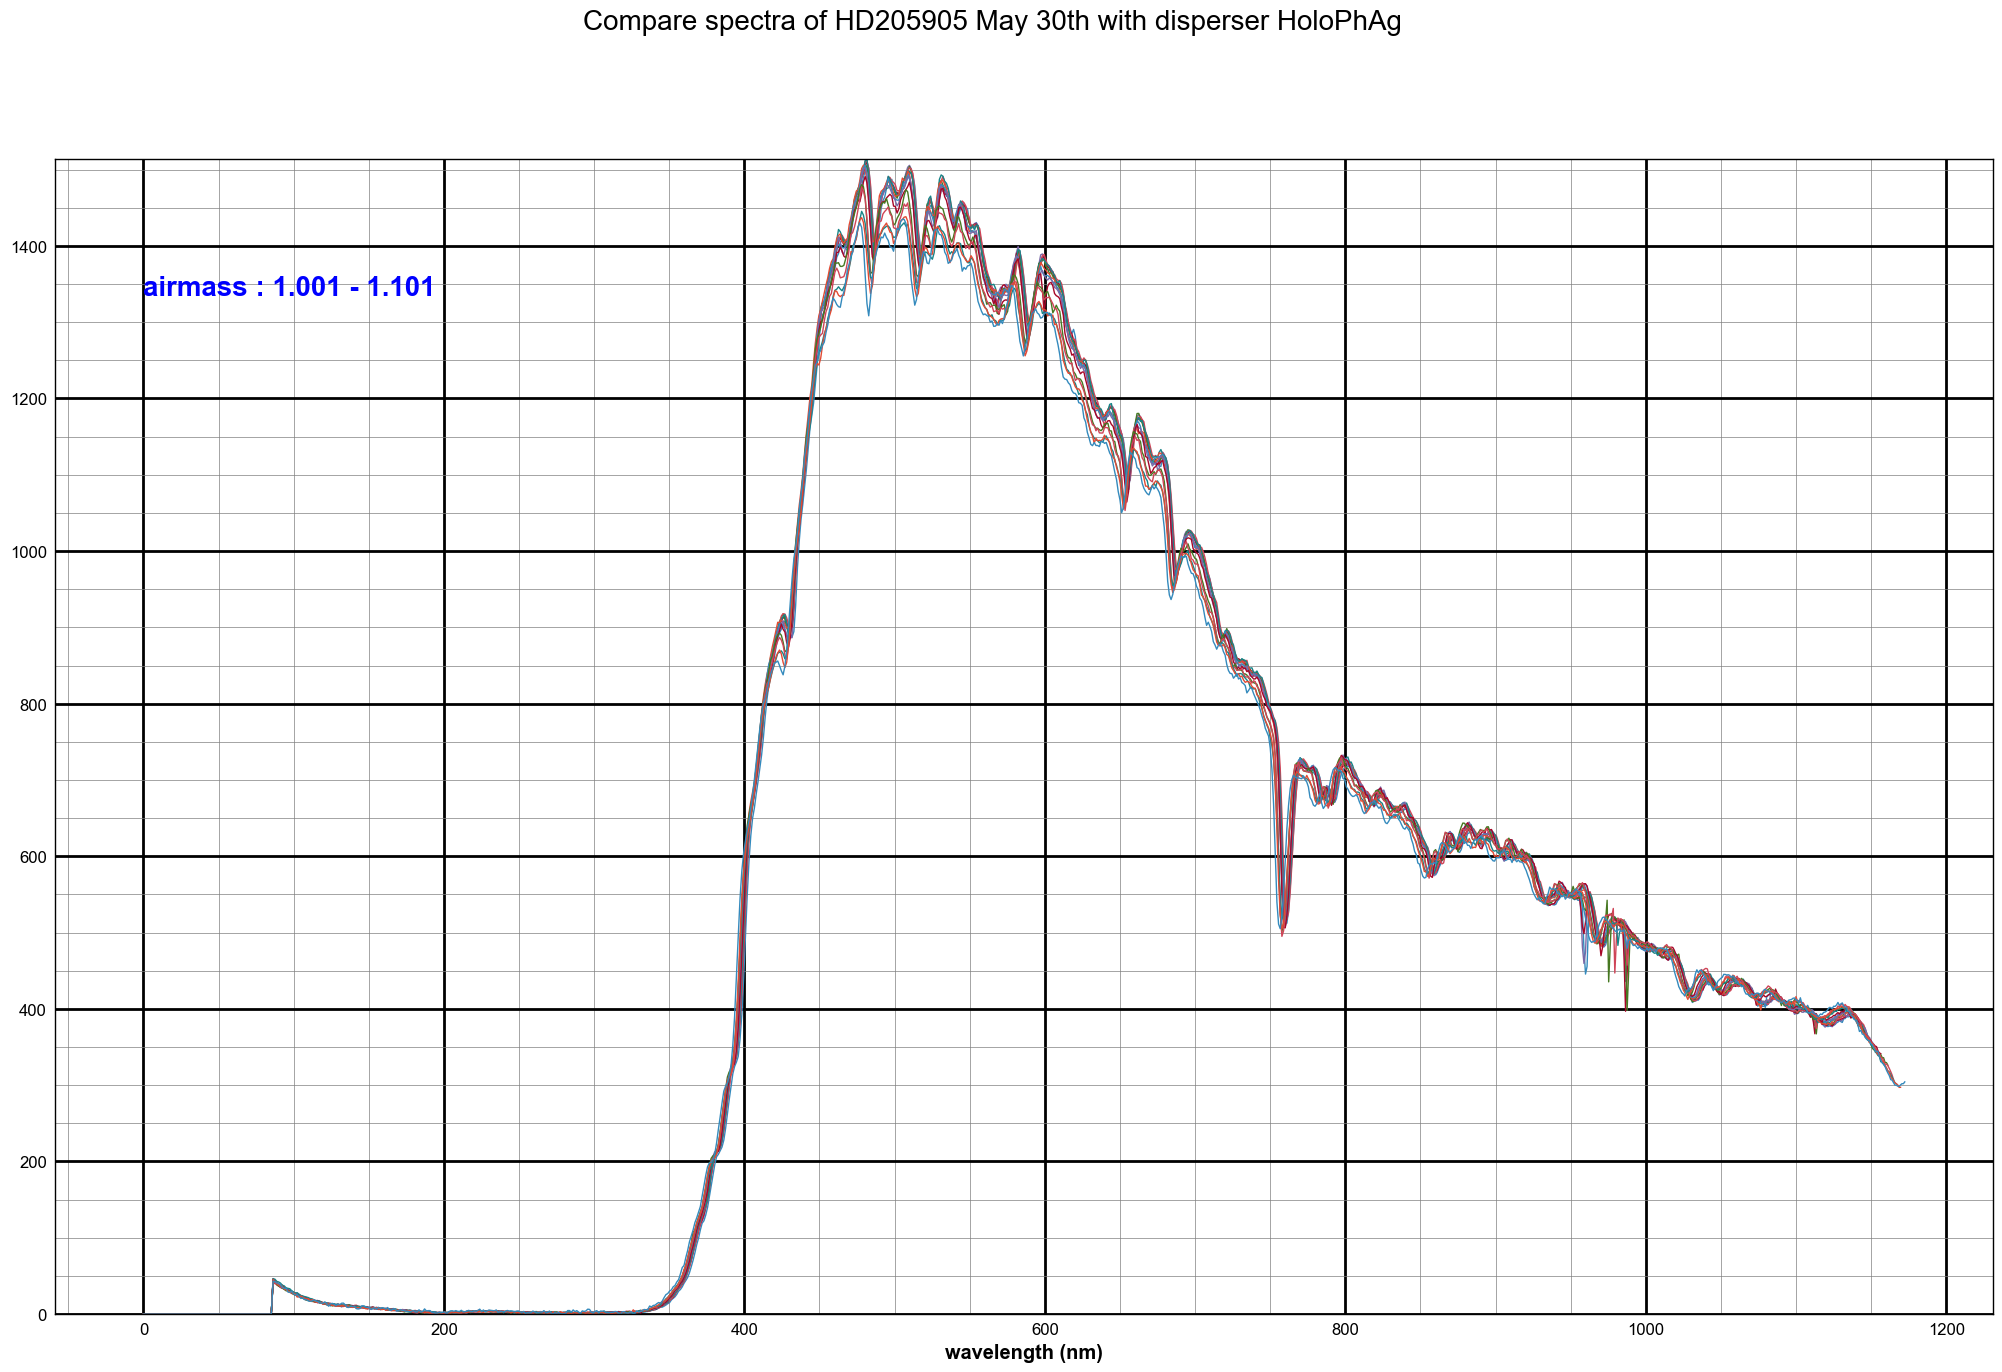

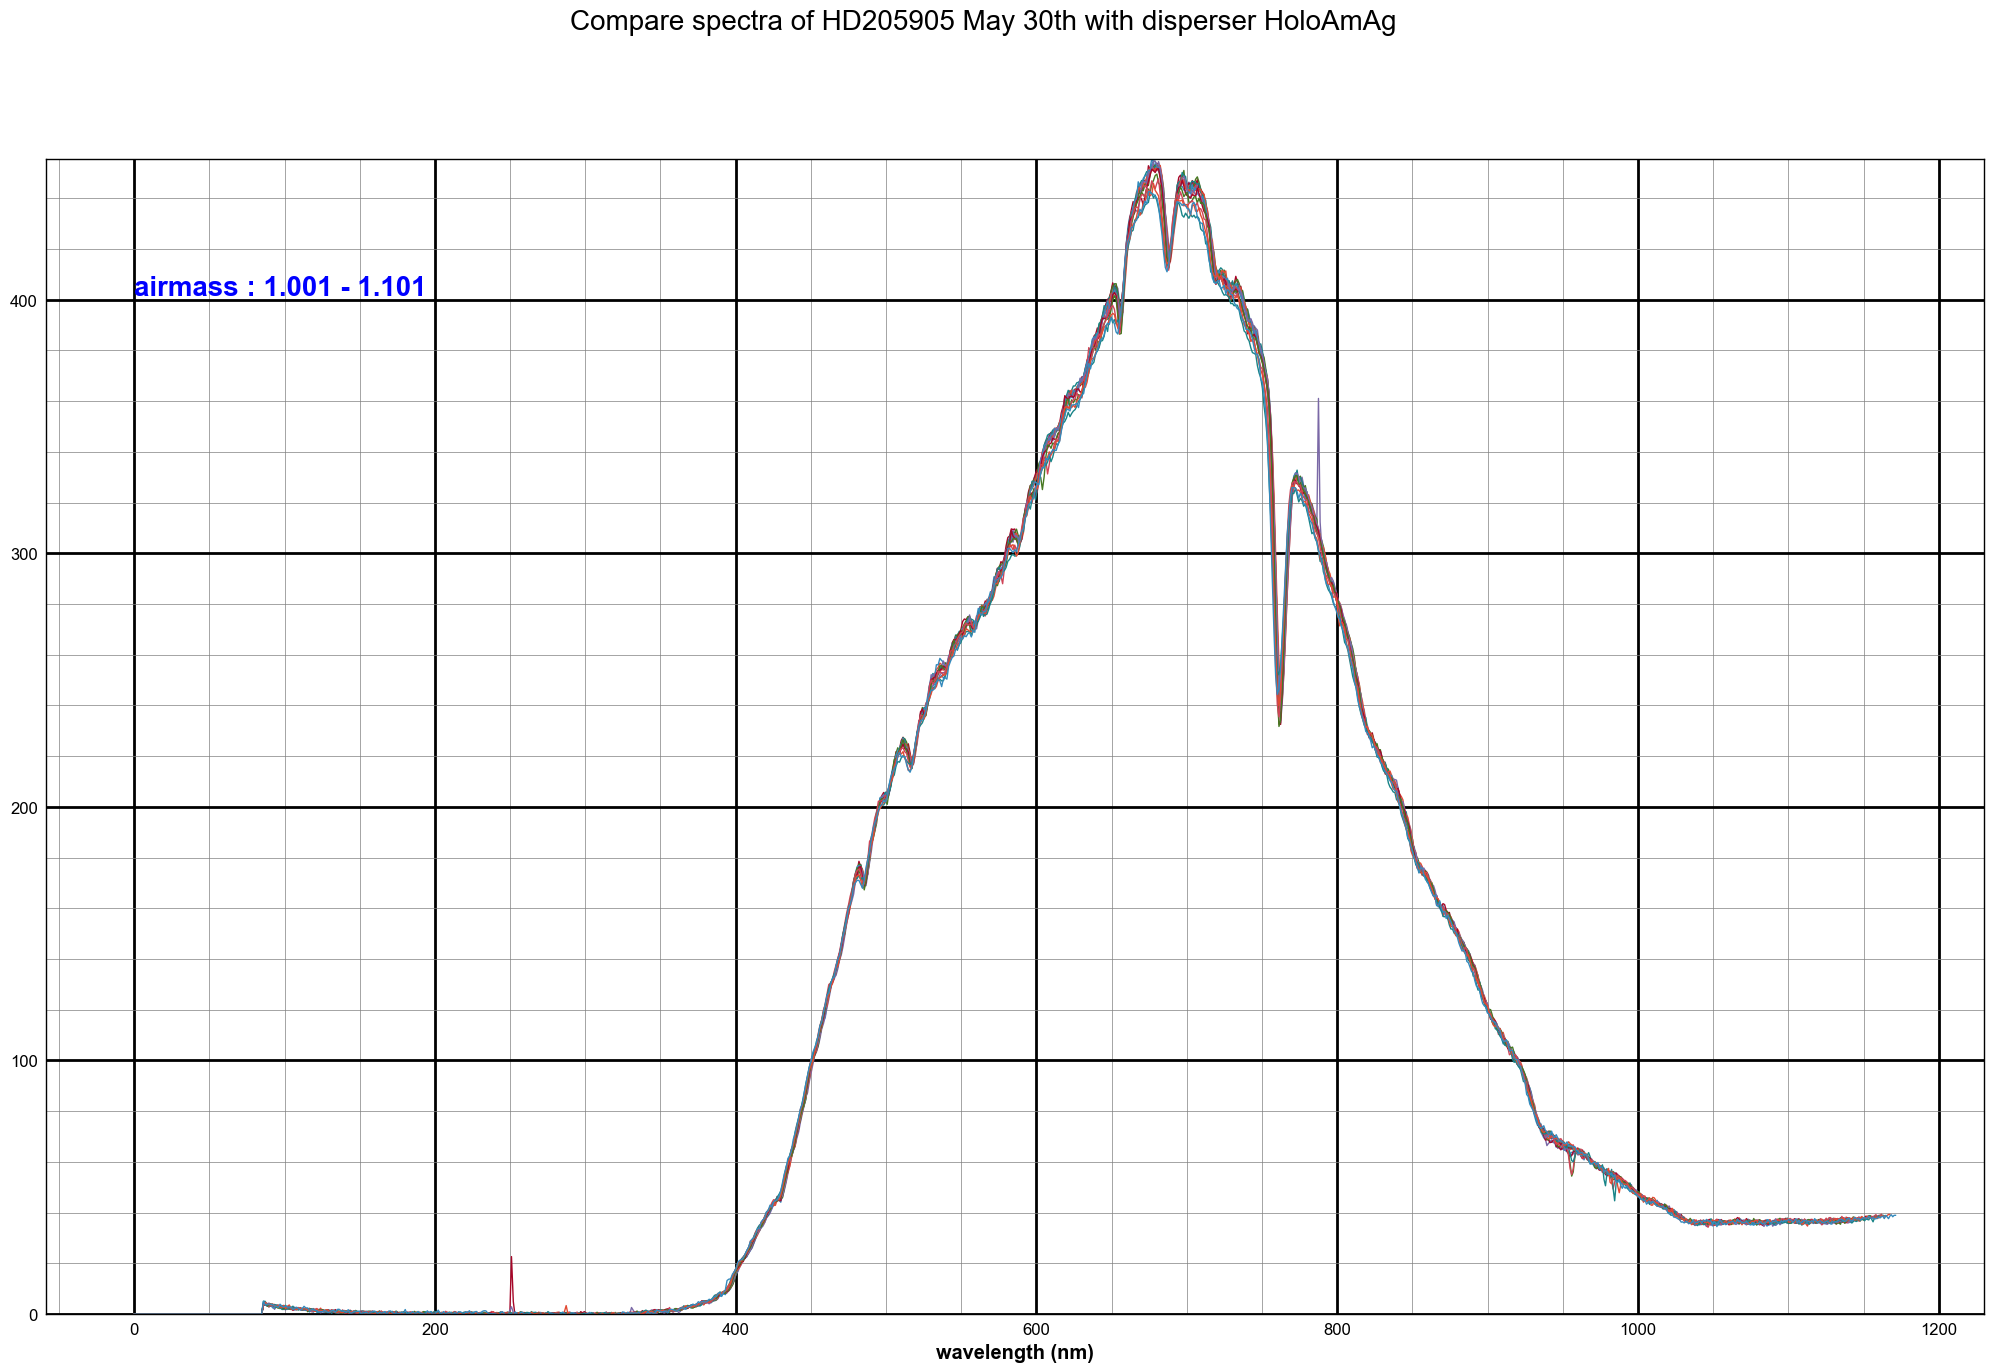

In [70]:
for dispname in ListOfDisperserNames:
    CompareSpectrumProfile(all_rightspectra_wl,all_rightspectra_data,all_titles,object_name,all_filt,dir_top_images,dispname)


In [71]:
#indexes_to_remove=CleanSpectrumProfile(all_rightspectra_wl,all_rightspectra_data,all_titles,object_name,all_filt,dir_top_images,'Thor300',[[465.,475.]])

## True Bouguer line on data spectrum

In [72]:
print all_filt

['Ron400', 'Thor300', 'HoloPhP', 'HoloPhAg', 'HoloAmAg', 'Ron400', 'Thor300', 'HoloPhP', 'HoloPhAg', 'HoloAmAg', 'Ron400', 'Thor300', 'HoloPhP', 'HoloPhAg', 'HoloAmAg', 'Ron400', 'Thor300', 'HoloPhP', 'HoloPhAg', 'HoloAmAg', 'Ron400', 'Thor300', 'HoloPhP', 'HoloPhAg', 'HoloAmAg', 'Ron400', 'Thor300', 'HoloPhP', 'HoloPhAg', 'HoloAmAg', 'Ron400', 'Thor300', 'HoloPhP', 'HoloPhAg', 'HoloAmAg', 'Ron400', 'Thor300', 'HoloPhP', 'HoloPhAg', 'HoloAmAg', 'Ron400', 'Thor300', 'HoloPhP', 'HoloPhAg', 'HoloAmAg', 'Ron400', 'Thor300', 'HoloPhP', 'HoloPhAg', 'HoloAmAg', 'Ron400', 'Thor300', 'HoloPhP', 'HoloPhAg', 'HoloAmAg', 'Ron400', 'Thor300', 'HoloPhP', 'HoloPhAg', 'HoloAmAg', 'Ron400', 'Thor300', 'HoloPhP', 'HoloPhAg', 'HoloAmAg', 'Ron400', 'Thor300', 'HoloPhP', 'HoloPhAg', 'HoloAmAg', 'Ron400', 'Thor300', 'HoloPhP', 'HoloPhAg', 'HoloAmAg']


In [73]:
re.search('Ron400',all_filt[1])

In [74]:
def bougline(x, a, b):
    return a*x + b

In [100]:
def ShowTrueBouguer(thewl,thespec,thezam,all_filt,sel_filt='HoloAmAg'):
    """
    ShowTrueBouguer:
    
    """
    
    fig, ax = plt.subplots(1, 1, figsize=(25,15))
    
    
    NBBands=6
    labels=["400-450nm", "450-500nm","500-550nm","550-600nm","600-650nm","650-700nm"]
    WLMINAbs=np.array([400.,450.,500.,550,600,650])
    WLMAXAbs=np.array([450.,500.,550.,600,650,700])
    
    NBSPEC=len(thespec)
    
    all_z = []
    all_log10S1vsZ = []
    all_log10S2vsZ = []
    all_log10S3vsZ = []
    all_log10S4vsZ = []
    all_log10S5vsZ = []
    all_log10S6vsZ = []
    all_log10S1vsZE = []
    all_log10S2vsZE = []
    all_log10S3vsZE = []
    all_log10S4vsZE = []
    all_log10S5vsZE = []
    all_log10S6vsZE = []
    
    fitparam = []
    all_yfit = []   
    xfit=np.linspace(1.,2.0,50)
    all_popt = []
    all_perr = []
    
    # loop on spectra
    for index in np.arange(NBSPEC):
        
        if re.search(sel_filt,all_filt[index]): 
        
            thez=thezam[index]
              
            wl_current=thewl[index]
            wl_spec=thespec[index]
        
            nbwl=wl_current.shape[0]
        
            band1=np.where(np.logical_and(wl_current>= WLMINAbs[0],wl_current<WLMAXAbs[0]))
            band2=np.where(np.logical_and(wl_current>= WLMINAbs[1],wl_current<WLMAXAbs[1]))    
            band3=np.where(np.logical_and(wl_current>= WLMINAbs[2],wl_current<WLMAXAbs[2])) 
            band4=np.where(np.logical_and(wl_current>= WLMINAbs[3],wl_current<WLMAXAbs[3])) 
            band5=np.where(np.logical_and(wl_current>= WLMINAbs[4],wl_current<WLMAXAbs[4])) 
            band6=np.where(np.logical_and(wl_current>= WLMINAbs[5],wl_current<WLMAXAbs[5])) 
        
            all_S1=wl_spec[band1]
            all_S2=wl_spec[band2]
            all_S3=wl_spec[band3]
            all_S4=wl_spec[band4]
            all_S5=wl_spec[band5]
            all_S6=wl_spec[band6]
        
            all_log10S1 = 2.5*np.log10(all_S1)
            all_log10S2 = 2.5*np.log10(all_S2)
            all_log10S3 = 2.5*np.log10(all_S3)
            all_log10S4 = 2.5*np.log10(all_S4)
            all_log10S5 = 2.5*np.log10(all_S5)
            all_log10S6 = 2.5*np.log10(all_S6)
    
            all_z.append(thez)
            all_log10S1vsZ.append(np.average(all_log10S1))
            all_log10S2vsZ.append(np.average(all_log10S2))
            all_log10S3vsZ.append(np.average(all_log10S3))
            all_log10S4vsZ.append(np.average(all_log10S4))
            all_log10S5vsZ.append(np.average(all_log10S5))
            all_log10S6vsZ.append(np.average(all_log10S6))
            all_log10S1vsZE.append(np.std(all_log10S1)/np.sqrt(all_log10S1.shape[0]))
            all_log10S2vsZE.append(np.std(all_log10S2)/np.sqrt(all_log10S2.shape[0]))
            all_log10S3vsZE.append(np.std(all_log10S3)/np.sqrt(all_log10S3.shape[0]))
            all_log10S4vsZE.append(np.std(all_log10S4)/np.sqrt(all_log10S4.shape[0]))
            all_log10S5vsZE.append(np.std(all_log10S5)/np.sqrt(all_log10S5.shape[0]))
            all_log10S6vsZE.append(np.std(all_log10S6)/np.sqrt(all_log10S6.shape[0]))
    
    ###########    
    # band 1
    ############
    z = np.polyfit(all_z,all_log10S1vsZ, 1)
    fitparam.append(z)  
    print "--------------------------------------------------------------------------"
    print "z = ",z
    popt, pcov = curve_fit(bougline, all_z, all_log10S1vsZ,p0=z,sigma=all_log10S1vsZE)
    perr = np.sqrt(np.diag(pcov))
    
    print "popt = ",popt,' pcov',pcov,' perr',perr
    
    pol = np.poly1d(popt)
    yyyfit=pol(all_z)
    chi2sum=(yyyfit-np.array(all_log10S1vsZ))**2/np.array(all_log10S1vsZE)**2
    chi2=np.average(chi2sum)*chi2sum.shape[0]/(chi2sum.shape[0]-3)
    print 'chi2',chi2
    
    all_popt.append(popt)
    all_perr.append(perr)
    
    p = np.poly1d(z)
    yfit=p(xfit)
    y0fit=p(1.)
    all_yfit.append(yfit-y0fit)
    ax.plot(xfit,yfit-y0fit,'-',color='blue')        
    #ax.plot(all_z,all_log10S1vsZ-y0fit,'o-',color='blue',label=labels[0])
    ax.errorbar(all_z,all_log10S1vsZ-y0fit,yerr=all_log10S1vsZE,fmt='--o',color='blue',label=labels[0])
    
    #########
    # band 2
    #########
    z = np.polyfit(all_z,all_log10S2vsZ, 1)
    fitparam.append(z)    
    print "--------------------------------------------------------------------------"
    print "z = ",z
    popt, pcov = curve_fit(bougline, all_z, all_log10S2vsZ,p0=z,sigma=all_log10S2vsZE)
    perr = np.sqrt(np.diag(pcov))
    print "popt = ",popt,' pcov',pcov,' perr',perr
    pol = np.poly1d(popt)
    yyyfit=pol(all_z)
    chi2sum=(yyyfit-np.array(all_log10S2vsZ))**2/np.array(all_log10S2vsZE)**2
    chi2=np.average(chi2sum)*chi2sum.shape[0]/(chi2sum.shape[0]-3)
    print 'chi2',chi2
    
    all_popt.append(popt)
    all_perr.append(perr)
      
    p = np.poly1d(z)
    yfit=p(xfit)
    y0fit=p(1.)
    all_yfit.append(yfit-y0fit)
    ax.plot(xfit,yfit-y0fit,'-',color='green')  
    #ax.plot(all_z,all_log10S2vsZ-y0fit,'o-',color='green',label=labels[1])
    ax.errorbar(all_z,all_log10S2vsZ-y0fit,yerr=all_log10S2vsZE,fmt='--o',color='green',label=labels[1])
    
    ###########
    # band 3
    ########
    z = np.polyfit(all_z,all_log10S3vsZ, 1)
    fitparam.append(z) 
    print "--------------------------------------------------------------------------"
    print "z = ",z
    popt, pcov = curve_fit(bougline, all_z, all_log10S3vsZ,p0=z,sigma=all_log10S3vsZE)
    perr = np.sqrt(np.diag(pcov))
    print "popt = ",popt,' pcov',pcov,' perr',perr
    pol = np.poly1d(popt)
    yyyfit=pol(all_z)
    chi2sum=(yyyfit-np.array(all_log10S3vsZ))**2/np.array(all_log10S3vsZE)**2
    chi2=np.average(chi2sum)*chi2sum.shape[0]/(chi2sum.shape[0]-3)
    print 'chi2',chi2
    all_popt.append(popt)
    all_perr.append(perr)
    
    p = np.poly1d(z)
    yfit=p(xfit)
    y0fit=p(1.)
    all_yfit.append(yfit-y0fit)
    ax.plot(xfit,yfit-y0fit,'-',color='red')  
    #ax.plot(all_z,all_log10S3vsZ-y0fit,'o-',color='red',label=labels[2])
    ax.errorbar(all_z,all_log10S3vsZ-y0fit,yerr=all_log10S3vsZE,fmt='--o',color='red',label=labels[2])
    #ax.plot(all_z,all_log10S4vsZ,'o-',color='magenta',label=labels[3])
    #ax.plot(all_z,all_log10S5vsZ,'o-',color='black',label=labels[4])
    #ax.plot(all_z,all_log10S6vsZ,'o-',color='grey',label=labels[5])
    
    #########
    # band 4
    ##########
    z = np.polyfit(all_z,all_log10S4vsZ, 1)
    fitparam.append(z)  
    print "--------------------------------------------------------------------------"
    print "z = ",z
    popt, pcov = curve_fit(bougline, all_z, all_log10S4vsZ,p0=z,sigma=all_log10S4vsZE)
    perr = np.sqrt(np.diag(pcov))
    print "popt = ",popt,' pcov',pcov,' perr',perr
    pol = np.poly1d(popt)
    yyyfit=pol(all_z)
    chi2sum=(yyyfit-np.array(all_log10S4vsZ))**2/np.array(all_log10S4vsZE)**2
    chi2=np.average(chi2sum)*chi2sum.shape[0]/(chi2sum.shape[0]-3)
    print 'chi2',chi2
    all_popt.append(popt)
    all_perr.append(perr)
    p = np.poly1d(z)
    yfit=p(xfit)
    y0fit=p(1.)
    all_yfit.append(yfit-y0fit)
    ax.plot(xfit,yfit-y0fit,'-',color='magenta')  
    #ax.plot(all_z,all_log10S3vsZ-y0fit,'o-',color='red',label=labels[2])
    ax.errorbar(all_z,all_log10S4vsZ-y0fit,yerr=all_log10S4vsZE,fmt='--o',color='magenta',label=labels[3])
    
    #########
    # band 5
    ########
    z = np.polyfit(all_z,all_log10S5vsZ, 1)
    fitparam.append(z) 
    print "--------------------------------------------------------------------------"
    print "z = ",z
    popt, pcov = curve_fit(bougline, all_z, all_log10S5vsZ,p0=z,sigma=all_log10S5vsZE)
    perr = np.sqrt(np.diag(pcov))
    print "popt = ",popt,' pcov',pcov,' perr',perr
    pol = np.poly1d(popt)
    yyyfit=pol(all_z)
    chi2sum=(yyyfit-np.array(all_log10S5vsZ))**2/np.array(all_log10S5vsZE)**2
    chi2=np.average(chi2sum)*chi2sum.shape[0]/(chi2sum.shape[0]-3)
    print 'chi2',chi2
    all_popt.append(popt)
    all_perr.append(perr)
    p = np.poly1d(z)
    yfit=p(xfit)
    y0fit=p(1.)
    all_yfit.append(yfit-y0fit)
    ax.plot(xfit,yfit-y0fit,'-',color='black')  
    #ax.plot(all_z,all_log10S3vsZ-y0fit,'o-',color='red',label=labels[2])
    ax.errorbar(all_z,all_log10S5vsZ-y0fit,yerr=all_log10S5vsZE,fmt='--o',color='black',label=labels[4])
    
    #########
    # band 6
    #########
    z = np.polyfit(all_z,all_log10S6vsZ, 1)
    fitparam.append(z)
    print "--------------------------------------------------------------------------"
    print "z = ",z
    popt, pcov = curve_fit(bougline, all_z, all_log10S6vsZ,p0=z,sigma=all_log10S6vsZE)
    perr = np.sqrt(np.diag(pcov))
    print "popt = ",popt,' pcov',pcov,' perr',perr
    pol = np.poly1d(popt)
    yyyfit=pol(all_z)
    chi2sum=(yyyfit-np.array(all_log10S6vsZ))**2/np.array(all_log10S6vsZE)**2
    chi2=np.average(chi2sum)*chi2sum.shape[0]/(chi2sum.shape[0]-3)
    print 'chi2',chi2
    all_popt.append(popt)
    all_perr.append(perr)
    p = np.poly1d(z)
    yfit=p(xfit)
    y0fit=p(1.)
    all_yfit.append(yfit-y0fit)
    ax.plot(xfit,yfit-y0fit,'-',color='grey')  
    #ax.plot(all_z,all_log10S3vsZ-y0fit,'o-',color='red',label=labels[2])
    ax.errorbar(all_z,all_log10S6vsZ-y0fit,yerr=all_log10S6vsZE,fmt='--o',color='grey',label=labels[5])
    
    
    ax.grid(True)
    #ax.get_xaxis().set_minor_locator(mpl.ticker.AutoMinorLocator())
    #ax.get_yaxis().set_minor_locator(mpl.ticker.AutoMinorLocator())
    #ax.grid(b=True, which='major', colo1r='k', linewidth=2.0)
    #ax.grid(b=True, which='minor', color='k', linewidth=0.5) 
    title="BOUGUER line for object {} for disperser {} ".format(object_name,sel_filt)
    ax.set_title(title)
    ax.set_xlabel("airmass")
    ax.set_ylabel("$M =2.5 * log_{10}(F_{data})$")
    ax.legend(loc="best")
    ax.set_xlim(1.,max(all_z)*1.01)
    #ax.set_ylim(-0.05,0.05)
    figname='truebougher'+'_'+sel_filt+'.pdf'
    figfilename=os.path.join(dir_top_images,figname)
    plt.savefig(figfilename)
    return fitparam,all_popt,all_perr
    

--------------------------------------------------------------------------
z =  [-0.20613464  7.21220832]
popt =  [-0.20749499  7.21366458]  pcov [[ 0.00236645 -0.00243087]
 [-0.00243087  0.00249916]]  perr [ 0.0486462   0.04999164]
chi2 0.0537635675894
--------------------------------------------------------------------------
z =  [-0.12030981  7.60652354]
popt =  [-0.1239361   7.61039059]  pcov [[ 0.00266067 -0.00273117]
 [-0.00273117  0.00280586]]  perr [ 0.05158172  0.05297037]
chi2 0.397814487182
--------------------------------------------------------------------------
z =  [ 0.05811625  7.63132587]
popt =  [ 0.06216708  7.62703926]  pcov [[ 0.00559768 -0.00575473]
 [-0.00575473  0.00592118]]  perr [ 0.07481765  0.0769492 ]
chi2 0.911354217413
--------------------------------------------------------------------------
z =  [ 0.10027167  7.76726813]
popt =  [ 0.10188274  7.76544478]  pcov [[ 0.00551485 -0.00566035]
 [-0.00566035  0.0058145 ]]  perr [ 0.07426206  0.07625287]
chi2 2.

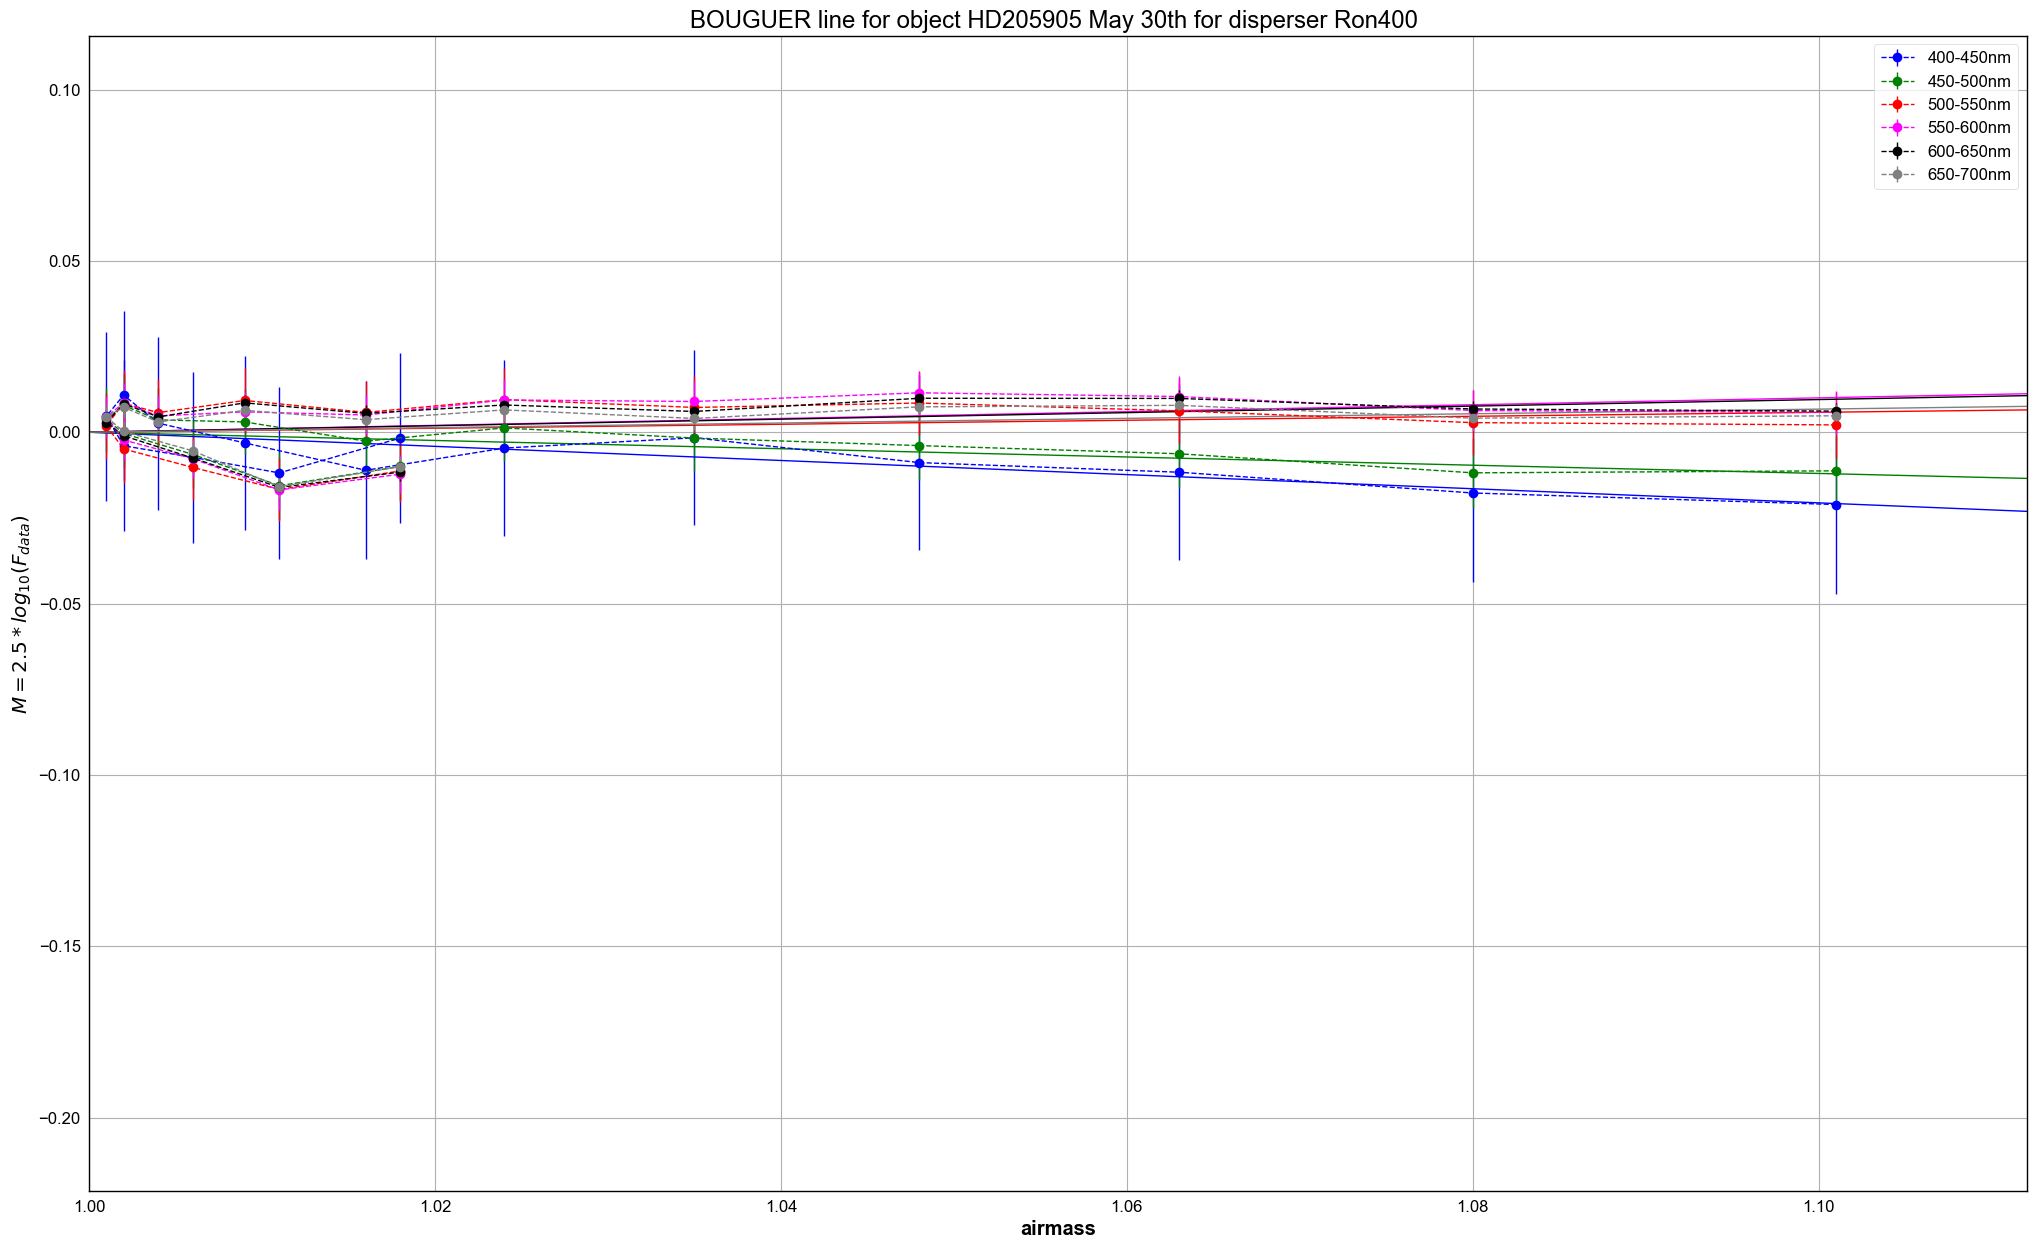

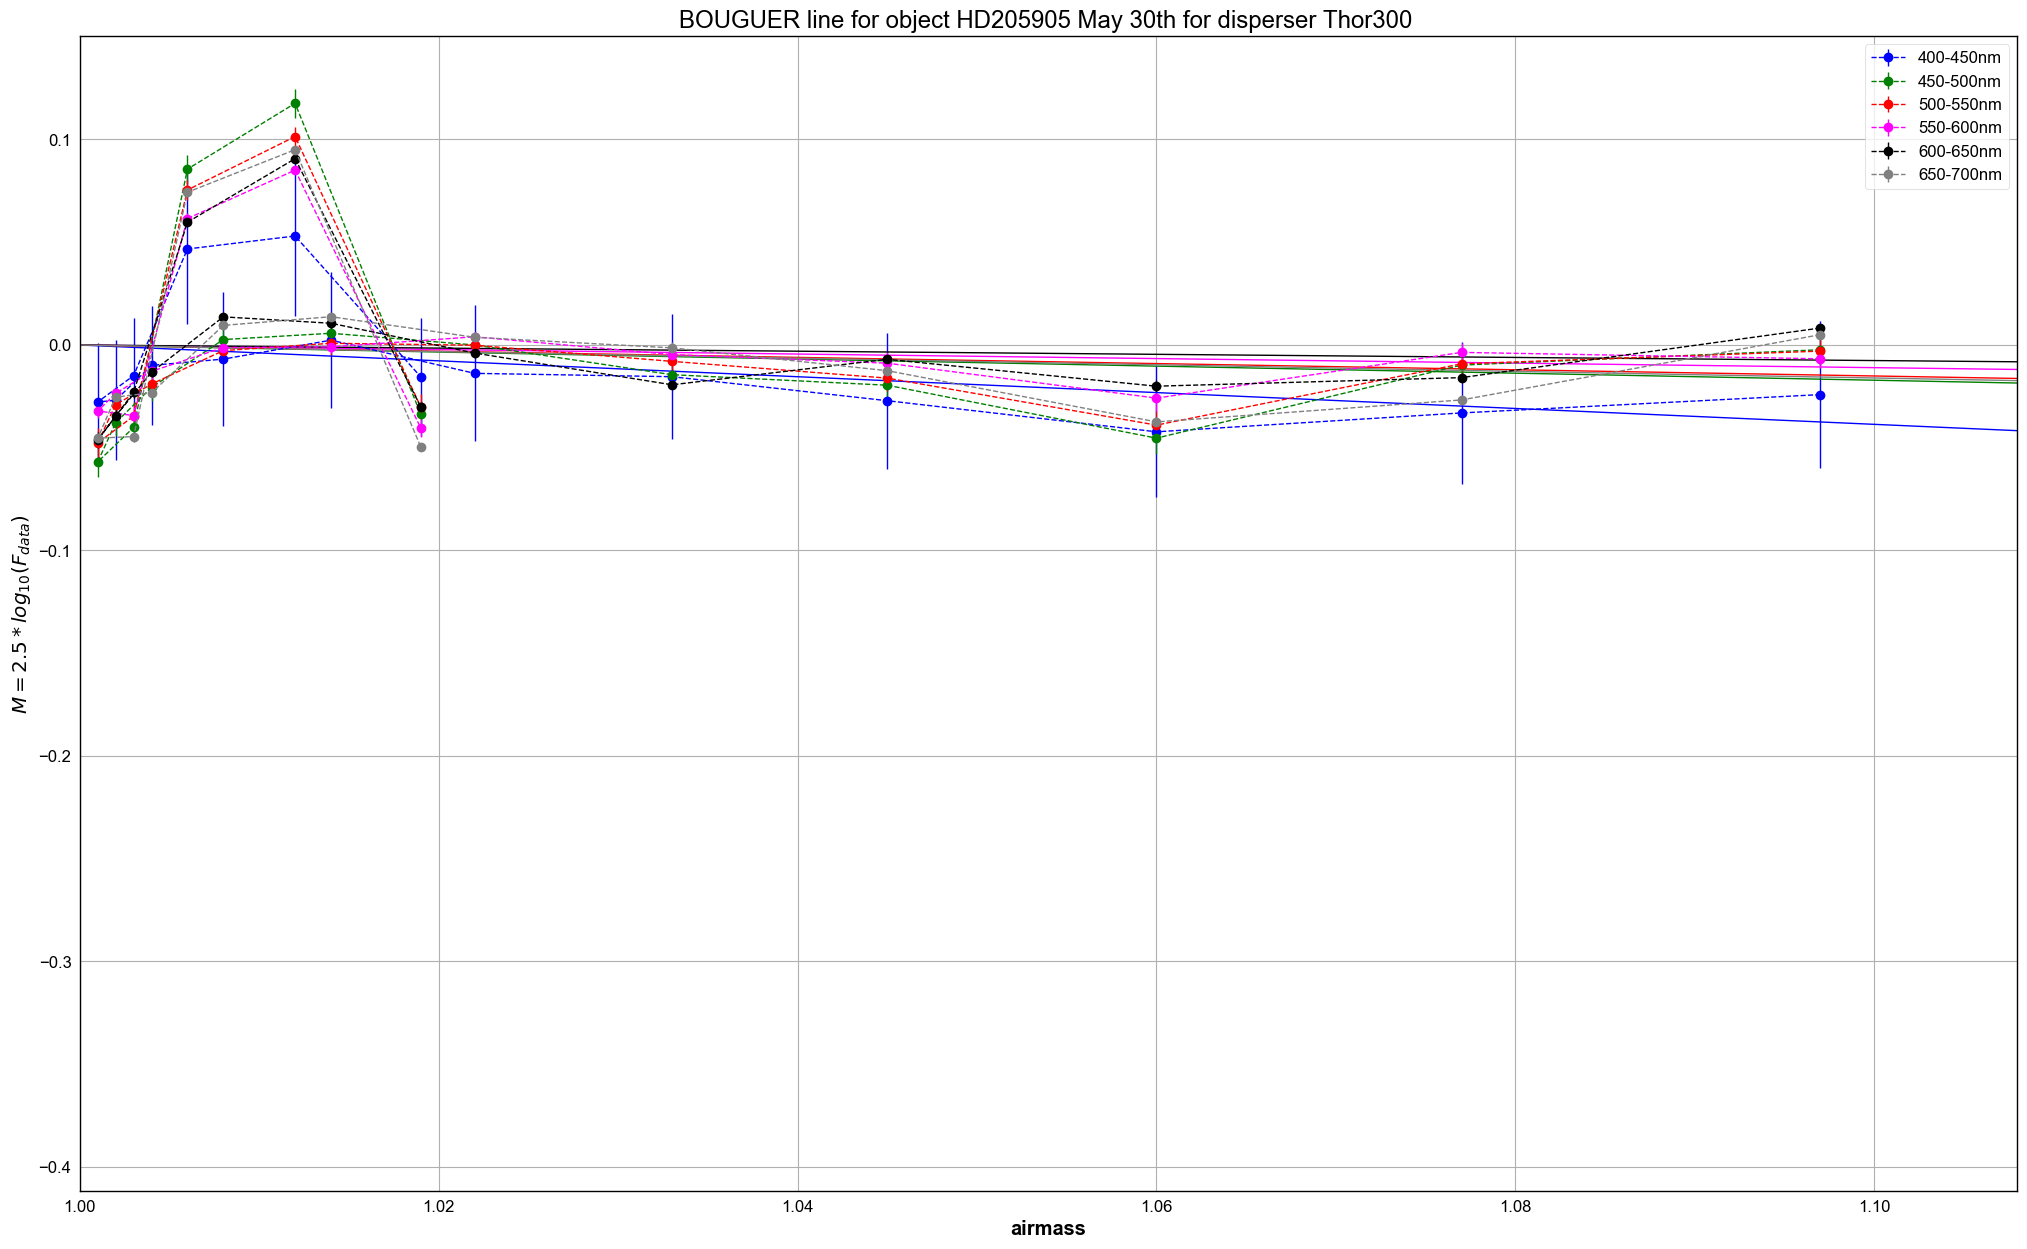

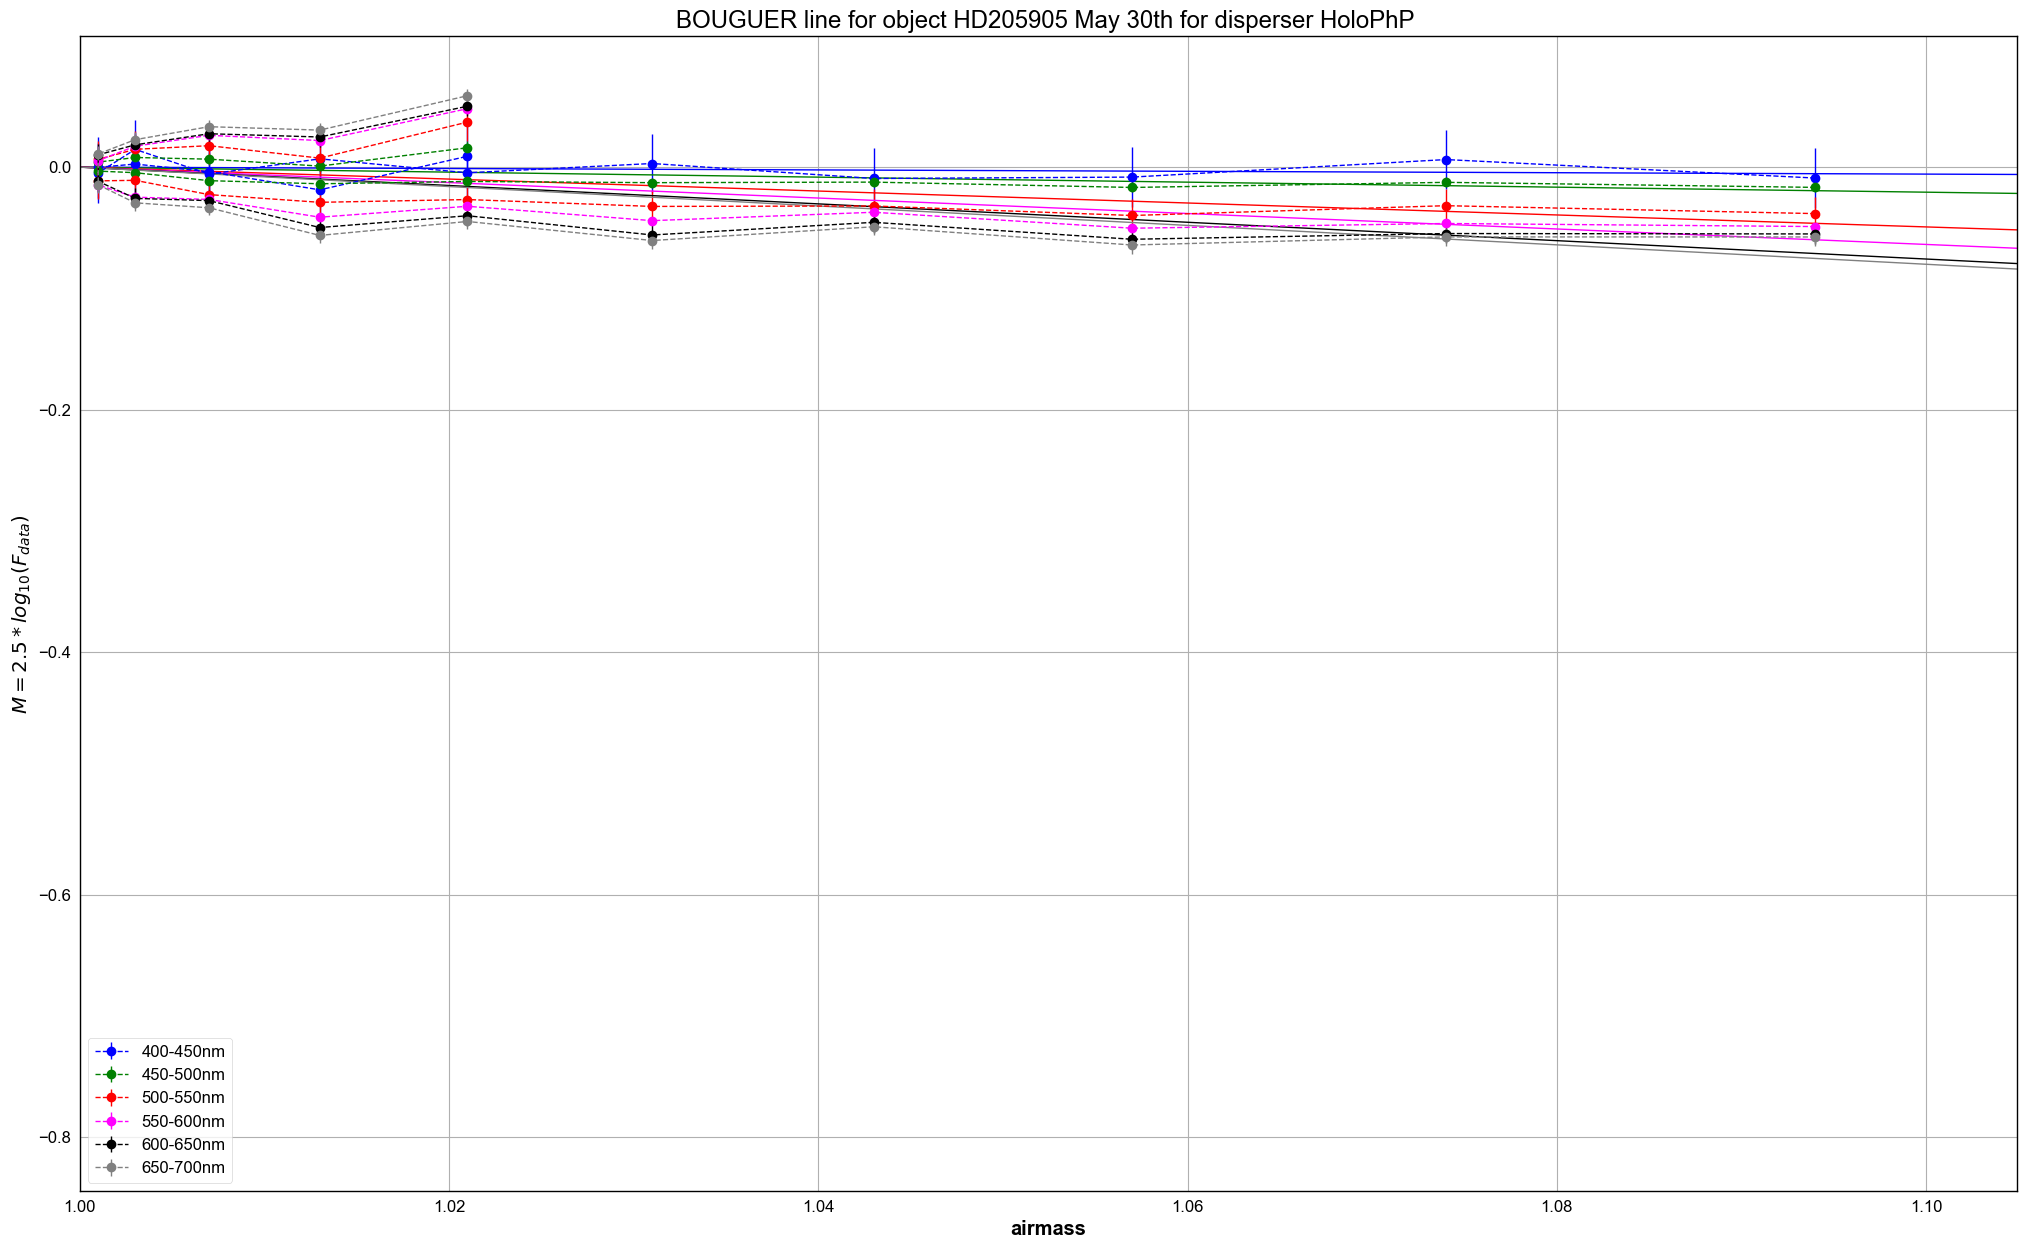

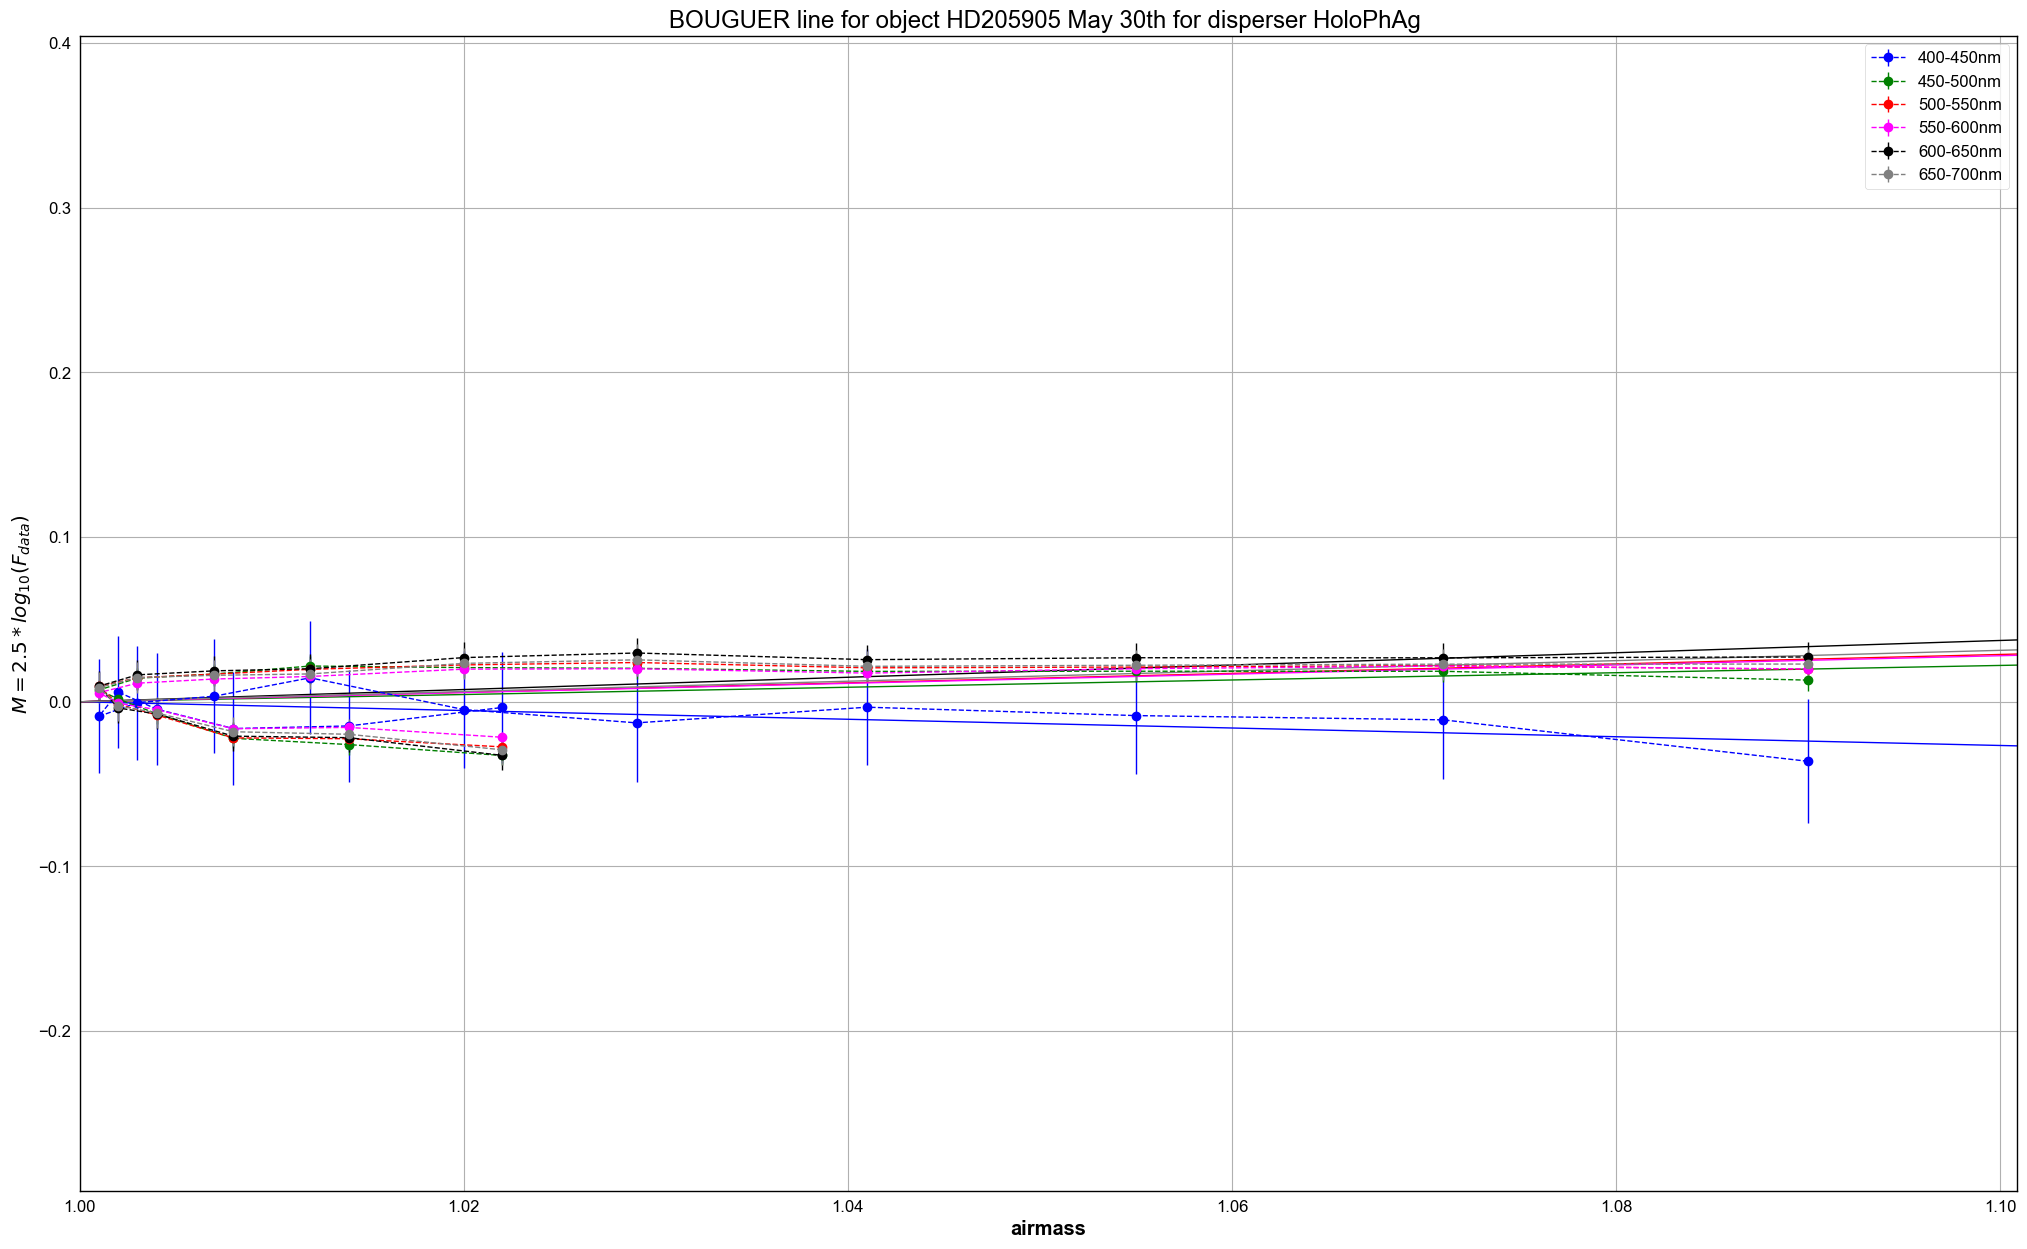

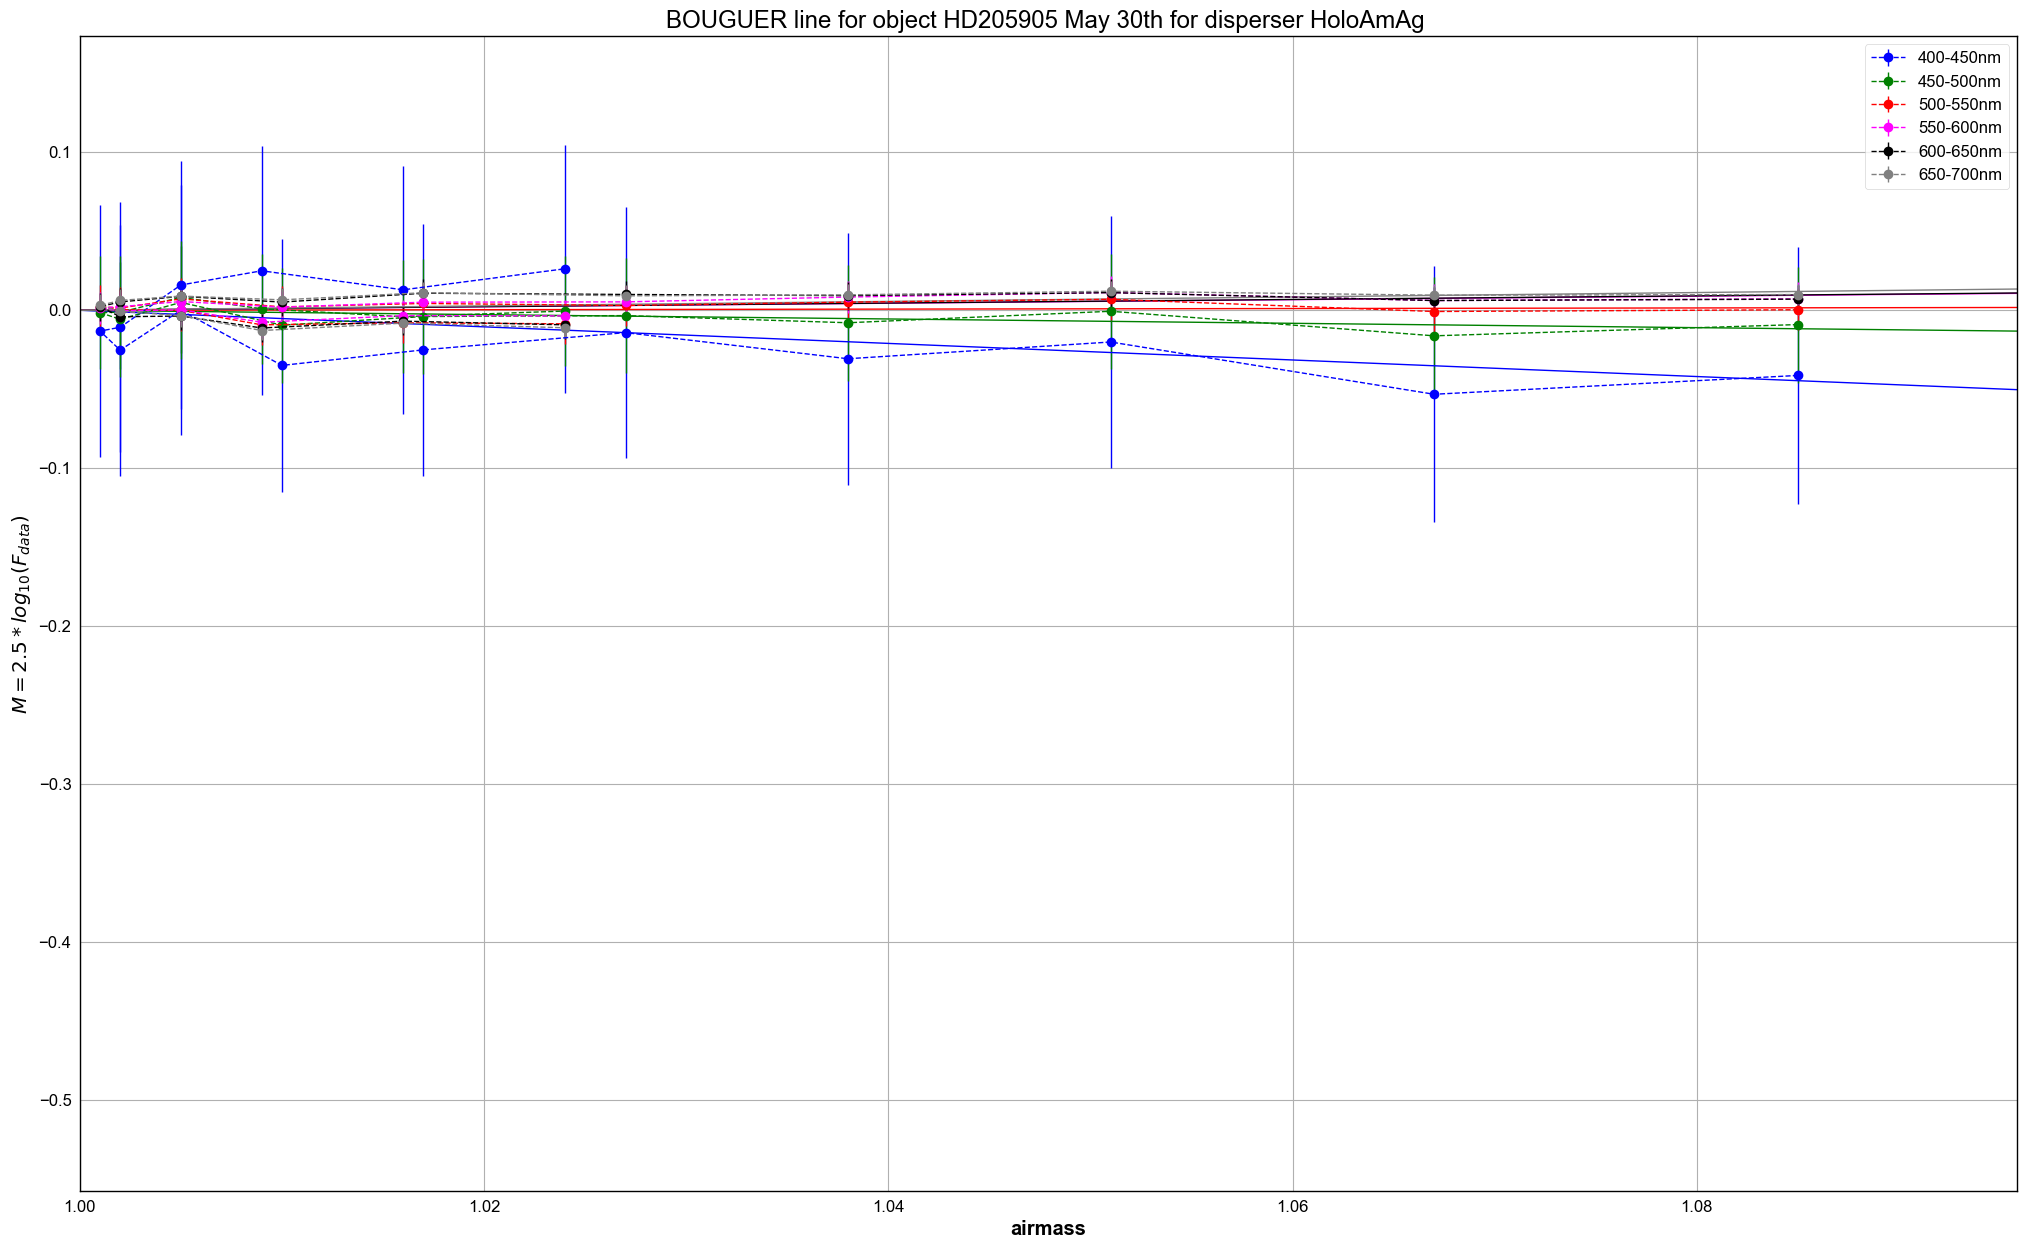

In [101]:
#fitparamtruebouguer,popt_truebouguer,perr_truebouguer = ShowTrueBouguer(all_selected_wl,all_selected_dataspectrum,all_airmass)
for dispname in ListOfDisperserNames:
    fitparamtruebouguer,popt_truebouguer,perr_truebouguer = ShowTrueBouguer(all_rightspectra_wl,all_rightspectra_data,all_airmass,all_filt,dispname)

In [77]:
#all_dates,all_airmass,all_titles,all_header,all_expo,all_leftspectra_data,all_rightspectra_data,all_leftspectra_wl,all_rightspectra_wl,all_filt

In [78]:
truncpopt_truebouguer=np.trunc(np.array(popt_truebouguer)*10000)/10000
truncperr_truebouguer=np.trunc(np.array(perr_truebouguer)*10000)/10000

In [79]:
table = ListTable()
table.append(["slope","error"])
for idd in range(0,6):
    table.append([truncpopt_truebouguer[idd][0],truncperr_truebouguer[idd][0]])
table

[['slope', 'error'],
 [-0.52500000000000002, 0.2205],
 [-0.1376, 0.0528],
 [0.02, 0.057000000000000002],
 [0.1134, 0.045900000000000003],
 [0.1129, 0.077100000000000002],
 [0.15079999999999999, 0.084000000000000005]]

In [80]:
np.array(popt_truebouguer)[:,0]

array([-0.5250422 , -0.13760373,  0.0200744 ,  0.1134683 ,  0.1129262 ,
        0.15089934])

## Fit Rayleigh Scattering

In [81]:
def FuncRayleigh(x,a):
    return a*(400/x)**4/(1-0.0752*(400./x)**2)

In [82]:
def PlotRayleigh(thepopt,theperr):
    X= [425.,475.,525.,575.,625.,675.]
    Y= np.array(thepopt)[:,0]
    EY=np.array(theperr)[:,0]*10
    
    fig, ax = plt.subplots(1, 1, figsize=(8,6))
    ax.errorbar(X,Y,yerr=EY,fmt='o',color='red')
    
    title="Slope of BOUGUER line vs wavelength for object {}".format(object_name)
    ax.set_title(title)
    ax.set_xlabel("$\lambda$ (nm)")
    ax.set_ylabel("slope/airmass (mag)")
    ax.grid(True)
    
    
    popt, pcov = curve_fit(FuncRayleigh,X,Y,sigma=EY)
    perr = np.sqrt(np.diag(pcov))
    xfit=np.linspace(400.,700.0,50)
    yfit=FuncRayleigh(xfit,popt[0])
    plt.plot(xfit,yfit)
    
    figfilename=os.path.join(dir_top_images,'fitrayleighwithbouguer.pdf')
    plt.savefig(figfilename)
    
    print popt[0] ,' at 400 nm'

-0.074171131637  at 400 nm


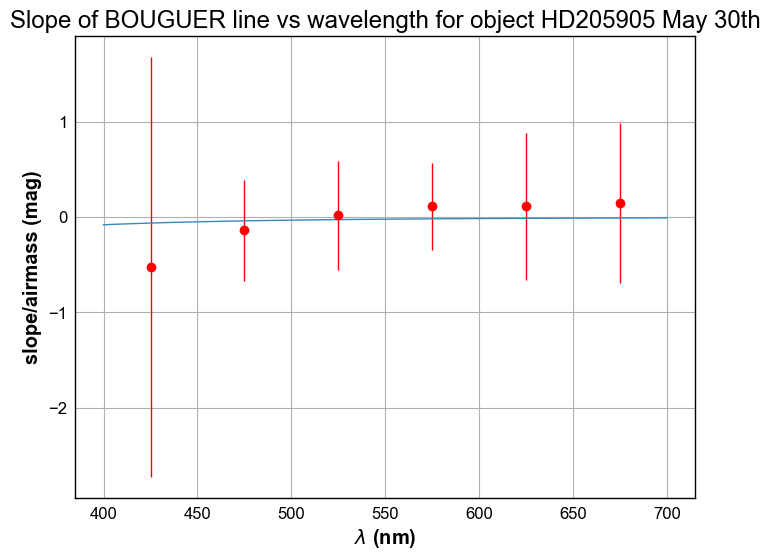

In [83]:
PlotRayleigh(popt_truebouguer,perr_truebouguer)

In [84]:
#all_airmass

In [85]:
index_airmassmin=22

In [86]:
def ShowRatioSpectraNorm(idx,thewl,thespectrum,thesimspec,wlcutmin,all_titles,object_name):
    """
    ShowRatioSpectraNorm: Show the calibration curve Normalisation
    ===============================================================
    
    input parameter :
    - idx : the index of minimum airmass
    - thewl : the list of all wavelengths
    - thespectrum : the list of data spectra
    - thesimspec : the list of simulated spectra
    
    output :
    - ratio wavelength collection
    - R ratio collection
    
    """

    
    XMIN=410.
    XMAX=780.
    
    #XMIN=350.
    #XMAX=800.
    
    YMINR=0.7
    YMAXR=1.1

    
    NBSPECTRA=len(thespectrum)
    
    fig, ax = plt.subplots(1, 1, figsize=(15,6))
    
    # check the spectrum used for normalisation 
    #---------------------------------------------
    ratio_sel0=thespectrum[idx]/thesimspec[idx]
    
    
    
    #interpol_ratio=interp1d(all_rightspectra_wl[idx],ratio_sel0)
    interpol_ratio=interp1d(thewl[idx],ratio_sel0)
    
    #wlcutmax=all_rightspectra_wl[idx].max()-1.
    wlcutmin=XMIN
    wlcutmax=XMAX
    
    #selectedindexes0=np.where(np.logical_and(all_rightspectra_wl[idx]>wlcutmin, all_rightspectra_wl[idx]<wlcutmax))     
    selectedindexes0=np.where(np.logical_and(thewl[idx]>wlcutmin, thewl[idx]<wlcutmax))
    
    #sel_wl0=all_rightspectra_wl[idx][selectedindexes0]  # cut wl
    sel_wl0=thewl[idx][selectedindexes0]
    
    ax.plot(sel_wl0, interpol_ratio(sel_wl0),'r-')
    
    ax.grid(True)
    ax.set_xlim(XMIN,XMAX)
    title='Data/Sim spectra ratio at minimum airmass for object {}'.format(object_name)
    
    ax.set_title(title)
    ax.set_ylabel("ratio Data/Sim")
    ax.set_xlabel("$\lambda$ (nm)")
    
    zam_min=all_airmass[idx]
    print 'minimum airmass zmin = ',zam_min
    
    
    # 2nd plot
    #---------
    fig, ax = plt.subplots(1, 1, figsize=(15,8))

    all_ymin= []
    all_ymax=[]
    all_ratioratio=[]
    all_ratiowl=[]
    all_dzam = []
     
    
    for index in np.arange(0,NBSPECTRA):
        
        #print 'spectrum ',index
        ix=index%5
        iy=index/5
        
        zam=all_airmass[index]
        dzam=zam-zam_min  ## relative airmass
        all_dzam.append(dzam)
        
        #selectedindexes=np.where(np.logical_and(all_rightspectra_wl[index]>wlcutmin, all_rightspectra_wl[index]<wlcutmax))     
        selectedindexes=np.where(np.logical_and(thewl[index]>wlcutmin, thewl[index]<wlcutmax))     
        
        sel_data=thespectrum[index][selectedindexes]
        sel_sim=thesimspec[index][selectedindexes]
        sel_wl=thewl[index][selectedindexes]
                
        
        ratio=sel_data/sel_sim
        ratio0=interpol_ratio(sel_wl)
        
        ratioratio=ratio/ratio0
        
        all_ymin.append(ratioratio.min())
        all_ymax.append(ratioratio.max())
        all_ratioratio.append(ratioratio)
        all_ratiowl.append(sel_wl)
           
        if all_expo[index]>0.:    
            ax.plot(sel_wl,ratioratio,'-',lw=2)
       
            ymin=np.array(all_ymin).min() 
            ymax=np.array(all_ymax).max()*1.1   
        
    ax.set_xlim(XMIN,XMAX)
    ax.set_ylim(YMINR,YMAXR)
    
    ax.get_xaxis().set_minor_locator(mpl.ticker.AutoMinorLocator())
    ax.get_yaxis().set_minor_locator(mpl.ticker.AutoMinorLocator())
    ax.grid(b=True, which='major', color='k', linewidth=2.0)
    ax.grid(b=True, which='minor', color='k', linewidth=0.5)
    
    ax.plot([wl_O2Aline,wl_O2Aline],[ymin,ymax],'b-',label='$O_2(A)$',lw=1)
    ax.plot([wl_O2Bline,wl_O2Bline],[ymin,ymax],'b-',label='$O_2(B)$',lw=1)
    ax.plot([wl_Haline,wl_Haline],[ymin,ymax],'r-',label='$H_{alpha}$',lw=1)
    ax.plot([wl_Hbline,wl_Hbline],[ymin,ymax],'g-',label='$H_{beta}$',lw=1)
    ax.plot([wl_Hgline,wl_Hgline],[ymin,ymax],'c-',label='$H_{gamma}$',lw=1)
    ax.plot([wl_Hdline,wl_Hdline],[ymin,ymax],'k-',label='$H_{delta}$',lw=1)
    #ax.legend(loc='best',fontsize=20)
    title='Normalised Data/Sim spectra for object {}'.format(object_name)
    
    ax.set_title(title)
    ax.set_ylabel("ratio")
    ax.set_xlabel("$\lambda$ (nm)")
    
    figfilename=os.path.join(dir_top_images,'DataSimNormDataSimRRatio.pdf')
    
    plt.savefig(figfilename)
    return np.array(all_ratiowl),np.array(all_ratioratio), np.array(all_dzam)
    return all_ratiowl,all_ratioratio, all_dzam


### Return the ratio

In [87]:
all_ratiowl_cut,all_ratioratio_cut,all_dzam_cut=ShowRatioSpectraNorm(index_airmassmin,all_selected_wl,all_selected_dataspectrum,all_selected_simspectrum,wlcut,all_titles,object_name)

NameError: name 'all_selected_wl' is not defined

In [ ]:
#all_ratiowl_full,all_ratioratio_full,all_dzam_full=ShowRatioSpectraNorm(index_airmassmin,all_rightspectra_wl,all_rightspectra_data,all_rightspectra_sim,wlcut,all_titles,object_name)

## Bouguer Law

In [ ]:
def ShowModifBouguer(idxzmin,thewl,theratio,thedzam):
    """
    ShowModifBouguer:
    
    """
    
    fig, ax = plt.subplots(1, 1, figsize=(6,8))
    
    zmin=all_airmass[idxzmin]
    NBBands=6
    labels=["400-450nm", "450-500nm","500-550nm","550-600nm","600-650nm","650-700nm"]
    WLMINAbs=np.array([400.,450.,500.,550,600,650])
    WLMAXAbs=np.array([450.,500.,550.,600,650,700])
    
    NBRATIO=len(theratio)
    
    all_z = []
    all_log10R1vsZ = []
    all_log10R2vsZ = []
    all_log10R3vsZ = []
    all_log10R4vsZ = []
    all_log10R5vsZ = []
    all_log10R6vsZ = []
    all_log10R1vsZE = []
    all_log10R2vsZE = []
    all_log10R3vsZE = []
    all_log10R4vsZE = []
    all_log10R5vsZE = []
    all_log10R6vsZE = []
    
    # loop on ratio
    for index in np.arange(NBRATIO):
        
        if all_expo[index]>0.: 
        
            thez=thedzam[index]+zmin
              
            wl_current=thewl[index]
            wl_ratio=theratio[index]
        
            nbwl=wl_current.shape[0]
        
            band1=np.where(np.logical_and(wl_current>= WLMINAbs[0],wl_current<WLMAXAbs[0]))
            band2=np.where(np.logical_and(wl_current>= WLMINAbs[1],wl_current<WLMAXAbs[1]))    
            band3=np.where(np.logical_and(wl_current>= WLMINAbs[2],wl_current<WLMAXAbs[2])) 
            band4=np.where(np.logical_and(wl_current>= WLMINAbs[3],wl_current<WLMAXAbs[3])) 
            band5=np.where(np.logical_and(wl_current>= WLMINAbs[4],wl_current<WLMAXAbs[4])) 
            band6=np.where(np.logical_and(wl_current>= WLMINAbs[5],wl_current<WLMAXAbs[5])) 
        
            all_R1=wl_ratio[band1]
            all_R2=wl_ratio[band2]
            all_R3=wl_ratio[band3]
            all_R4=wl_ratio[band4]
            all_R5=wl_ratio[band5]
            all_R6=wl_ratio[band6]
        
            all_log10R1 = 2.5*np.log10(all_R1)
            all_log10R2 = 2.5*np.log10(all_R2)
            all_log10R3 = 2.5*np.log10(all_R3)
            all_log10R4 = 2.5*np.log10(all_R4)
            all_log10R5 = 2.5*np.log10(all_R5)
            all_log10R6 = 2.5*np.log10(all_R6)
    
            all_z.append(thez)
            all_log10R1vsZ.append(np.average(all_log10R1))
            all_log10R2vsZ.append(np.average(all_log10R2))
            all_log10R3vsZ.append(np.average(all_log10R3))
            all_log10R4vsZ.append(np.average(all_log10R4))
            all_log10R5vsZ.append(np.average(all_log10R5))
            all_log10R6vsZ.append(np.average(all_log10R6))
            
            all_log10R1vsZE.append(np.std(all_log10R1)/np.sqrt(all_log10R1.shape[0]))
            all_log10R2vsZE.append(np.std(all_log10R2)/np.sqrt(all_log10R2.shape[0]))
            all_log10R3vsZE.append(np.std(all_log10R3)/np.sqrt(all_log10R3.shape[0]))
            all_log10R4vsZE.append(np.std(all_log10R4)/np.sqrt(all_log10R4.shape[0]))
            all_log10R5vsZE.append(np.std(all_log10R5)/np.sqrt(all_log10R5.shape[0]))
            all_log10R6vsZE.append(np.std(all_log10R6)/np.sqrt(all_log10R6.shape[0]))
        
    ax.errorbar(all_z,all_log10R1vsZ,yerr=all_log10R1vsZE,fmt='--o',color='blue',label=labels[0])
    ax.errorbar(all_z,all_log10R2vsZ,yerr=all_log10R2vsZE,fmt='--o',color='green',label=labels[1])
    ax.errorbar(all_z,all_log10R3vsZ,yerr=all_log10R3vsZE,fmt='--o',color='red',label=labels[2])
    ax.errorbar(all_z,all_log10R4vsZ,yerr=all_log10R4vsZE,fmt='--o',color='magenta',label=labels[3])
    ax.errorbar(all_z,all_log10R5vsZ,yerr=all_log10R5vsZE,fmt='--o',color='black',label=labels[4])
    ax.errorbar(all_z,all_log10R6vsZ,yerr=all_log10R6vsZE,fmt='--o',color='grey',label=labels[5])  
    
    #ax.plot(all_z,all_log10R1vsZ,'o-',label=labels[0])
    #ax.plot(all_z,all_log10R2vsZ,'o-',label=labels[1])
    #ax.plot(all_z,all_log10R3vsZ,'o-',label=labels[2])
    #ax.plot(all_z,all_log10R4vsZ,'o-',label=labels[3])
    #ax.plot(all_z,all_log10R5vsZ,'o-',label=labels[4])
    #ax.plot(all_z,all_log10R6vsZ,'o-',label=labels[5])
    
    ax.grid(True)
    #ax.get_xaxis().set_minor_locator(mpl.ticker.AutoMinorLocator())
    #ax.get_yaxis().set_minor_locator(mpl.ticker.AutoMinorLocator())
    #ax.grid(b=True, which='major', colo1r='k', linewidth=2.0)
    #ax.grid(b=True, which='minor', color='k', linewidth=0.5) 
    title="Modified BOUGUER line for object {}".format(object_name)
    ax.set_title(title)
    ax.set_xlabel("airmass")
    ax.set_ylabel("$\Delta M=2.5*log_{10}(R)=2.5*log_{10}(F_{data}/F_{sim})$ (mag)")
    ax.legend(loc="best")
    figfilename=os.path.join(dir_top_images,'modified_bouguerE1.pdf')
    plt.savefig(figfilename)
    

In [ ]:
ShowModifBouguer(index_airmassmin,all_ratiowl_cut,all_ratioratio_cut,all_dzam_cut)

In [ ]:
def ShowModifBouguer2(idxzmin,thewl,theratio,thedzam):
    """
    ShowModifBouguer2:
    
    """
    
    fig, ax = plt.subplots(1, 1, figsize=(6,8))
    
    zmin=all_airmass[idxzmin]
    NBBands=6
    labels=["400-450nm", "450-500nm","500-550nm","550-600nm","600-650nm","650-700nm"]
    WLMINAbs=np.array([400.,450.,500.,550,600,650])
    WLMAXAbs=np.array([450.,500.,550.,600,650,700])
    
    NBRATIO=len(theratio)
    
    all_z = []
    all_log10R1vsZ = []
    all_log10R2vsZ = []
    all_log10R3vsZ = []
    all_log10R4vsZ = []
    all_log10R5vsZ = []
    all_log10R6vsZ = []
    
    all_log10R1vsZE = []
    all_log10R2vsZE = []
    all_log10R3vsZE = []
    all_log10R4vsZE = []
    all_log10R5vsZE = []
    all_log10R6vsZE = []
    
    # loop on ratio
    for index in np.arange(NBRATIO):
        
        if all_expo[index]>0.: 
        
            thez=thedzam[index]+zmin
              
            wl_current=thewl[index]
            wl_ratio=theratio[index]
        
            nbwl=wl_current.shape[0]
        
            band1=np.where(np.logical_and(wl_current>= WLMINAbs[0],wl_current<WLMAXAbs[0]))
            band2=np.where(np.logical_and(wl_current>= WLMINAbs[1],wl_current<WLMAXAbs[1]))    
            band3=np.where(np.logical_and(wl_current>= WLMINAbs[2],wl_current<WLMAXAbs[2])) 
            band4=np.where(np.logical_and(wl_current>= WLMINAbs[3],wl_current<WLMAXAbs[3])) 
            band5=np.where(np.logical_and(wl_current>= WLMINAbs[4],wl_current<WLMAXAbs[4])) 
            band6=np.where(np.logical_and(wl_current>= WLMINAbs[5],wl_current<WLMAXAbs[5])) 
        
            all_R1=wl_ratio[band1]
            all_R2=wl_ratio[band2]
            all_R3=wl_ratio[band3]
            all_R4=wl_ratio[band4]
            all_R5=wl_ratio[band5]
            all_R6=wl_ratio[band6]
        
            all_log10R1 = 2.5*np.log10(all_R1)
            all_log10R2 = 2.5*np.log10(all_R2)
            all_log10R3 = 2.5*np.log10(all_R3)
            all_log10R4 = 2.5*np.log10(all_R4)
            all_log10R5 = 2.5*np.log10(all_R5)
            all_log10R6 = 2.5*np.log10(all_R6)
    
            all_z.append(thez)
            all_log10R1vsZ.append(np.average(all_log10R1))
            all_log10R2vsZ.append(np.average(all_log10R2))
            all_log10R3vsZ.append(np.average(all_log10R3))
            all_log10R4vsZ.append(np.average(all_log10R4))
            all_log10R5vsZ.append(np.average(all_log10R5))
            all_log10R6vsZ.append(np.average(all_log10R6))
            
            all_log10R1vsZE.append(np.std(all_log10R1))
            all_log10R2vsZE.append(np.std(all_log10R2))
            all_log10R3vsZE.append(np.std(all_log10R3))
            all_log10R4vsZE.append(np.std(all_log10R4))
            all_log10R5vsZE.append(np.std(all_log10R5))
            all_log10R6vsZE.append(np.std(all_log10R6))
        
        
    ax.errorbar(all_z,all_log10R1vsZ,yerr=all_log10R1vsZE,fmt='--o',color='blue',label=labels[0])
    ax.errorbar(all_z,all_log10R2vsZ,yerr=all_log10R2vsZE,fmt='--o',color='green',label=labels[1])
    ax.errorbar(all_z,all_log10R3vsZ,yerr=all_log10R3vsZE,fmt='--o',color='red',label=labels[2])
    ax.errorbar(all_z,all_log10R4vsZ,yerr=all_log10R4vsZE,fmt='--o',color='magenta',label=labels[3])
    ax.errorbar(all_z,all_log10R5vsZ,yerr=all_log10R5vsZE,fmt='--o',color='black',label=labels[4])
    ax.errorbar(all_z,all_log10R6vsZ,yerr=all_log10R6vsZE,fmt='--o',color='grey',label=labels[5])
    #ax.plot(all_z,all_log10R2vsZ,'o-',label=labels[1])
    #ax.plot(all_z,all_log10R3vsZ,'o-',label=labels[2])
    #ax.plot(all_z,all_log10R4vsZ,'o-',label=labels[3])
    #ax.plot(all_z,all_log10R5vsZ,'o-',label=labels[4])
    #ax.plot(all_z,all_log10R6vsZ,'o-',label=labels[5])
    
    ax.grid(True)
    #ax.get_xaxis().set_minor_locator(mpl.ticker.AutoMinorLocator())
    #ax.get_yaxis().set_minor_locator(mpl.ticker.AutoMinorLocator())
    #ax.grid(b=True, which='major', colo1r='k', linewidth=2.0)
    #ax.grid(b=True, which='minor', color='k', linewidth=0.5) 
    title="Modified BOUGUER curve for object {}".format(object_name)
    ax.set_title(title)
    ax.set_xlabel("airmass")
    ax.set_ylabel("$\Delta M=2.5*log_{10}(R)=2.5*log_{10}(F_{data}/F_{sim})$ (mag)")
    ax.legend(loc="best")
    figfilename=os.path.join(dir_top_images,'modified_bouguerE2.pdf')
    plt.savefig(figfilename)
    

In [ ]:
ShowModifBouguer2(index_airmassmin,all_ratiowl_cut,all_ratioratio_cut,all_dzam_cut)

In [ ]:
def SimpleLinearFitBouguer(idxzmin,thewl,theratio,thedzam):
    """
    FitBouguer:
    
    """
    
    ZCUT=1.59
    
    fig, ax = plt.subplots(1, 1, figsize=(6,8))
    
    zmin=all_airmass[idxzmin]
    
    NBBands=6
    labels=["400-450nm", "450-500nm","500-550nm","550-600nm","600-650nm","650-700nm"]
    WLMINAbs=np.array([400.,450.,500.,550,600,650])
    WLMAXAbs=np.array([450.,500.,550.,600,650,700])
    
    NBRATIO=len(theratio)
    
    all_z1 = []
    all_log10R1vsZ1 = []
    all_log10R2vsZ1 = []
    all_log10R3vsZ1 = []
    all_log10R4vsZ1 = []
    all_log10R5vsZ1 = []
    all_log10R6vsZ1 = []
    
    all_z2 = []
    all_log10R1vsZ2 = []
    all_log10R2vsZ2 = []
    all_log10R3vsZ2 = []
    all_log10R4vsZ2 = []
    all_log10R5vsZ2 = []
    all_log10R6vsZ2 = []
    
    fitparam1 = []
    fitparam2 = []
    y1fit = []
    y2fit = []
    x1fit=np.linspace(1.,ZCUT,50)
    x2fit=np.linspace(ZCUT,2.0,50)
    # loop on ratio
    #---------------
    for index in np.arange(NBRATIO):
        
        if all_expo[index]>0.: 
        
            thez=thedzam[index]+zmin
              
            wl_current=thewl[index]
            wl_ratio=theratio[index]
        
            nbwl=wl_current.shape[0]
        
            band1=np.where(np.logical_and(wl_current>= WLMINAbs[0],wl_current<WLMAXAbs[0]))
            band2=np.where(np.logical_and(wl_current>= WLMINAbs[1],wl_current<WLMAXAbs[1]))    
            band3=np.where(np.logical_and(wl_current>= WLMINAbs[2],wl_current<WLMAXAbs[2])) 
            band4=np.where(np.logical_and(wl_current>= WLMINAbs[3],wl_current<WLMAXAbs[3])) 
            band5=np.where(np.logical_and(wl_current>= WLMINAbs[4],wl_current<WLMAXAbs[4])) 
            band6=np.where(np.logical_and(wl_current>= WLMINAbs[5],wl_current<WLMAXAbs[5])) 
                
            all_R1=wl_ratio[band1]
            all_R2=wl_ratio[band2]
            all_R3=wl_ratio[band3]
            all_R4=wl_ratio[band4]
            all_R5=wl_ratio[band5]
            all_R6=wl_ratio[band6]
            
            all_log10R1 = 2.5*np.log10(all_R1)
            all_log10R2 = 2.5*np.log10(all_R2)
            all_log10R3 = 2.5*np.log10(all_R3)
            all_log10R4 = 2.5*np.log10(all_R4)
            all_log10R5 = 2.5*np.log10(all_R5)
            all_log10R6 = 2.5*np.log10(all_R6)
            
            if(thez<=ZCUT):  
                all_z1.append(thez)
                all_log10R1vsZ1.append(np.average(all_log10R1))
                all_log10R2vsZ1.append(np.average(all_log10R2))
                all_log10R3vsZ1.append(np.average(all_log10R3))
                all_log10R4vsZ1.append(np.average(all_log10R4))
                all_log10R5vsZ1.append(np.average(all_log10R5))
                all_log10R6vsZ1.append(np.average(all_log10R6))
            else:
                all_z2.append(thez)
                all_log10R1vsZ2.append(np.average(all_log10R1))
                all_log10R2vsZ2.append(np.average(all_log10R2))
                all_log10R3vsZ2.append(np.average(all_log10R3))
                all_log10R4vsZ2.append(np.average(all_log10R4))
                all_log10R5vsZ2.append(np.average(all_log10R5))
                all_log10R6vsZ2.append(np.average(all_log10R6))
    
    
    x1=np.array(all_z1) 
    
    for iband in np.arange(NBBands):
        if iband==0:
            y=np.array(all_log10R1vsZ1)
        elif iband ==1:
            y=np.array(all_log10R2vsZ1)
        elif iband==2:
            y=np.array(all_log10R3vsZ1)
        elif iband ==3:
            y=np.array(all_log10R4vsZ1) 
        elif iband==4:
            y=np.array(all_log10R5vsZ1)
        elif iband ==5:
            y=np.array(all_log10R6vsZ1) 
            
        z1 = np.polyfit(x1, y, 1)
        fitparam1.append(z1)    
        p1 = np.poly1d(z1)
        yfit=p1(x1fit)
        y1fit.append(yfit)
        
    x2=np.array(all_z2)
    
    for iband in np.arange(NBBands):
        if iband==0:
            y=np.array(all_log10R1vsZ2)
        elif iband ==1:
            y=np.array(all_log10R2vsZ2)
        elif iband==2:
            y=np.array(all_log10R3vsZ2)
        elif iband ==3:
            y=np.array(all_log10R4vsZ2) 
        elif iband==4:
            y=np.array(all_log10R5vsZ2)
        elif iband ==5:
            y=np.array(all_log10R6vsZ2)            
        z2 = np.polyfit(x2, y, 1)
        fitparam2.append(z2)    
        p2 = np.poly1d(z2)
        yfit=p2(x2fit)
        y2fit.append(yfit)
                
    xfit=np.append(x1fit,x2fit)
    
    yfit=np.append(y1fit[0],y2fit[0])
    yfit=yfit-yfit[0] 
    ax.plot(xfit,yfit,'b-',lw=2,label=labels[0])
    
     
    yfit=np.append(y1fit[1],y2fit[1])
    yfit=yfit-yfit[1] 
    ax.plot(xfit,yfit,'r-',lw=2,label=labels[1])
    
    yfit=np.append(y1fit[2],y2fit[2])
    yfit=yfit-yfit[2] 
    ax.plot(xfit,yfit,'g-',lw=2,label=labels[2])
    
    yfit=np.append(y1fit[3],y2fit[3])
    yfit=yfit-yfit[3] 
    ax.plot(xfit,yfit,'k-',lw=2,label=labels[3])
    
    yfit=np.append(y1fit[4],y2fit[4])
    yfit=yfit-yfit[4] 
    ax.plot(xfit,yfit,'c-',lw=2,label=labels[4])
    
    yfit=np.append(y1fit[5],y2fit[5])
    yfit=yfit-yfit[5] 
    ax.plot(xfit,yfit,'y-',lw=2,label=labels[5])
    
    
    #ax.plot(xfit,np.append(y1fit[1],y2fit[1]),'r-',lw=2,label=labels[1])
    #ax.plot(xfit,np.append(y1fit[2],y2fit[2]),'g-',lw=2,label=labels[2])
    #ax.plot(xfit,np.append(y1fit[3],y2fit[3]),'k-',lw=2,label=labels[3])
    #ax.plot(xfit,np.append(y1fit[4],y2fit[4]),'c-',lw=2,label=labels[4])
    #ax.plot(xfit,np.append(y1fit[5],y2fit[5]),'y-',lw=2,label=labels[5])
    
    
    #ax.plot(xfit,y1fit[2],'g-',label=labels[2])
    #ax.plot(xfit,y1fit[3],'k-',label=labels[3])
    #ax.plot(xfit,y1fit[4],'c-',label=labels[4])
    #ax.plot(xfit,y1fit[5],'y-',label=labels[5])
    
    #ax.plot(x2fit,y2fit[0],'b-')
    #ax.plot(x2fit,y2fit[1],'r-')
    #ax.plot(x2fit,y2fit[2],'g-')
    #ax.plot(x2fit,y2fit[3],'k-')
    #ax.plot(x2fit,y2fit[4],'c-')
    #ax.plot(x2fit,y2fit[5],'y-')
    
    
    ax.grid(True)
    #ax.get_xaxis().set_minor_locator(mpl.ticker.AutoMinorLocator())
    #ax.get_yaxis().set_minor_locator(mpl.ticker.AutoMinorLocator())
    
    #ax.grid(b=True, which='major', colo1r='k', linewidth=2.0)
    #ax.grid(b=True, which='minor', color='k', linewidth=0.5) 
    title="Simple Fit BOUGUER lines for object {}".format(object_name)
    ax.set_title(title)
    ax.set_xlabel("airmass")
    ax.set_ylabel("$\Delta M=2.5*log_{10}(R)=2.5*log_{10}(F_{data}/F_{sim})$ (mag)")
    ax.legend(loc="best")
    figfilename=os.path.join(dir_top_images,'fitbougher1.pdf')
    plt.savefig(figfilename)
    return np.array(fitparam1),np.array(fitparam2)
    

In [ ]:
fitparam1_cut,fitparam2_cut=SimpleLinearFitBouguer(index_airmassmin,all_ratiowl_cut,all_ratioratio_cut,all_dzam_cut)

In [ ]:
truncfitparam1_cut=np.trunc(np.array(fitparam1_cut)*10000)/10000
truncfitparam2_cut=np.trunc(np.array(fitparam2_cut)*10000)/10000

In [ ]:
table = ListTable()
table.append(["slope (z<1.59)","slope (z>1.59)"])
for idd in range(0,6):
    table.append([truncfitparam1_cut[idd][0],truncfitparam2_cut[idd][0]])
table

In [ ]:
WLarr=np.array([425.,475.,525.,575.,625.,675.])
plt.plot(500/WLarr,fitparam1_cut[:,1] ,'o',color='blue')
plt.plot(500/WLarr,fitparam2_cut[:,1] ,'s',color='red')
plt.grid(True)
plt.xlabel("500nm/$\lambda (nm)$")

In [ ]:
# import numpy.polynomial.polynomial.polyfit as polyfitw

In [ ]:
from scipy.optimize import curve_fit

In [ ]:
#def bougline(x, a, b):
#    return a*x + b

In [ ]:
def FitABouguerLine(thex,they,theey):
    
    x=np.copy(thex)
    y=np.copy(they)
    ey=np.copy(theey)
    z = np.polyfit(x,y, 1)    
    popt, pcov = curve_fit(bougline,x,y,p0=z,sigma=ey)
    perr = np.sqrt(np.diag(pcov))
    return popt,perr

In [ ]:
def FitBouguer2(idxzmin,thewl,theratio,thedzam):
    """
    FitBouguer2:
    
    """
    
    ZCUT=1.59
    
    fig, ax = plt.subplots(1, 1, figsize=(6,8))
    
    zmin=all_airmass[idxzmin]
    NBBands=6
    labels=["400-450nm", "450-500nm","500-550nm","550-600nm","600-650nm","650-700nm"]
    WLMINAbs=np.array([400.,450.,500.,550,600,650])
    WLMAXAbs=np.array([450.,500.,550.,600,650,700])
    
    NBRATIO=len(theratio)
    
    all_z = []
    all_log10R1vsZ = []
    all_log10R2vsZ = []
    all_log10R3vsZ = []
    all_log10R4vsZ = []
    all_log10R5vsZ = []
    all_log10R6vsZ = []
    
    all_log10R1vsZE = []
    all_log10R2vsZE = []
    all_log10R3vsZE = []
    all_log10R4vsZE = []
    all_log10R5vsZE = []
    all_log10R6vsZE = []
    
    
    all_z1 = []
    all_log10R1vsZ1 = []
    all_log10R2vsZ1 = []
    all_log10R3vsZ1 = []
    all_log10R4vsZ1 = []
    all_log10R5vsZ1 = []
    all_log10R6vsZ1 = []
    
    all_log10R1vsZ1E = []
    all_log10R2vsZ1E = []
    all_log10R3vsZ1E = []
    all_log10R4vsZ1E = []
    all_log10R5vsZ1E = []
    all_log10R6vsZ1E = []
    
    
    all_z2 = []
    all_log10R1vsZ2 = []
    all_log10R2vsZ2 = []
    all_log10R3vsZ2 = []
    all_log10R4vsZ2 = []
    all_log10R5vsZ2 = []
    all_log10R6vsZ2 = []
    
    all_log10R1vsZ2E = []
    all_log10R2vsZ2E = []
    all_log10R3vsZ2E = []
    all_log10R4vsZ2E = []
    all_log10R5vsZ2E = []
    all_log10R6vsZ2E = []
    
    fitparam1 = []
    fitparam2 = []
    
    fitparam1err = []
    fitparam2err = []
    
    x1fit=np.linspace(1.,ZCUT,50)
    x2fit=np.linspace(ZCUT,2.0,50)
    
    
    # loop on ratio to compute arerage and error points, that is to say, on the airmass z
    for index in np.arange(NBRATIO):
        
        if all_expo[index]>0: 
        
            thez=thedzam[index]+zmin
            
           
              
            wl_current=thewl[index]
            wl_ratio=theratio[index]
        
            nbwl=wl_current.shape[0]
        
            band1=np.where(np.logical_and(wl_current>= WLMINAbs[0],wl_current<WLMAXAbs[0]))
            band2=np.where(np.logical_and(wl_current>= WLMINAbs[1],wl_current<WLMAXAbs[1]))    
            band3=np.where(np.logical_and(wl_current>= WLMINAbs[2],wl_current<WLMAXAbs[2])) 
            band4=np.where(np.logical_and(wl_current>= WLMINAbs[3],wl_current<WLMAXAbs[3])) 
            band5=np.where(np.logical_and(wl_current>= WLMINAbs[4],wl_current<WLMAXAbs[4])) 
            band6=np.where(np.logical_and(wl_current>= WLMINAbs[5],wl_current<WLMAXAbs[5])) 
        
            all_R1=wl_ratio[band1]
            all_R2=wl_ratio[band2]
            all_R3=wl_ratio[band3]
            all_R4=wl_ratio[band4]
            all_R5=wl_ratio[band5]
            all_R6=wl_ratio[band6]
        
            all_log10R1 = 2.5*np.log10(all_R1)
            all_log10R2 = 2.5*np.log10(all_R2)
            all_log10R3 = 2.5*np.log10(all_R3)
            all_log10R4 = 2.5*np.log10(all_R4)
            all_log10R5 = 2.5*np.log10(all_R5)
            all_log10R6 = 2.5*np.log10(all_R6)
    
            all_z.append(thez)
            all_log10R1vsZ.append(np.average(all_log10R1))
            all_log10R2vsZ.append(np.average(all_log10R2))
            all_log10R3vsZ.append(np.average(all_log10R3))
            all_log10R4vsZ.append(np.average(all_log10R4))
            all_log10R5vsZ.append(np.average(all_log10R5))
            all_log10R6vsZ.append(np.average(all_log10R6))
            
            all_log10R1vsZE.append(np.std(all_log10R1)/np.sqrt(all_log10R1.shape[0]))
            all_log10R2vsZE.append(np.std(all_log10R2)/np.sqrt(all_log10R2.shape[0]))
            all_log10R3vsZE.append(np.std(all_log10R3)/np.sqrt(all_log10R3.shape[0]))
            all_log10R4vsZE.append(np.std(all_log10R4)/np.sqrt(all_log10R4.shape[0]))
            all_log10R5vsZE.append(np.std(all_log10R5)/np.sqrt(all_log10R5.shape[0]))
            all_log10R6vsZE.append(np.std(all_log10R6)/np.sqrt(all_log10R6.shape[0]))
            
           
            # separate according the conditions depending on Z
            #--------------------------------------------------
            if thez<=ZCUT:  
                all_z1.append(thez)
                all_log10R1vsZ1.append(np.average(all_log10R1))
                all_log10R2vsZ1.append(np.average(all_log10R2))
                all_log10R3vsZ1.append(np.average(all_log10R3))
                all_log10R4vsZ1.append(np.average(all_log10R4))
                all_log10R5vsZ1.append(np.average(all_log10R5))
                all_log10R6vsZ1.append(np.average(all_log10R6))
                
                all_log10R1vsZ1E.append(np.std(all_log10R1)/np.sqrt(all_log10R1.shape[0]))
                all_log10R2vsZ1E.append(np.std(all_log10R2)/np.sqrt(all_log10R2.shape[0]))
                all_log10R3vsZ1E.append(np.std(all_log10R3)/np.sqrt(all_log10R3.shape[0]))
                all_log10R4vsZ1E.append(np.std(all_log10R4)/np.sqrt(all_log10R4.shape[0]))
                all_log10R5vsZ1E.append(np.std(all_log10R5)/np.sqrt(all_log10R5.shape[0]))
                all_log10R6vsZ1E.append(np.std(all_log10R6)/np.sqrt(all_log10R6.shape[0]))
            else:
                all_z2.append(thez)
                all_log10R1vsZ2.append(np.average(all_log10R1))
                all_log10R2vsZ2.append(np.average(all_log10R2))
                all_log10R3vsZ2.append(np.average(all_log10R3))
                all_log10R4vsZ2.append(np.average(all_log10R4))
                all_log10R5vsZ2.append(np.average(all_log10R5))
                all_log10R6vsZ2.append(np.average(all_log10R6))
                
                all_log10R1vsZ2E.append(np.std(all_log10R1)/np.sqrt(all_log10R1.shape[0]))
                all_log10R2vsZ2E.append(np.std(all_log10R2)/np.sqrt(all_log10R2.shape[0]))
                all_log10R3vsZ2E.append(np.std(all_log10R3)/np.sqrt(all_log10R3.shape[0]))
                all_log10R4vsZ2E.append(np.std(all_log10R4)/np.sqrt(all_log10R4.shape[0]))
                all_log10R5vsZ2E.append(np.std(all_log10R5)/np.sqrt(all_log10R5.shape[0]))
                all_log10R6vsZ2E.append(np.std(all_log10R6)/np.sqrt(all_log10R6.shape[0]))
            
   
    
    # plot the points    
    ax.errorbar(all_z,all_log10R1vsZ,yerr=all_log10R1vsZE,fmt='o',color='blue',label=labels[0])
    ax.errorbar(all_z,all_log10R2vsZ,yerr=all_log10R2vsZE,fmt='o',color='green',label=labels[1])
    ax.errorbar(all_z,all_log10R3vsZ,yerr=all_log10R3vsZE,fmt='o',color='red',label=labels[2])
    ax.errorbar(all_z,all_log10R4vsZ,yerr=all_log10R4vsZE,fmt='o',color='magenta',label=labels[3])
    ax.errorbar(all_z,all_log10R5vsZ,yerr=all_log10R5vsZE,fmt='o',color='black',label=labels[4])
    ax.errorbar(all_z,all_log10R6vsZ,yerr=all_log10R6vsZE,fmt='o',color='grey',label=labels[5])
    
    
    
    ## Now does the fit for z<ZCUT
    
    all_z1=np.array(all_z1)
    all_z2=np.array(all_z2)
    all_log10R1vsZ1=np.array(all_log10R1vsZ1)
    all_log10R2vsZ1=np.array(all_log10R2vsZ1)
    all_log10R3vsZ1=np.array(all_log10R3vsZ1)
    all_log10R4vsZ1=np.array(all_log10R4vsZ1)
    all_log10R5vsZ1=np.array(all_log10R5vsZ1)
    all_log10R6vsZ1=np.array(all_log10R6vsZ1)
    
    all_log10R1vsZ1E=np.array(all_log10R1vsZ1E)
    all_log10R2vsZ1E=np.array(all_log10R2vsZ1E)
    all_log10R3vsZ1E=np.array(all_log10R3vsZ1E)
    all_log10R4vsZ1E=np.array(all_log10R4vsZ1E)
    all_log10R5vsZ1E=np.array(all_log10R5vsZ1E)
    all_log10R6vsZ1E=np.array(all_log10R6vsZ1E)
    
    
    popt,perr=FitABouguerLine(all_z1,all_log10R1vsZ1,all_log10R1vsZ1E)
    pol = np.poly1d(popt)
    y1fit=pol(x1fit)
    plt.plot(x1fit,y1fit,'b-',lw=2)   
    fitparam1.append(popt)
    fitparam1err.append(perr)
    
    
    popt,perr=FitABouguerLine(all_z1,all_log10R2vsZ1,all_log10R2vsZ1E)
    pol = np.poly1d(popt)
    y1fit=pol(x1fit)
    plt.plot(x1fit,y1fit,'g-',lw=2)
    fitparam1.append(popt)
    fitparam1err.append(perr)
   
    
    popt,perr=FitABouguerLine(all_z1,all_log10R3vsZ1,all_log10R3vsZ1E)
    pol = np.poly1d(popt)
    y1fit=pol(x1fit)
    plt.plot(x1fit,y1fit,'r-',lw=2)
    fitparam1.append(popt)
    fitparam1err.append(perr)
    
    popt,perr=FitABouguerLine(all_z1,all_log10R4vsZ1,all_log10R4vsZ1E)
    pol = np.poly1d(popt)
    y1fit=pol(x1fit)
    plt.plot(x1fit,y1fit,'m-',lw=2)
    fitparam1.append(popt)
    fitparam1err.append(perr)
    
    popt,perr=FitABouguerLine(all_z1,all_log10R5vsZ1,all_log10R5vsZ1E)
    pol = np.poly1d(popt)
    y1fit=pol(x1fit)
    plt.plot(x1fit,y1fit,'k-',lw=2)
    fitparam1.append(popt)
    fitparam1err.append(perr)
    
    popt,perr=FitABouguerLine(all_z1,all_log10R6vsZ1,all_log10R6vsZ1E)
    pol = np.poly1d(popt)
    y1fit=pol(x1fit)
    plt.plot(x1fit,y1fit,'-',color='grey',lw=2)
    fitparam1.append(popt)
    fitparam1err.append(perr)
        
    popt,perr=FitABouguerLine(all_z2,all_log10R1vsZ2,all_log10R1vsZ2E)
    pol = np.poly1d(popt)
    y2fit=pol(x2fit)
    plt.plot(x2fit,y2fit,'b-',lw=2)
    fitparam2.append(popt)
    fitparam2err.append(perr)
    
    popt,perr=FitABouguerLine(all_z2,all_log10R2vsZ2,all_log10R2vsZ2E)
    pol = np.poly1d(popt)
    y2fit=pol(x2fit)
    plt.plot(x2fit,y2fit,'g-',lw=2)
    fitparam2.append(popt)
    fitparam2err.append(perr)
    
    popt,perr=FitABouguerLine(all_z2,all_log10R3vsZ2,all_log10R3vsZ2E)
    pol = np.poly1d(popt)
    y2fit=pol(x2fit)
    plt.plot(x2fit,y2fit,'r-',lw=2)
    fitparam2.append(popt)
    fitparam2err.append(perr)
    
    popt,perr=FitABouguerLine(all_z2,all_log10R4vsZ2,all_log10R4vsZ2E)
    pol = np.poly1d(popt)
    y2fit=pol(x2fit)
    plt.plot(x2fit,y2fit,'m-',lw=2)
    fitparam2.append(popt)
    fitparam2err.append(perr)
    
    popt,perr=FitABouguerLine(all_z2,all_log10R5vsZ2,all_log10R5vsZ2E)
    pol = np.poly1d(popt)
    y2fit=pol(x2fit)
    plt.plot(x2fit,y2fit,'k-',lw=2)
    fitparam2.append(popt)
    fitparam2err.append(perr)
    
    popt,perr=FitABouguerLine(all_z2,all_log10R6vsZ2,all_log10R6vsZ2E)
    pol = np.poly1d(popt)
    y2fit=pol(x2fit)
    plt.plot(x2fit,y2fit,'-',color='grey',lw=2)
    fitparam2.append(popt)
    fitparam2err.append(perr)
    
    
    
    ax.grid(True)
    #ax.get_xaxis().set_minor_locator(mpl.ticker.AutoMinorLocator())
    #ax.get_yaxis().set_minor_locator(mpl.ticker.AutoMinorLocator())
    #ax.grid(b=True, which='major', colo1r='k', linewidth=2.0)
    #ax.grid(b=True, which='minor', color='k', linewidth=0.5) 
    title="Modified BOUGUER line for object {}".format(object_name)
    ax.set_title(title)
    #ax.set_xlim(1.3,2)
    ax.set_xlabel("airmass")
    ax.set_ylabel("$\Delta M=2.5*log_{10}(R)=2.5*log_{10}(F_{data}/F_{sim})$ (mag)")
    ax.legend(loc="best")
    figfilename=os.path.join(dir_top_images,'modified_fitbougherE1.pdf')
    plt.savefig(figfilename)
    
    return fitparam1,fitparam2,fitparam1err,fitparam2err
    

In [ ]:
fitparam1,fitparam2,fitparam1err,fitparam2err=FitBouguer2(index_airmassmin,all_ratiowl_cut,all_ratioratio_cut,all_dzam_cut)

In [ ]:
truncfitparam1=np.trunc(np.array(fitparam1)*10000)/10000
truncfitparam2=np.trunc(np.array(fitparam2)*10000)/10000
truncfitparam1err=np.trunc(np.array(fitparam1err)*10000)/10000
truncfitparam2err=np.trunc(np.array(fitparam2err)*10000)/10000

In [ ]:
table = ListTable()
table.append(["slope (z<1.59)","err-slope (z<1.59)","slope (z>1.59)","err-slope (z>1.59)"])
for idd in range(0,6):
    table.append([truncfitparam1[idd][0],truncfitparam1err[idd][0] , truncfitparam2[idd][0],truncfitparam2err[idd][0]])
table

## Fit Ratio

In [ ]:
def FitRatio(all_ratiowl,all_ratioratio,all_dzam,figtitle='Normalised Data/Sim spectra for object {}'):
    NBRATIO=len(all_ratioratio)
    
    XMIN=400.
    XMAX=740.
    YMAX=1.1
    YMIN=0.7
    
    xfit=np.linspace(XMIN,XMAX,50)
    
    fitparam= []
    
    fig, ax = plt.subplots(1, 1, figsize=(15,8))
    
    for index in np.arange(NBRATIO):
        dz=all_dzam[index]
        
        if all_expo[index]>0 and dz>0 : 
            x=all_ratiowl[index]
            y=all_ratioratio[index]
            z = np.polyfit(x, y, 1)
            fitparam.append(z)
        
            p = np.poly1d(z)
            yfit=p(xfit)
        
           
            ax.plot(xfit,yfit,'-',lw=1)
            
    ax.get_xaxis().set_minor_locator(mpl.ticker.AutoMinorLocator())
    ax.get_yaxis().set_minor_locator(mpl.ticker.AutoMinorLocator())
    ax.grid(b=True, which='major', color='k', linewidth=2.0)
    ax.grid(b=True, which='minor', color='k', linewidth=0.5)        
            
    ax.set_ylim(YMIN,YMAX)        
            
    title=figtitle.format(object_name)
    ax.set_title(title)
    ax.set_ylabel("ratio")
    ax.set_xlabel("$\lambda$ (nm)")
    
    figfilename=os.path.join(dir_top_images,'FitLinearDataSimNormDataSimRRatio.pdf')
    plt.savefig(figfilename)
    
    return np.array(fitparam)

In [ ]:
fitparam_cut=FitRatio(all_ratiowl_cut,all_ratioratio_cut,all_dzam_cut)

# New U ratio
================

## Definition of U ratio
=============================
$$
U(\lambda, z-z_{min}) = \frac{ \frac{T_{data}(z)}{T_{sim}(z)}}{ \frac{T_{data}(z_{min})}{T_{sim}(z_{min})}}= 
\exp \left( (z-z_{min}) \times \left(\tau_v^{gray}+ \tau_v^{aer}(\lambda_0/\lambda)^\alpha \right) \right)
$$


by calculating the following ratio $W(\lambda)$
$$
W(\lambda) = \frac{- \ln R(\lambda,z-z_{min})}{(z-z_{min})} = \tau_v^{gray}+ \tau_v^{aer}(\lambda_0/\lambda)^\alpha 
$$


From the series of images, we calculate $W(\lambda)$

### find the correspondence airmass-index

In [ ]:
NBAIRMASS=len(all_airmass)
zipped=zip(range(NBAIRMASS),all_airmass)
print zipped

### defines the range where to compute the ratio ratio

In [ ]:
idxnorm1=1
idxstart1=2
idxstop1=53

idxnorm2=54
idxstart2=55
idxstop2=103

In [ ]:
def ExtractURatioSpectraNorm(idxnorm,idxstart,idxstop,thewl,thespectrum,thesimspec,wlcutmin,all_titles,object_name):
    """
    ExtractURatioSpectraNorm: Show the calibration curve Normalisation
    ===============================================================
    
    input parameter :
    - idxnorm : the index of minimum airmass
    - idxstart : index to start the airmass loop
    - idxstop : index for stopping the airmass loop
    - thewl : the list of all wavelengths
    - thespectrum : the list of data spectra
    - thesimspec : the list of simulated spectra
    
    output :
    - ratio wavelength collection
    - R ratio collection
    
    """

    
    XMIN=410.
    XMAX=780.
  
    
    YMINR=0.7
    YMAXR=1.1

    
    NBSPECTRA=len(thespectrum)
    
    fig, ax = plt.subplots(1, 1, figsize=(15,6))
    
    # check the spectrum used for normalisation 
    #---------------------------------------------
    ratio_sel0=thespectrum[idxnorm]/thesimspec[idxnorm]
    
    
   
    interpol_ratio=interp1d(thewl[idxnorm],ratio_sel0)
    
    
    wlcutmin=XMIN
    wlcutmax=XMAX
    
        
    selectedindexes0=np.where(np.logical_and(thewl[idxnorm]>wlcutmin, thewl[idxnorm]<wlcutmax))
   
    sel_wl0=thewl[idxnorm][selectedindexes0]
    
    ax.plot(sel_wl0, interpol_ratio(sel_wl0),'r-')
    
    ax.grid(True)
    ax.set_xlim(XMIN,XMAX)
    title='Data/Sim spectra ratio at minimum airmass for object {}'.format(object_name)
    
    ax.set_title(title)
    ax.set_ylabel("ratio Data/Sim")
    ax.set_xlabel("$\lambda$ (nm)")
    
    zam_min=all_airmass[idxnorm]
    print 'minimum airmass zmin = ',zam_min
    
    
    # 2nd plot
    #---------
    fig, ax = plt.subplots(1, 1, figsize=(15,8))

    all_ymin= []
    all_ymax=[]
    all_ratioratio=[]
    all_ratiowl=[]
    all_dzam = []
     
    
    #for index in np.arange(0,NBSPECTRA):
    for fullindex in np.arange(idxstart,idxstop+1):    
        
        index=fullindex-idxstart
        
        #print 'spectrum ',index
        ix=index%5
        iy=index/5
        
        # the current airmass
        zam=all_airmass[fullindex]
        
        dzam=zam-zam_min  ## relative airmass
        all_dzam.append(dzam)
        
        # select the ratio in the appropriate WL range
        selectedindexes=np.where(np.logical_and(thewl[fullindex]>wlcutmin, thewl[fullindex]<wlcutmax))     
        
        sel_data=thespectrum[fullindex][selectedindexes]
        sel_sim=thesimspec[fullindex][selectedindexes]
        sel_wl=thewl[fullindex][selectedindexes]
                
        
        ratio=sel_data/sel_sim
        ratio0=interpol_ratio(sel_wl)
        
        ratioratio=ratio/ratio0
        
        all_ymin.append(ratioratio.min())
        all_ymax.append(ratioratio.max())
        all_ratioratio.append(ratioratio)
        all_ratiowl.append(sel_wl)
           
        if all_expo[fullindex]>0:    ## Should always be the case now
            ax.plot(sel_wl,ratioratio,'-',lw=2)
       
            ymin=np.array(all_ymin).min() 
            ymax=np.array(all_ymax).max()*1.1   
        
    ax.set_xlim(XMIN,XMAX)
    ax.set_ylim(YMINR,YMAXR)
    
    ax.get_xaxis().set_minor_locator(mpl.ticker.AutoMinorLocator())
    ax.get_yaxis().set_minor_locator(mpl.ticker.AutoMinorLocator())
    ax.grid(b=True, which='major', color='k', linewidth=2.0)
    ax.grid(b=True, which='minor', color='k', linewidth=0.5)
    
    ax.plot([wl_O2Aline,wl_O2Aline],[ymin,ymax],'b-',label='$O_2(A)$',lw=1)
    ax.plot([wl_O2Bline,wl_O2Bline],[ymin,ymax],'b-',label='$O_2(B)$',lw=1)
    ax.plot([wl_Haline,wl_Haline],[ymin,ymax],'r-',label='$H_{alpha}$',lw=1)
    ax.plot([wl_Hbline,wl_Hbline],[ymin,ymax],'g-',label='$H_{beta}$',lw=1)
    ax.plot([wl_Hgline,wl_Hgline],[ymin,ymax],'c-',label='$H_{gamma}$',lw=1)
    ax.plot([wl_Hdline,wl_Hdline],[ymin,ymax],'k-',label='$H_{delta}$',lw=1)
    #ax.legend(loc='best',fontsize=20)
    title='Normalised Data/Sim spectra U ratio for object {}'.format(object_name)
    
    ax.set_title(title)
    ax.set_ylabel("ratio")
    ax.set_xlabel("$\lambda$ (nm)")
    
    figfilename=os.path.join(dir_top_images,'DataSimNormDataSimURatio.pdf')
    
    plt.savefig(figfilename)
    return np.array(all_ratiowl),np.array(all_ratioratio), np.array(all_dzam)
    return all_ratiowl,all_ratioratio, all_dzam



In [ ]:
all_ratiowl_cut1,all_ratioratio_cut1,all_dzam_cut1=ExtractURatioSpectraNorm(idxnorm1,idxstart1,idxstop1,all_selected_wl,all_selected_dataspectrum,all_selected_simspectrum,wlcut,all_titles,object_name)

In [ ]:
all_ratiowl_cut2,all_ratioratio_cut2,all_dzam_cut2=ExtractURatioSpectraNorm(idxnorm2,idxstart2,idxstop2,all_selected_wl,all_selected_dataspectrum,all_selected_simspectrum,wlcut,all_titles,object_name)

In [ ]:
def PlotExtinction1(all_ratiowl,all_ratioratio,all_dzam,figtitle='U ratio for object {}'):
    """
    Extinction versus lambda
    
    """
    NBRATIO=len(all_ratioratio)
    
    XMIN=400.
    XMAX=740.
    YMAX=3
    YMIN=-3

    
    fig, ax = plt.subplots(1, 1, figsize=(15,8))
    
    for index in np.arange(NBRATIO):
        dzam=all_dzam[index]
        if dzam != 0 and all_expo[index] !=0  :      
            x=all_ratiowl[index]
            y=-np.log(all_ratioratio[index])/dzam
            ax.plot(x,y,'o',lw=2)
        
        
            
    ax.get_xaxis().set_minor_locator(mpl.ticker.AutoMinorLocator())
    ax.get_yaxis().set_minor_locator(mpl.ticker.AutoMinorLocator())
    ax.grid(b=True, which='major', color='k', linewidth=2.0)
    ax.grid(b=True, which='minor', color='k', linewidth=0.5)        
            
    ax.set_ylim(YMIN,YMAX)        
            
    title=figtitle.format(object_name)
    ax.set_title(title)
    ax.set_ylabel(" U ratio")
    ax.set_xlabel("$\lambda$ (nm)")
    
    figfilename=os.path.join(dir_top_images,'Extinction1_Uratio.pdf')
    plt.savefig(figfilename)
   

In [ ]:
PlotExtinction1(all_ratiowl_cut1,all_ratioratio_cut1,all_dzam_cut1)

In [ ]:
PlotExtinction1(all_ratiowl_cut2,all_ratioratio_cut2,all_dzam_cut2)

In [ ]:
def PlotExtinction2(all_ratiowl,all_ratioratio,all_dzam,figtitle='U ratio for object {}'):
    """
    Extinction versus 1/lambda
    
    """
    NBRATIO=len(all_ratioratio)
    
    XMIN=400.
    XMAX=740.
    YMAX=3
    YMIN=-3

    
    fig, ax = plt.subplots(1, 1, figsize=(15,8))
    
    for index in np.arange(NBRATIO):
        dzam=all_dzam[index]
        if dzam != 0 and all_expo[index] !=0  :      
            x=500./all_ratiowl[index]
            y=-np.log(all_ratioratio[index])/dzam
            ax.plot(x,y,'o',lw=2)
        
        
            
    ax.get_xaxis().set_minor_locator(mpl.ticker.AutoMinorLocator())
    ax.get_yaxis().set_minor_locator(mpl.ticker.AutoMinorLocator())
    ax.grid(b=True, which='major', color='k', linewidth=2.0)
    ax.grid(b=True, which='minor', color='k', linewidth=0.5)        
            
    ax.set_ylim(YMIN,YMAX)        
            
    title=figtitle.format(object_name)
    ax.set_title(title)
    ax.set_ylabel(" U ratio")
    ax.set_xlabel("$500nm/\lambda$ (nm)")
   
    figfilename=os.path.join(dir_top_images,'Extinction2_Uratio.pdf')
    plt.savefig(figfilename)
    

In [ ]:
PlotExtinction2(all_ratiowl_cut1,all_ratioratio_cut1,all_dzam_cut1)

In [ ]:
PlotExtinction2(all_ratiowl_cut2,all_ratioratio_cut2,all_dzam_cut2)

### Linear fit of extinction

In [ ]:
def LinearFitExtinction(all_ratiowl,all_ratioratio,all_dzam,figtitle=' Fit U ratio for object {}'):
   
    NBRATIOS=len(all_ratioratio)
    
    print "NBRATIOS =",NBRATIOS
    
    XMIN=0.65
    XMAX=1.3
    YMAX=1
    YMIN=-1

    xfit=np.linspace(XMIN,XMAX,50)
    
    fitparam= []
    all_dzrel= []
    
    fig, ax = plt.subplots(1, 1, figsize=(15,8))
    
    for index in np.arange(NBRATIOS):
        dzam=all_dzam[index]
        if dzam != 0 and all_expo[index]>0  : 
            all_dzrel.append(dzam)
            x=500./all_ratiowl[index]
            y=-np.log(all_ratioratio[index])/dzam
                        
            z = np.polyfit(x, y, 1)
            fitparam.append(z)
        
            p = np.poly1d(z)
            yfit=p(xfit)
         
            ax.plot(xfit,yfit,'-',lw=1)        
        
            
    ax.get_xaxis().set_minor_locator(mpl.ticker.AutoMinorLocator())
    ax.get_yaxis().set_minor_locator(mpl.ticker.AutoMinorLocator())
    ax.grid(b=True, which='major', color='k', linewidth=2.0)
    ax.grid(b=True, which='minor', color='k', linewidth=0.5)        
            
    ax.set_ylim(YMIN,YMAX)        
            
    title=figtitle.format(object_name)
    ax.set_title(title)
    ax.set_ylabel(" U ratio")
    ax.set_xlabel("$500nm/\lambda$ (nm)")
   
    figfilename=os.path.join(dir_top_images,'FitLinearExtinction2_Uratio.pdf')
    plt.savefig(figfilename)
    
        
    return np.array(fitparam), all_dzrel
        

In [ ]:
fitparam_cut1,all_dzrel_cut1=LinearFitExtinction(all_ratiowl_cut1,all_ratioratio_cut1,all_dzam_cut1)

In [ ]:
fitparam_cut2,all_dzrel_cut2=LinearFitExtinction(all_ratiowl_cut2,all_ratioratio_cut2,all_dzam_cut2)

### Non linear fit of extinction

In [ ]:
from scipy.optimize import curve_fit

In [ ]:
def extinct(x, a, b,c):
    return a + b * x**c

In [ ]:
def FitExtinct(thex,they):
    x=np.copy(thex)
    y=np.copy(they)
    z = np.polyfit(x,y, 1)
    z=np.append(z,1.)
    popt, pcov = curve_fit(extinct,x,y,p0=z)
    perr = np.sqrt(np.diag(pcov))
    return popt,perr

In [ ]:
def NonLinearFitExtinction1(all_ratiowl,all_ratioratio,all_dzam,figtitle=' Fit W ratio for object {}'):
    NBRATIO=len(all_ratioratio)
    
    XMIN=0.65
    XMAX=1.3
    YMAX=0.5
    YMIN=-0.2

    xfit=np.linspace(XMIN,XMAX,50)
    
    fitoptparam= []
    fitperr= []
    fitchi2=[]
    all_dzrel= []
    
    fig, ax = plt.subplots(1, 1, figsize=(15,8))
    
    for index in np.arange(NBRATIO):
        dzam=all_dzam[index]
        if dzam != 0 and all_expo[index]>0  : 
            all_dzrel.append(dzam)
            x=500./all_ratiowl[index]
            y=-np.log(all_ratioratio[index])/dzam   ### Here divide by dzam to remove airmass dependence
            
            popt, perr = FitExtinct(x, y)
            chi2_vector=(y-extinct(x,popt[0],popt[1],popt[2]))**2
            chi2=np.average(chi2_vector)
            
            #print '------------------------------------'
            #print "a =", popt[0], "+/-", pcov[0,0]**0.5
            #print "b =", popt[1], "+/-", pcov[1,1]**0.5
            #print "c =", popt[2], "+/-", pcov[2,2]**0.5
            #print "chi2 =", chi2
                       
        
            fitoptparam.append(popt)  
            fitperr.append(perr)
            fitchi2.append(chi2)
            
            yfit=extinct(xfit,popt[0],popt[1],popt[2])
         
            if chi2 <0.003:              
                ax.plot(x,y,'o')
                ax.plot(xfit,yfit,'-',lw=2) 
            
    ax.get_xaxis().set_minor_locator(mpl.ticker.AutoMinorLocator())
    ax.get_yaxis().set_minor_locator(mpl.ticker.AutoMinorLocator())
    ax.grid(b=True, which='major', color='k', linewidth=2.0)
    ax.grid(b=True, which='minor', color='k', linewidth=0.5)        
            
    ax.set_ylim(YMIN,YMAX)        
            
    title=figtitle.format(object_name)
    ax.set_title(title)
    ax.set_ylabel(" W ratio")
    ax.set_xlabel("$500/\lambda$ (nm)")
    
    figfilename=os.path.join(dir_top_images,'FitNonLinearExtinction1_Uratio.pdf')
    plt.savefig(figfilename)
   
        
    return np.array(fitoptparam), all_dzrel, fitperr,fitchi2
        

In [ ]:
fitoptparam_cut1,all_dzrel_cut1,fitperr_cut1,fitchi2_cut1=NonLinearFitExtinction1(all_ratiowl_cut1,all_ratioratio_cut1,all_dzam_cut1)

In [ ]:
fitoptparam_cut2,all_dzrel_cut2,fitperr_cut2,fitchi2_cut2=NonLinearFitExtinction1(all_ratiowl_cut2,all_ratioratio_cut2,all_dzam_cut2)

## Component 1 : z < zcut
----------------------------------

In [ ]:
plt.figure(figsize=(6,4.))
n, bins, patches = plt.hist(fitchi2_cut1, 50, normed=1, range=[0,0.01],facecolor='blue', alpha=0.75)
plt.yscale('log', nonposy='clip')
plt.grid(True)
plt.xlabel("$\chi^2$")
figtitle='Chi2 (object {})'.format(object_name)
plt.title(figtitle)

In [ ]:
def GetMeanAndSigma(arr):
    themean=np.mean(arr)
    thevariance=np.var(arr)
    thesigma=np.sqrt(thevariance)
    newmean=np.trunc(themean*1000)/1000
    newsigma=np.trunc(thesigma*1000)/1000
    #newmean=np.round(themean,3)
    #newsigma=np.round(thesigma,3)
    #newmean=np.rint(themean*1000)/1000
    #newsigma=np.rint(thesigma*1000)/1000
    thevariation=newsigma/newmean
    thevaria=np.trunc(thevariation*100)
    return newmean,newsigma,thevaria

### grey attenuation

In [ ]:
GetMeanAndSigma(fitoptparam_cut1[:,0])

In [ ]:
print "median = ",np.median(fitoptparam_cut1[:,0])
print "average = ",np.average(fitoptparam_cut1[:,0])
print "std = ",np.std(fitoptparam_cut1[:,0])

In [ ]:
plt.figure(figsize=(8,4.))
greyattenuation=fitoptparam_cut1[:,0]
plt.plot(all_dzrel_cut1,fitoptparam_cut1[:,0],'o')
plt.ylim(-0.5,0.5)
plt.grid()
plt.xlabel("$z-z_{min}$")
plt.ylabel("Optical depth")

figtitle='Grey attenuation (object {})'.format(object_name)
plt.title(figtitle)

figfilename=os.path.join(dir_top_images,'GreyAttvsDz1.pdf')
plt.savefig(figfilename)

In [ ]:
plt.figure(figsize=(6,4.))
n, bins, patches = plt.hist(fitoptparam_cut1[:,0], 50, normed=1, range=[-0.5,0.5],facecolor='blue', alpha=0.75)
plt.grid()
plt.xlabel("Vertical grey optical depth")
figtitle='Grey attenuation (object {})'.format(object_name)
plt.title(figtitle)
figfilename=os.path.join(dir_top_images,'GreyAttHisto1.pdf')
plt.savefig(figfilename)

### Aerosols  

In [ ]:
GetMeanAndSigma(fitoptparam_cut1[:,1])

In [ ]:
print "median = ",np.median(fitoptparam_cut1[:,1])
print "average = ",np.average(fitoptparam_cut1[:,1])
print "std = ",np.std(fitoptparam_cut1[:,1])

In [ ]:
plt.figure(figsize=(8,4.))
plt.plot(all_dzrel_cut1,fitoptparam_cut1[:,1],'o')
plt.ylim(-1,1)
plt.grid()

figtitle="Vertical aerosol optical depth at $\lambda$ = 500 nm (object {})".format(object_name)
plt.title(figtitle)
plt.xlabel("$z-z_{min}$")
plt.ylabel("Optical depth")
figfilename=os.path.join(dir_top_images,'AerAttvsDz1.pdf')
plt.savefig(figfilename)

In [ ]:
plt.figure(figsize=(6,4.))
n, bins, patches = plt.hist(fitoptparam_cut1[:,1], 50, normed=1, range=[-0.5,0.5],facecolor='blue', alpha=0.75)
plt.grid()
plt.xlabel("Vertical aerosol optical depth")
plt.title("Aerosol attenuation")
figtitle="Aerosol attenuation (object {})".format(object_name)
plt.title(figtitle)
figfilename=os.path.join(dir_top_images,'AerAttHisto1.pdf')
plt.savefig(figfilename)

### Angstrom exponent

In [ ]:
GetMeanAndSigma(fitoptparam_cut1[:,2])

In [ ]:
print "median = ",np.median(fitoptparam_cut1[:,2])
print "average = ",np.average(fitoptparam_cut1[:,2])
print "std = ",np.std(fitoptparam_cut1[:,2])

In [ ]:
plt.figure(figsize=(8,4.))
plt.plot(all_dzrel_cut1,fitoptparam_cut1[:,2],'o')
plt.ylim(-1,1)
plt.grid()
figtitle="Aerosol attenuation (object {})".format(object_name)
plt.title(figtitle)
plt.xlabel("$z-z_{min}$")
plt.ylabel("Angstrom exponent")
figfilename=os.path.join(dir_top_images,'AerAngstrvsDz1.pdf')
plt.savefig(figfilename)

In [ ]:
plt.figure(figsize=(6,4.))
n, bins, patches = plt.hist(fitoptparam_cut1[:,2], 50, normed=1, range=[-0.5,0.5],facecolor='blue', alpha=0.75)
plt.grid()
plt.xlabel("Angstrom exponent")
figtitle="Aerosol attenuation (object {})".format(object_name)
plt.title(figtitle)
figfilename=os.path.join(dir_top_images,'AerAngstrHisto1.pdf')
plt.savefig(figfilename)

## Component 2 : z > zcut
----------------------------------

In [ ]:
plt.figure(figsize=(6,4.))
n, bins, patches = plt.hist(fitchi2_cut2, 50, normed=1, range=[0,0.01],facecolor='blue', alpha=0.75)
plt.yscale('log', nonposy='clip')
plt.grid(True)
plt.xlabel("$\chi^2$")
figtitle='Chi2 (object {})'.format(object_name)
plt.title(figtitle)

#### Grey attenuation

In [ ]:
GetMeanAndSigma(fitoptparam_cut2[:,0])

In [ ]:
print "median = ",np.median(fitoptparam_cut2[:,0])
print "average = ",np.average(fitoptparam_cut2[:,0])
print "std = ",np.std(fitoptparam_cut2[:,0])


In [ ]:
plt.figure(figsize=(8,4.))
greyattenuation=fitoptparam_cut2[:,0]
plt.plot(all_dzrel_cut2,fitoptparam_cut2[:,0],'o')
plt.ylim(-0.5,0.5)
plt.grid()
plt.xlabel("$z-z_{min}$")
plt.ylabel("Optical depth")

figtitle='Grey attenuation (object {})'.format(object_name)
plt.title(figtitle)

figfilename=os.path.join(dir_top_images,'GreyAttvsDz2.pdf')
plt.savefig(figfilename)

In [ ]:
plt.figure(figsize=(6,4.))
n, bins, patches = plt.hist(fitoptparam_cut2[:,0], 50, normed=1, range=[-0.5,0.5],facecolor='blue', alpha=0.75)
plt.grid()
plt.xlabel("Vertical grey optical depth")
figtitle='Grey attenuation (object {})'.format(object_name)
plt.title(figtitle)
figfilename=os.path.join(dir_top_images,'GreyAttHisto2.pdf')
plt.savefig(figfilename)

### Aerosols

In [ ]:
GetMeanAndSigma(fitoptparam_cut2[:,1])

In [ ]:
print "median = ",np.median(fitoptparam_cut2[:,1])
print "average = ",np.average(fitoptparam_cut2[:,1])
print "std = ",np.std(fitoptparam_cut2[:,1])

In [ ]:
plt.figure(figsize=(8,4.))
plt.plot(all_dzrel_cut2,fitoptparam_cut2[:,1],'o')
plt.ylim(-1,1)
plt.grid()

figtitle="Vertical aerosol optical depth at $\lambda$ = 500 nm (object {})".format(object_name)
plt.title(figtitle)
plt.xlabel("$z-z_{min}$")
plt.ylabel("Optical depth")
figfilename=os.path.join(dir_top_images,'AerAttvsDz2.pdf')
plt.savefig(figfilename)

In [ ]:
plt.figure(figsize=(6,4.))
n, bins, patches = plt.hist(fitoptparam_cut2[:,1], 50, normed=1, range=[-0.5,0.5],facecolor='blue', alpha=0.75)
plt.grid()
plt.xlabel("Vertical aerosol optical depth")
plt.title("Aerosol attenuation")
figtitle="Aerosol attenuation (object {})".format(object_name)
plt.title(figtitle)
figfilename=os.path.join(dir_top_images,'AerAttHisto2.pdf')
plt.savefig(figfilename)

### Angstrom

In [ ]:
GetMeanAndSigma(fitoptparam_cut2[:,2])

In [ ]:
print "median = ",np.median(fitoptparam_cut2[:,2])
print "average = ",np.average(fitoptparam_cut2[:,2])
print "std = ",np.std(fitoptparam_cut2[:,2])

In [ ]:
plt.figure(figsize=(8,4.))
plt.plot(all_dzrel_cut2,fitoptparam_cut2[:,2],'o')
plt.ylim(-1,1)
plt.grid()
figtitle="Aerosol attenuation (object {})".format(object_name)
plt.title(figtitle)
plt.xlabel("$z-z_{min}$")
plt.ylabel("Angstrom exponent")
figfilename=os.path.join(dir_top_images,'AerAngstrvsDz2.pdf')
plt.savefig(figfilename)

In [ ]:
plt.figure(figsize=(6,4.))
n, bins, patches = plt.hist(fitoptparam_cut2[:,2], 50, normed=1, range=[-0.5,0.5],facecolor='blue', alpha=0.75)
plt.grid()
plt.xlabel("Angstrom exponent")
figtitle="Aerosol attenuation (object {})".format(object_name)
plt.title(figtitle)
figfilename=os.path.join(dir_top_images,'AerAngstrHisto2.pdf')
plt.savefig(figfilename)

In [ ]:
XMIN=0.65
XMAX=1.3

In [ ]:
XminBin=np.arange(XMIN,XMAX,0.05)
XmaxBin=np.arange(XMIN+0.05,XMAX+0.05,0.05)

In [ ]:
XaverBin=(XminBin+XmaxBin)/2
    

In [ ]:
print XminBin
print XmaxBin
print XaverBin

In [ ]:
theibin=np.where(np.logical_and(XminBin<=0.84,XmaxBin>0.84))

In [ ]:
len(XminBin)

In [ ]:
print theibin[0][0]

In [ ]:
a=np.empty(0)

In [ ]:
a=np.append(a,1)

In [ ]:
a

### first simple model without Rayleigh 

In [ ]:
def fullextinct(x, a, b, c ):
    "Model of extinction containing a contamination with residual Rayleigh scattering"
    return a + b * x**c 

In [ ]:
def badjacfullextinct(x, a, b, c ):
    "Model of extinction containing a contamination with residual Rayleigh scattering"
    jac1=1 
    jac2=x**c
    jac3=b*x**c*np.log(x)
    return np.array([jac1,jac2,jac3])

In [ ]:
#def myDfun( a,b,c, xdata, ydata, f ) :
def myDfun( xdata,a,b,c) :    
    jac1=np.ones(len(xdata))
    jac2=xdata**c
    jac3=b*xdata**c*np.log(xdata)
    res = np.vstack( ( jac1, jac2 , jac3 ) ).T
    return res

In [ ]:
def FitFullExtinct(thex,they,theerry):

    x=np.copy(thex)
    y=np.copy(they)
    ey=np.copy(theerry)
    
    z = np.polyfit(x,y, 1) # start a linear fit to find initialisation parameter
    
    z=np.append(z,1.) # add angstrom exponent
    #z=np.append(z,0.01) # add a tiny contribution for Raleigh
    
    #popt, pcov = curve_fit(fullextinct,x,y,p0=z,sigma=ey,absolute_sigma=True)
    #popt, pcov = curve_fit(fullextinct,x,y,p0=z,sigma=ey,absolute_sigma=False)
    popt, pcov = curve_fit(fullextinct,x,y,sigma=ey,jac=myDfun,bounds=([0,0.,0.1], [0.1, 0.1, 4.]))
    perr = np.sqrt(np.diag(pcov))
    return popt,perr

### second complex  model with Rayleigh

In [ ]:
def fullextinct_r(x, a, b, c,d ):
    "Model of extinction containing a contamination with residual Rayleigh scattering"
    return a + b * x**c + d*x**4

In [ ]:
def myDfun_r( xdata,a,b,c,d) :    
    jac1=np.ones(len(xdata))
    jac2=xdata**c
    jac3=b*xdata**c*np.log(xdata)
    jac4=xdata**4
    res = np.vstack( ( jac1, jac2 , jac3, jac4 ) ).T
    return res

In [ ]:
def FitFullExtinct_r(thex,they,theerry):

    x=np.copy(thex)
    y=np.copy(they)
    ey=np.copy(theerry)
    
    z = np.polyfit(x,y, 1) # start a linear fit to find initialisation parameter
    
    z=np.append(z,1.) # add angstrom exponent
    #z=np.append(z,0.01) # add a tiny contribution for Raleigh
    
    #popt, pcov = curve_fit(fullextinct,x,y,p0=z,sigma=ey,absolute_sigma=True)
    #popt, pcov = curve_fit(fullextinct,x,y,p0=z,sigma=ey,absolute_sigma=False)
    popt, pcov = curve_fit(fullextinct_r,x,y,sigma=ey,jac=myDfun_r,bounds=([0,0.,0.1,0.], [0.1, 0.1, 3.,0.1]))
    perr = np.sqrt(np.diag(pcov))
    return popt,perr

In [ ]:
def NonLinearFitExtinction2(all_ratiowl,all_ratioratio,all_dzam,figtitle=' Fit W ratio with grey + aerosol extinct for object {}'):
    """
    Fit without rayleigh
    """

    NBRATIO=len(all_ratioratio)
    
    
    XMIN=0.65
    XMAX=1.3
    
    YMAX=0.5
    YMIN=-0.2

    # Defines 13 bins in 500/lambda where histograms will be done
    XminBin=np.arange(XMIN,XMAX,0.05)
    XmaxBin=np.arange(XMIN+0.05,XMAX+0.05,0.05)
    XaverBin=(XminBin+XmaxBin)/2.
 
    NBBINS=XminBin.shape[0]
    
    all_histos=[]
    
    for ibin in np.arange(NBBINS):
        all_histos.append(np.empty(0))
        
    
    xfit=np.linspace(XMIN,XMAX,50)
    
    fitoptparam= []
    fitperr= []
    fitchi2=[]
    all_dzrel= []
    
    all_X = []
    all_Y = []
    all_EY = []
    all_N = []
    
    fig, ax = plt.subplots(1, 1, figsize=(15,8))
    
    for index in np.arange(NBRATIO): ## Loop on ratio
        dzam=all_dzam[index]
        if dzam != 0 and all_expo[index]>0  : 
            all_dzrel.append(dzam)
            
                        
            x_set=500./all_ratiowl[index]
            y_set=-2.5*np.log10(all_ratioratio[index])/dzam   ### Here divide by dzam to remove airmass dependence
            
            wlcount=0 # counter
            for x in x_set:
                y=y_set[wlcount]
                theibin=np.where(np.logical_and(XminBin<=x,XmaxBin>x))[0][0]
                all_histos[theibin]=np.append(all_histos[theibin],y)
                wlcount+=1   # increate counter
            
           
            
    for ibin in np.arange(NBBINS):
        theN=all_histos[ibin].shape[0]
        if theN > 3:
            all_N.append(theN)
            all_X.append(XaverBin[ibin])
            all_Y.append(np.median(all_histos[ibin]))
            all_EY.append(np.std(all_histos[ibin])/np.sqrt(theN))             
    
    
    all_X_forFit=np.array(all_X)        
    all_Y_forFit=np.array(all_Y)
    all_EY_forFit=np.array(all_EY)
    
    all_X_forFit=np.delete(all_X_forFit,11)
    all_Y_forFit=np.delete(all_Y_forFit,11)
    all_EY_forFit=np.delete(all_EY_forFit,11)
    
    all_X_forFit=np.delete(all_X_forFit,10)
    all_Y_forFit=np.delete(all_Y_forFit,10)
    all_EY_forFit=np.delete(all_EY_forFit,10)
    
    all_X_forFit=np.delete(all_X_forFit,0)
    all_Y_forFit=np.delete(all_Y_forFit,0)
    all_EY_forFit=np.delete(all_EY_forFit,0)
    
        
    popt,perr=FitFullExtinct(all_X_forFit,all_Y_forFit,all_EY_forFit)  # No Rayleigh
    #popt,perr=FitFullExtinct_r(all_X,all_Y,all_EY)  
    
    xfit=np.linspace(XMIN,XMAX,50)
    yfit=fullextinct(xfit, popt[0], popt[1], popt[2] )
    
    plt.plot(xfit,yfit,'b-')
            
    ax.get_xaxis().set_minor_locator(mpl.ticker.AutoMinorLocator())
    ax.get_yaxis().set_minor_locator(mpl.ticker.AutoMinorLocator())
    #ax.grid(b=True, which='major', color='k', linewidth=2.0)
    ax.grid(b=True)
    #ax.grid(b=True, which='minor', color='k', linewidth=0.5)        
            
    #ax.set_ylim(YMIN,YMAX)        
     
    plt.errorbar(all_X,all_Y,yerr=all_EY,fmt='o',color="red")
    plt.errorbar(all_X_forFit,all_Y_forFit,yerr=all_EY_forFit,fmt='o',color="green") 
                          
    title=figtitle.format(object_name)
    ax.set_title(title)
    ax.set_ylabel(" W ratio")
    ax.set_xlabel("$500/\lambda$ (nm)")
    ax.set_ylim(-0.2,.5)
    
    figfilename=os.path.join(dir_top_images,'FitNonLinearExtinction2_Wratio.pdf')
    plt.savefig(figfilename)
    return popt,perr
   
        
  
        

In [ ]:
def NonLinearFitExtinction2_r(all_ratiowl,all_ratioratio,all_dzam,figtitle=' Fit W ratio with grey + aerosol + resid rayleigh extinct  for object {}'):
    
    """
    Fit with Rayleigh
    """

    NBRATIO=len(all_ratioratio)
    
    
    XMIN=0.65
    XMAX=1.3
    
    YMAX=0.5
    YMIN=-0.2

    # Defines 13 bins in 500/lambda where histograms will be done
    XminBin=np.arange(XMIN,XMAX,0.05)
    XmaxBin=np.arange(XMIN+0.05,XMAX+0.05,0.05)
    XaverBin=(XminBin+XmaxBin)/2.
 
    NBBINS=XminBin.shape[0]
    
    all_histos=[]
    
    for ibin in np.arange(NBBINS):
        all_histos.append(np.empty(0))
        
    
    xfit=np.linspace(XMIN,XMAX,50)
    
    fitoptparam= []
    fitperr= []
    fitchi2=[]
    all_dzrel= []
    
    all_X = []
    all_Y = []
    all_EY = []
    all_N = []
    
    fig, ax = plt.subplots(1, 1, figsize=(15,8))
    
    for index in np.arange(NBRATIO): ## Loop on ratio
        dzam=all_dzam[index]
        if dzam != 0 and all_expo[index]>0  : 
            all_dzrel.append(dzam)
            
                        
            x_set=500./all_ratiowl[index]
            y_set=-2.5*np.log10(all_ratioratio[index])/dzam   ### Here divide by dzam to remove airmass dependence
            
            wlcount=0 # counter
            for x in x_set:
                y=y_set[wlcount]
                theibin=np.where(np.logical_and(XminBin<=x,XmaxBin>x))[0][0]
                all_histos[theibin]=np.append(all_histos[theibin],y)
                wlcount+=1   # increate counter
            
           
            
    for ibin in np.arange(NBBINS):
        theN=all_histos[ibin].shape[0]
        if theN > 3:
            all_N.append(theN)
            all_X.append(XaverBin[ibin])
            all_Y.append(np.median(all_histos[ibin]))
            all_EY.append(np.std(all_histos[ibin])/np.sqrt(theN))             
    
    all_X_forFit=np.array(all_X)        
    all_Y_forFit=np.array(all_Y)
    all_EY_forFit=np.array(all_EY)
    
    all_X_forFit=np.delete(all_X_forFit,11)
    all_Y_forFit=np.delete(all_Y_forFit,11)
    all_EY_forFit=np.delete(all_EY_forFit,11)
    
    all_X_forFit=np.delete(all_X_forFit,10)
    all_Y_forFit=np.delete(all_Y_forFit,10)
    all_EY_forFit=np.delete(all_EY_forFit,10)
    
    all_X_forFit=np.delete(all_X_forFit,0)
    all_Y_forFit=np.delete(all_Y_forFit,0)
    all_EY_forFit=np.delete(all_EY_forFit,0)
        
    #popt,perr=FitFullExtinct(all_X,all_Y,all_EY)  
    popt,perr=FitFullExtinct_r(all_X_forFit,all_Y_forFit,all_EY_forFit)  
    
    xfit=np.linspace(XMIN,XMAX,50)
    yfit=fullextinct(xfit, popt[0], popt[1], popt[2] )
    
    plt.plot(xfit,yfit,'b-')
            
    ax.get_xaxis().set_minor_locator(mpl.ticker.AutoMinorLocator())
    ax.get_yaxis().set_minor_locator(mpl.ticker.AutoMinorLocator())
    #ax.grid(b=True, which='major', color='k', linewidth=2.0)
    ax.grid(b=True)
    #ax.grid(b=True, which='minor', color='k', linewidth=0.5)        
            
    #ax.set_ylim(YMIN,YMAX)        
     
    plt.errorbar(all_X,all_Y,yerr=all_EY,fmt='o',color="red") 
    plt.errorbar(all_X_forFit,all_Y_forFit,yerr=all_EY_forFit,fmt='o',color="green") 
                          
    title=figtitle.format(object_name)
    ax.set_title(title)
    ax.set_ylabel(" W ratio")
    ax.set_xlabel("$500/\lambda$ (nm)")
    ax.set_ylim(-0.2,.5)
    
    figfilename=os.path.join(dir_top_images,'FitNonLinearExtinction2_Wratio_r.pdf')
    plt.savefig(figfilename)
    return popt,perr
   
        
  
        

In [ ]:
popt1,perr1=NonLinearFitExtinction2_r(all_ratiowl_cut1,all_ratioratio_cut1,all_dzam_cut1)

In [ ]:
popt1

In [ ]:
perr1

In [ ]:
popt2,perr2=NonLinearFitExtinction2(all_ratiowl_cut2,all_ratioratio_cut2,all_dzam_cut2)

In [ ]:
popt2

In [ ]:
perr2